In [130]:
import os
import itertools
import xlsxwriter

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

import DataPreparation as dpr
import ModelRun as mr
import benchmarks as bench
from MyEstimators import CLS_Estimator

# Load data

In [131]:
df = dpr.read_data('EQP_Quarterly')
df = dpr.data_clean(df, '1956-01-01')

## Add $y_{t-1}, y_{t-2}$ and construct X and y

In [133]:
df['y_lag'] = df['EQP'].shift(1)
df['new_cay'] = df['c'] - 0.218*df['w'] - 0.801*df['y']
df = df.dropna()
df.head()

EQP        DP        DY        EP        DE      svar  \
time                                                                     
1956-09-01 -0.034415 -3.204645 -3.239744 -2.573142 -0.631503  0.002519   
1956-12-01  0.033241 -3.289216 -3.260525 -2.616389 -0.672827  0.004394   
1957-03-01 -0.050750 -3.238565 -3.294980 -2.562911 -0.675654  0.002288   
1957-06-01  0.075114 -3.309868 -3.238565 -2.628349 -0.681519  0.001363   
1957-09-01 -0.108352 -3.182306 -3.292675 -2.503465 -0.678841  0.004218   

                 b/m      ntis     tbl     lty  ...     DFY      infl  \
time                                            ...                     
1956-09-01  0.571910  0.029362  0.0284  0.0324  ...  0.0051  0.007353   
1956-12-01  0.544177  0.026149  0.0321  0.0345  ...  0.0062  0.007299   
1957-03-01  0.599819  0.026600  0.0308  0.0331  ...  0.0077  0.007246   
1957-06-01  0.565877  0.030528  0.0329  0.0361  ...  0.0072  0.010791   
1957-09-01  0.624151  0.034363  0.0353  0.0364  ...  0.0081  0.007117   

                   c          w         y       cay     AAA     BAA     y_lag  \
time                                                                            
1956-09-01  9.269304  11.086198  9.106428  0.000663  0.0356  0.0407 -0.028264   
1956-12-01  9.277993  11.096678  9.118405 -0.002524  0.0375  0.0437 -0.034415   
1957-03-01  9.280482  11.090721  9.117433  0.002041  0.0366  0.0443  0.033241   
1957-06-01  9.278119  11.104916  9.118823 -0.004528  0.0391  0.0463 -0.050750   
1957-09-01  9.281519  11.089344  9.117364  0.003433  0.0412  0.0493  0.075114   

             new_cay  
time                  
1956-09-01 -0.441736  
1956-12-01 -0.444925  
1957-03-01 -0.440359  
1957-06-01 -0.446930  
1957-09-01 -0.438967  

[5 rows x 23 columns]

In [134]:
df_AR2 = df.copy()
df_AR2['y_2lag'] = df['y_lag'].shift(1)
df_AR2 = df_AR2.dropna()
df_AR2.head()

EQP        DP        DY        EP        DE      svar  \
time                                                                     
1956-12-01  0.033241 -3.289216 -3.260525 -2.616389 -0.672827  0.004394   
1957-03-01 -0.050750 -3.238565 -3.294980 -2.562911 -0.675654  0.002288   
1957-06-01  0.075114 -3.309868 -3.238565 -2.628349 -0.681519  0.001363   
1957-09-01 -0.108352 -3.182306 -3.292675 -2.503465 -0.678841  0.004218   
1957-12-01 -0.063108 -3.106414 -3.165404 -2.473717 -0.632697  0.009677   

                 b/m      ntis     tbl     lty  ...      infl         c  \
time                                            ...                       
1956-12-01  0.544177  0.026149  0.0321  0.0345  ...  0.007299  9.277993   
1957-03-01  0.599819  0.026600  0.0308  0.0331  ...  0.007246  9.280482   
1957-06-01  0.565877  0.030528  0.0329  0.0361  ...  0.010791  9.278119   
1957-09-01  0.624151  0.034363  0.0353  0.0364  ...  0.007117  9.281519   
1957-12-01  0.653676  0.034873  0.0304  0.0323  ...  0.003534  9.277414   

                    w         y       cay     AAA     BAA     y_lag   new_cay  \
time                                                                            
1956-12-01  11.096678  9.118405 -0.002524  0.0375  0.0437 -0.034415 -0.444925   
1957-03-01  11.090721  9.117433  0.002041  0.0366  0.0443  0.033241 -0.440359   
1957-06-01  11.104916  9.118823 -0.004528  0.0391  0.0463 -0.050750 -0.446930   
1957-09-01  11.089344  9.117364  0.003433  0.0412  0.0493  0.075114 -0.438967   
1957-12-01  11.087980  9.108525  0.006706  0.0381  0.0503 -0.108352 -0.435694   

              y_2lag  
time                  
1956-12-01 -0.028264  
1957-03-01 -0.034415  
1957-06-01  0.033241  
1957-09-01 -0.050750  
1957-12-01  0.075114  

[5 rows x 24 columns]

# Construct single-index and nonlinear models

## Single-index

In [135]:
def single_index(x):
    if isinstance(x, (pd.DataFrame, np.ndarray)):
        if isinstance(x, pd.DataFrame):
            x_values = x.values
        else:
            pass
    else:
        raise Exception('wrong type')

    def u(theta):
        if len(theta) == x_values.shape[1]:
            sum_up = [x_values[:, i] * theta[i] for i in range(x_values.shape[1])]
            index = np.sum(sum_up, axis=0)
        else:
            raise Exception('wrong parameter dimension')
        return index

    return u

### dimension function

In [136]:
extra_params = {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':2,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }

In [137]:
def dimensions(non_sta, sta, func):
    stas = sta.shape[1]
    nonstas = non_sta.shape[1]
    extra = range(0, extra_params[func])
    return nonstas, stas, extra

## Nonlienar Models

In [138]:
def sin_func(x):
    def objective_func(params):
        func = np.sin(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [139]:
def cos_func(x):
    def objective_func(params):
        func = np.cos(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [140]:
def scaled_sin_func(x):
    def objective_func(params):
        func = np.sin(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [141]:
def scaled_cos_func(x):
    def objective_func(params):
        func = np.cos(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [142]:
def exp_shift_func(x):
    def objective_func(params):
        func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))-params[d1+d2+extra[0]])**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [143]:
def exp_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(params[0:d1]))**2
                                )+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [144]:
def poly_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+params[d1+d2+extra[2]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

In [145]:
def linear_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

### Constraint

In [146]:
def constraint_func(x):
    def constraint(params):
        con = 0
        for j in np.arange(0, x.iloc[:,:d1].shape[1]):
            con += params[j]**2
            cons = con - 1
        return cons
    return {'type':'eq', 'fun': constraint}

## Empirical Study

### Cointegrated predictors
- dividend-price ratio and dividend yield
- T-bill rate and long-term yield
- dividend-price ratio and earningprice ratio
- baa- and aaa-rated corporate bond yields

In [148]:
co1 = df[['DP', 'DY']]
co2 = df[['tbl', 'lty']]
co3 = df[['DP', 'EP']]
co4 = df[['BAA', 'AAA']]
y = df[['EQP']].squeeze()

station_ar1 = df[['y_lag', 'new_cay']]

cointe_ar1 = [co1, co2, co3, co4]
names_ar1 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar1[i].name = names_ar1[i]

In [150]:
co1_ar2 = df_AR2[['DP', 'DY']]
co2_ar2 = df_AR2[['tbl', 'lty']]
co3_ar2 = df_AR2[['DP', 'EP']]
co4_ar2 = df_AR2[['BAA', 'AAA']]
y_lag2 = df_AR2[['EQP']].squeeze()

station_ar2 = df_AR2[['y_lag', 'new_cay']]

X_train_AR2 = df_AR2.loc[:"1988-01-01"]
y_train_AR2 = y_lag2.loc[:"1988-01-01"]

X_test_AR2 = df_AR2.loc["1988-01-01":"2018-12-01"]
y_test_AR2 = y_lag2.loc["1988-01-01":"2018-12-01"]

station_ar2_train = df_AR2.loc[:"1988-01-01"][['y_lag', 'new_cay']]

cointe_ar2 = [co1_ar2, co2_ar2, co3_ar2, co4_ar2]
names_ar2 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar2[i].name = names_ar2[i]

### Stationary variables

### Fit model and Save Results

In [151]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func,
            linear_func
           ]

In [152]:
# Set up hierachical index
fun_names = [i.__name__ for i in fun_list]
cointe_names = [i.name for i in cointe_ar1]
iterables = [fun_names, cointe_names]

In [153]:
#Set up directory
parent = os.getcwd()
folder = 'results'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

In [154]:
results = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    ################################# Set up dimensions ######################################
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    ###################################### Set up X ##########################################
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, options={'maxiter':50000})
    cls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, constraints = constraint_func(X_), options={'maxiter':50000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results = results.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results.to_excel('results/full_sample_new_cay.xlsx')

## Use initial values from Linear regression (using Taylor expansion)

In [155]:
orders = {'sin_func':1,
          'cos_func':2,
          'scaled_sin_func':1,
          'scaled_cos_func':2,
          'exp_func':5,
          'exp_shift_func':4,
          'poly_func':2,
          'linear_func':1
               }

In [156]:
def Taylor_init(variables, station, y, function):
    
    d1, d2, extra = dimensions(variables, station, function.__name__)
    
    # find the initials for theta
    LR = LinearRegression()
    LR_theta = LR.fit(variables.iloc[:,1:], variables.iloc[:,:1])
    alpha = np.append(1, -LR_theta.coef_)
    theta = np.array(-alpha/np.linalg.norm(alpha))
#     print(len(theta))
    
    # calculate single-index
    u = single_index(variables)(theta)
    
    # find the initials for beta
    Xs = station.copy()
#     print(Xs.shape[1])
    Xs['u'], Xs['u2'], Xs['u3'], Xs['u4'], Xs['u6'] = u, u**2, u**3, u**4, u**6
    t_order = orders.get(function.__name__)
    
    if function == exp_func:
        X_reg = Xs.iloc[:, 0:d2+t_order].drop(['u', 'u3'], axis = 1)
    else:
        X_reg = Xs.iloc[:, 0:d2+t_order]
#     print(d2, t_order)
    LR_taylor = LR.fit(X_reg, y)
    theta_gamma = np.append(theta,LR_taylor.coef_[:d2])
#     print(len(theta_gamma))
    
    
    # initials for gammas
    initials = []
    if function == sin_func:
        initials = np.append(theta_gamma, LR_taylor.intercept_)
    elif function == scaled_sin_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == linear_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == poly_func:
        ini_poly_ = np.append(theta_gamma,LR_taylor.coef_[d2:])
        initials = np.insert(ini_poly_, 4, LR_taylor.intercept_)
    elif function == cos_func:
        initials = np.append(theta_gamma, [-LR_taylor.coef_[d2]])
    elif function == scaled_cos_func:
        initials = np.append(theta_gamma,(
            [-LR_taylor.coef_[d2]/np.sqrt(np.abs((1-LR_taylor.intercept_)*2))], [np.sqrt(np.abs((1-LR_taylor.intercept_)*2))]))
    elif function == exp_shift_func:
        initials = np.append(theta_gamma, [LR_taylor.coef_[-2]/(2*LR_taylor.coef_[-1]), np.sqrt(np.abs(LR_taylor.coef_[-1]))])
#         print(LR_taylor.coef_, LR_taylor.coef_[-2])
    elif function == exp_func:
        # initials =np.append(theta_gamma, [LR_taylor.intercept_, -LR_taylor.coef_[d2]/LR_taylor.intercept_])
        initials =np.append(theta_gamma, [LR_taylor.intercept_, LR_taylor.coef_[d2]])

    return initials

# Fit model and Save Results

In [157]:
results_Taylor = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    # Set up dimensions
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    # Prepare X
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), options={'maxiter':1000000})
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), constraints = constraint_func(X_), 
                        options={'maxiter':1000000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    print(i.__name__, j.name)
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results_Taylor = results_Taylor.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results_Taylor.to_excel('results/Taylor_fullsample_newcay.xlsx')
results_Taylor.tail()

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4
exp_func co1
exp_func co2
exp_func co3
exp_func co4
exp_shift_func co1
exp_shift_func co2
exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


Estimator                   CLS                                          \
Parameters              param_1   param_2   param_3   param_4   param_5   
function    variables                                                     
poly_func   co4       -0.638759  0.769407   0.03131  0.225111  0.129507   
linear_func co1       -0.709099  0.705109  0.000129 -0.076885  -0.05762   
            co2       -0.755806  0.654796  0.068084 -0.243339  -0.10319   
            co3       -0.999877 -0.015711  0.060791 -0.222149 -0.179292   
            co4       -0.997007 -0.077311  0.074214  -0.10439 -0.020314   

Estimator                                          NLS                      \
Parameters              param_6      param_7   param_1   param_2   param_3   
function    variables                                                        
poly_func   co4        0.240547 -1062.507826 -0.650307  0.781412  0.030328   
linear_func co1        1.416257          NaN -1.099719  1.093612   0.00025   
            co2        1.026772          NaN -0.858509   0.74381  0.068093   
            co3        0.025529          NaN -0.785077 -0.002533  0.060542   
            co4        0.169472          NaN -3.424392 -2.463881  0.075049   

Estimator                                                         
Parameters              param_4   param_5   param_6      param_7  
function    variables                                             
poly_func   co4        0.235046  0.134428 -0.063406 -1062.437509  
linear_func co1       -0.075894 -0.056919  0.912997          NaN  
            co2       -0.243398 -0.103233  0.905272          NaN  
            co3       -0.220271 -0.179067  0.033049          NaN  
            co4       -0.101848 -0.019393   0.03185          NaN

In [158]:
results_Taylor.head()

Estimator                CLS                                                  \
Parameters           param_1   param_2   param_3   param_4   param_5 param_6   
function variables                                                             
sin_func co1       -0.709645  0.704559  0.023239 -0.046823 -0.037878     NaN   
         co2       -0.758962  0.651135  0.068298  -0.23796   -0.1004     NaN   
         co3        -0.95515  0.296121 -0.057719  2.116088 -1.096867     NaN   
         co4       -0.766899  0.641768  0.069196 -0.133954 -0.031349     NaN   
cos_func co1       -0.709642  0.704563   0.02342 -0.046636 -1.608582     NaN   

Estimator                        NLS                                          \
Parameters         param_7   param_1   param_2   param_3   param_4   param_5   
function variables                                                             
sin_func co1           NaN -1.009949  1.004248  0.000719 -0.074868 -0.057154   
         co2           NaN -0.776819  0.671772  0.068147 -0.241785 -0.102575   
         co3           NaN  0.549482 -0.114375  0.028253  2.180905 -2.998063   
         co4           NaN  0.240373 -0.462822  0.077989 -0.086333 -0.013678   
cos_func co1           NaN  1.009946 -1.004192  0.000796 -0.073628 -4.655601   

Estimator                           
Parameters         param_6 param_7  
function variables                  
sin_func co1           NaN     NaN  
         co2           NaN     NaN  
         co3           NaN     NaN  
         co4           NaN     NaN  
cos_func co1           NaN     NaN

### GridSearch and CrossValidation

### Train_test split

In [159]:
# val_length = 1
test_length = 31
step = 1
### quarterly data:4
freq = 4
# cv_outer = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * test_length), test_size=step)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * val_length), test_size=step)
cv_outer = TimeSeriesSplit(max_train_size=None, n_splits=test_length*freq, test_size=step, gap=0)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=step)

### set up dataframes for results

In [160]:
oos_MSE = pd.DataFrame()

rows = df.loc["1988-01-01":"2018-12-01"].index
sec_columns = ['CLS_MSE', 'SM_MSE', 'NLS_MSE', 'AR1_MSE', 'AR2_MSE', 'AR_cay_MSE']
multi_columns = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns],names=['Variable', 'Model'])
        
oos_MSE = pd.DataFrame(index = multi_columns, columns = rows)

#### The block below is used to test the OOS results only

In [121]:
co1_ar2.join(station_ar2) 

DP        DY     y_lag       cay
time                                              
1956-09-01 -3.204645 -3.239744 -0.028264  0.000663
1956-12-01 -3.289216 -3.260525 -0.034415 -0.002524
1957-03-01 -3.238565 -3.294980  0.033241  0.002041
1957-06-01 -3.309868 -3.238565 -0.050750 -0.004528
1957-09-01 -3.182306 -3.292675  0.075114  0.003433
...              ...       ...       ...       ...
2017-12-01 -4.000753 -3.941328  0.040125 -0.024902
2018-03-01 -3.966780 -3.979101  0.063293 -0.031938
2018-06-01 -3.976152 -3.947228 -0.011035 -0.028975
2018-09-01 -4.019533 -3.950046  0.029860 -0.029345
2018-12-01 -3.842472 -3.992965  0.069264 -0.020207

[250 rows x 4 columns]

In [122]:
cls.fit(co1_ar2.join(station_ar2), y_lag2)

CLS_Estimator(constraints={'fun': <function constraint_func.<locals>.constraint at 0x0000022B89D45CA0>,
                           'type': 'eq'},
              obj_func=<function sin_func at 0x0000022B892850D0>,
              x0=array([-0.73532659,  0.67771292, -0.02758518,  0.21113836, -0.22778158,
        9.38181753]))

In [206]:
station_ar2

y_lag   new_cay
time                          
1956-12-01 -0.034415 -0.444925
1957-03-01  0.033241 -0.440359
1957-06-01 -0.050750 -0.446930
1957-09-01  0.075114 -0.438967
1957-12-01 -0.108352 -0.435694
...              ...       ...
2017-12-01  0.040125 -0.467427
2018-03-01  0.063293 -0.474462
2018-06-01 -0.011035 -0.471500
2018-09-01  0.029860 -0.471871
2018-12-01  0.069264 -0.462729

[249 rows x 2 columns]

In [208]:
# station_temp = station_ar2['cay'].to_frame()
# station_temp.loc[:"1988-01-01"]

x0 = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_ar2.loc[:"1988-01-01"], y_train_AR2.loc[:"1988-01-01"], sin_func)

X_ = co1_ar2.join(station_ar2) 
d1, d2, extra= dimensions(co1_ar2,station_ar2, sin_func.__name__)
# # cls = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
# cv_result = cross_validate(cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')

# mse_s0 = cv_result['test_score']
# mse_s0[:5]
# mse_st = cv_result['test_score']
# mse_st[:5]

a = []
for train_index, test_index in cv_outer.split(X_):
    X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
    y_train, y_test = y_lag2.iloc[train_index], y_lag2.iloc[test_index]
    cls = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
#     cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
    cls.fit(X_train, y_train)
    a.append(cls.params_)
a = pd.DataFrame(a)
a.to_excel('coefs_g1_newcay.xlsx', sheet_name = 'both')

In [99]:
a = []
for train_index, test_index in cv_outer.split(X_):
    X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
    y_train, y_test = y_lag2.iloc[train_index], y_lag2.iloc[test_index]
    x = X_train.to_numpy()
    y_m = y_train.to_numpy()
    
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y_m)
    alp = np.mean(y_m) - np.matmul(beta, np.mean(x, axis = 0))
    coef = np.append(alp, beta)
    a.append(coef)
a = pd.DataFrame(a)
a.to_excel('linear.xlsx', sheet_name = 'both')

## Generate OOS MSE

### project 2

In [224]:
P2_MSE = {}
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar1:    
        # Prepare X
        X_ = j.join(station_ar1)
        
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
        P2_MSE['SM'] = sm_mse
        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        cv_nonlinear = cross_validate(nlr, j, y, cv=cv_outer, scoring = 'neg_mean_squared_error')
        P2_MSE[(i.__name__, j.name)] = -cv_nonlinear['test_score']    

sin_func
cos_func
scaled_sin_func
scaled_cos_func
exp_shift_func
exp_func
poly_func
linear_func


In [225]:
P2_MSE = pd.DataFrame.from_dict(P2_MSE)
P2_MSE.head()

SM  (sin_func, co1)  (sin_func, co2)  (sin_func, co3)  \
0  0.001189         0.003331         0.000534         0.000254   
1  0.001811         0.005076         0.003423         0.005986   
2  0.000412         0.001217         0.000368         0.019558   
3  0.000016         0.000079         0.000152         0.013926   
4  0.001502         0.005029         0.002792         0.011237   

   (sin_func, co4)  (cos_func, co1)  (cos_func, co2)  (cos_func, co3)  \
0         0.001434         0.003335         0.000533         0.000254   
1         0.002224         0.000145         0.001369         0.005984   
2         0.000245         0.000059         0.000368         0.019543   
3         0.000031         0.000005         0.000152         0.013937   
4         0.001508         0.000025         0.002793         0.011237   

   (cos_func, co4)  (scaled_sin_func, co1)  ...  (exp_func, co3)  \
0         0.001434                0.001216  ...         0.001808   
1         0.002010                0.001781  ...         0.002587   
2         0.000245                0.000431  ...         0.000136   
3         0.000067                0.000014  ...         0.000157   
4         0.001507                0.001472  ...         0.002234   

   (exp_func, co4)  (poly_func, co1)  (poly_func, co2)  (poly_func, co3)  \
0         0.001189      7.162958e-04          0.000171          0.000616   
1         0.001811      6.543567e-07          0.000886          0.000811   
2         0.000412      8.428096e-04          0.000518          0.000244   
3         0.000016      1.006904e-05          0.000167          0.000219   
4         0.001501      8.075906e-04          0.003206          0.002497   

   (poly_func, co4)  (linear_func, co1)  (linear_func, co2)  \
0          0.002255            0.001212            0.000170   
1          0.004538            0.001952            0.000887   
2          0.000097            0.000297            0.000510   
3          0.000895            0.000031            0.000175   
4          0.008305            0.001627            0.003249   

   (linear_func, co3)  (linear_func, co4)  
0            0.000958            0.002263  
1            0.001750            0.004527  
2            0.000441            0.000095  
3            0.000026            0.000894  
4            0.001441            0.008242  

[5 rows x 33 columns]

In [231]:
R2_dict = {}
for i, j in itertools.product(fun_list, cointe_ar1):
    cumu_sum = []
    target_sum = []
    cumu_R2 = []
    for R in range(P2_MSE.shape[0]):
        target_sum.append(P2_MSE[(i.__name__,j.name)][-(R+1):].sum())
        cumu_sum.append(P2_MSE['SM'][-(R+1):].sum())
    cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
    R2_dict[(i.__name__, j.name)] = cumu_R2

In [232]:
P2_R2 = pd.DataFrame.from_dict(R2_dict)

In [234]:
P2_R2.to_excel('P2_R2.xlsx')

### Starting Values: from taylors

In [166]:
writer_MSE = pd.ExcelWriter('MSE_taylor_newcay.xlsx', engine='xlsxwriter')
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar2:
        # Prepare X
        X_ = j.join(station_ar2) 
#         print(X_)
        
        # Fit models
        x0 = Taylor_init(j.loc[:"1988-01-01"], station_ar2_train.loc[:"1988-01-01"], y_train_AR2.loc[:"1988-01-01"], i)
        
        # Target model
        d1, d2, extra= dimensions(j,station_ar2, i.__name__)
        
        cls = CLS_Estimator(obj_func = i, x0 = x0, constraints = constraint_func(X_), options={'maxiter':1000000})
#         print(cls.predict(X_))
        cv_result = cross_validate(cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
#         print(-cv_result['test_score'])
        oos_MSE.loc[j.name].loc['CLS_MSE'] = -cv_result['test_score']
        
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
        oos_MSE.loc[j.name].loc['SM_MSE'] = sm_mse

        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        x0_n = Taylor_init(j.loc[:"1988-01-01"], station_n, y_train_AR2.loc[:"1988-01-01"], i)
        
        nlr = CLS_Estimator(obj_func = i, x0 = x0_n, constraints = constraint_func(j))
        cv_nonlinear = cross_validate(nlr, j, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['NLS_MSE'] = -cv_nonlinear['test_score']    
        
        # benchmark model: AR1
        lr = LinearRegression()
        
        ar1 = df_AR2['y_lag']
        cv_ar1 = cross_validate(
            lr, ar1.values.reshape(-1, 1), y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR1_MSE'] = -cv_ar1['test_score']
        
        # AR2
        ar2 = df_AR2[['y_lag','y_2lag']]
        cv_ar2 = cross_validate(
            lr, ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR2_MSE'] = -cv_ar2['test_score']

        # benchmark model: AR+cay
        ar_cay = df_AR2[['y_lag','new_cay']]
        cv_cay = cross_validate(
            lr, ar_cay, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR_cay_MSE'] = -cv_cay['test_score']

        ####################################################################################################
        oos_MSE.T.to_excel(writer_MSE, sheet_name=i.__name__)
        
writer_MSE.save()
writer_MSE.close()

sin_func
cos_func
scaled_sin_func
scaled_cos_func
exp_func
exp_shift_func
poly_func
linear_func


## $R^2$ Statistics

### oos $R^2$

In [167]:
base = ['SM',
       'NLS',
       'AR1',
       'AR2',
       'AR_cay']

In [168]:
co_list = ['co1', 'co2', 'co3', 'co4']
co_dict = {'co1': 'dy and dp',
          'co2': 'tbl and lty',
          'co3': 'dp and ep',
          'co4': 'BAA and AAA'}

In [169]:
# oos_MSE = pd.read_excel('MSE_taylor_0831.xlsx', header=[0,1], index_col=[0])

In [176]:
# oos_MSE

In [200]:
cumulate_R2 = pd.DataFrame()

rows = oos_MSE.loc["1988-01-01":"2018-12-01"].index
sec_columns_R2 = ['SM', 'NLS', 'AR1', 'AR2', 'AR_cay']
multi_columns_R2 = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns_R2],
                                                  names=['Variable', 'Model'])      
cumulate_R2 = pd.DataFrame(index = multi_columns_R2, columns = rows)

In [201]:
cumulate_R2

time            1988-03-01 1988-06-01 1988-09-01 1988-12-01 1989-03-01  \
Variable Model                                                           
co1      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN        NaN        NaN        NaN   
         AR1           NaN        NaN        NaN        NaN        NaN   
         AR2           NaN        NaN        NaN        NaN        NaN   
         AR_cay        NaN        NaN        NaN        NaN        NaN   
co2      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN        NaN        NaN        NaN   
         AR1           NaN        NaN        NaN        NaN        NaN   
         AR2           NaN        NaN        NaN        NaN        NaN   
         AR_cay        NaN        NaN        NaN        NaN        NaN   
co3      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN        NaN        NaN        NaN   
         AR1           NaN        NaN        NaN        NaN        NaN   
         AR2           NaN        NaN        NaN        NaN        NaN   
         AR_cay        NaN        NaN        NaN        NaN        NaN   
co4      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN        NaN        NaN        NaN   
         AR1           NaN        NaN        NaN        NaN        NaN   
         AR2           NaN        NaN        NaN        NaN        NaN   
         AR_cay        NaN        NaN        NaN        NaN        NaN   

time            1989-06-01 1989-09-01 1989-12-01 1990-03-01 1990-06-01  ...  \
Variable Model                                                          ...   
co1      SM            NaN        NaN        NaN        NaN        NaN  ...   
         NLS           NaN        NaN        NaN        NaN        NaN  ...   
         AR1           NaN        NaN        NaN        NaN        NaN  ...   
         AR2           NaN        NaN        NaN        NaN        NaN  ...   
         AR_cay        NaN        NaN        NaN        NaN        NaN  ...   
co2      SM            NaN        NaN        NaN        NaN        NaN  ...   
         NLS           NaN        NaN        NaN        NaN        NaN  ...   
         AR1           NaN        NaN        NaN        NaN        NaN  ...   
         AR2           NaN        NaN        NaN        NaN        NaN  ...   
         AR_cay        NaN        NaN        NaN        NaN        NaN  ...   
co3      SM            NaN        NaN        NaN        NaN        NaN  ...   
         NLS           NaN        NaN        NaN        NaN        NaN  ...   
         AR1           NaN        NaN        NaN        NaN        NaN  ...   
         AR2           NaN        NaN        NaN        NaN        NaN  ...   
         AR_cay        NaN        NaN        NaN        NaN        NaN  ...   
co4      SM            NaN        NaN        NaN        NaN        NaN  ...   
         NLS           NaN        NaN        NaN        NaN        NaN  ...   
         AR1           NaN        NaN        NaN        NaN        NaN  ...   
         AR2           NaN        NaN        NaN        NaN        NaN  ...   
         AR_cay        NaN        NaN        NaN        NaN        NaN  ...   

time            2016-09-01 2016-12-01 2017-03-01 2017-06-01 2017-09-01  \
Variable Model                                                           
co1      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN        NaN        NaN        NaN   
         AR1           NaN        NaN        NaN        NaN        NaN   
         AR2           NaN        NaN        NaN        NaN        NaN   
         AR_cay        NaN        NaN        NaN        NaN        NaN   
co2      SM            NaN        NaN        NaN        NaN        NaN   
         NLS           NaN        NaN   

In [204]:
writer_R2 = pd.ExcelWriter('R2_taylor_newcay.xlsx', engine='xlsxwriter')

for f in fun_list:
    oos_MSE = pd.read_excel('MSE_taylor_newcay.xlsx', header=[0,1], index_col=0, sheet_name = f.__name__)
    for i, j in itertools.product(base, co_list):
#         print(i,j)
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j][k])):
            target_sum.append(oos_MSE[j]['CLS_MSE'][:(R+1)].sum())
            cumu_sum.append(oos_MSE[j][k][:(R+1)].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
#         print(len(cumu_R2))
        cumulate_R2.loc[j].loc[i] = cumu_R2
    cumulate_R2.T.to_excel(writer_R2, sheet_name=f.__name__)
writer_R2.save()
writer_R2.close()

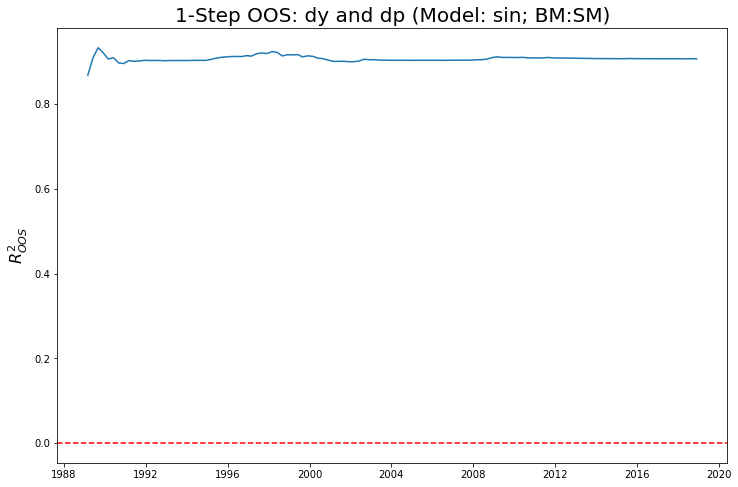

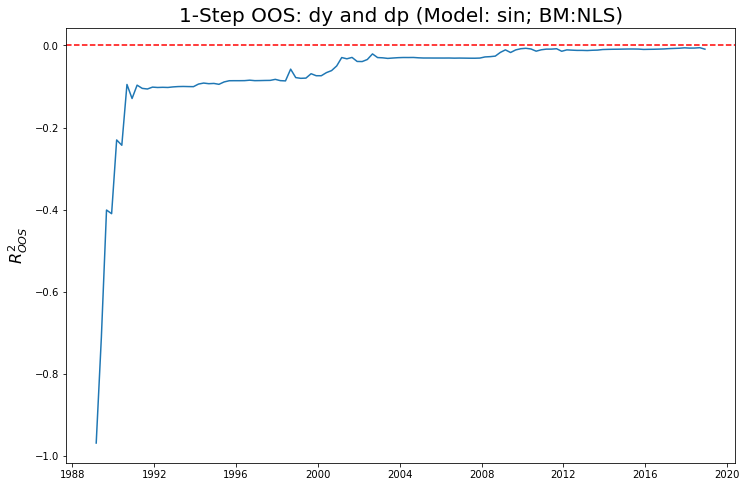

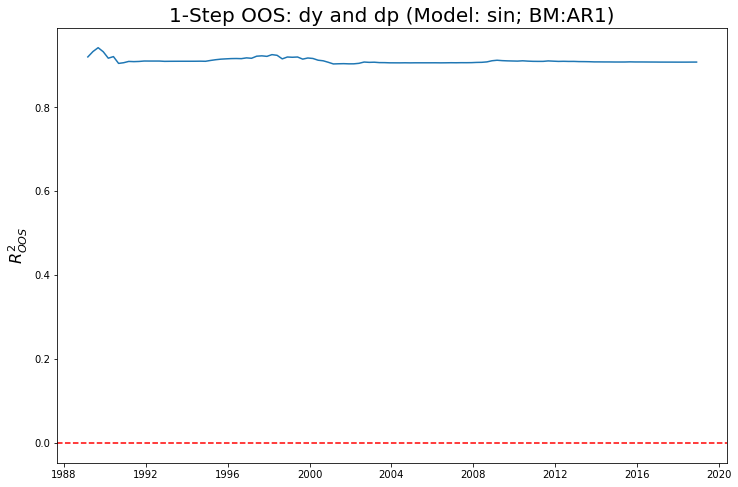

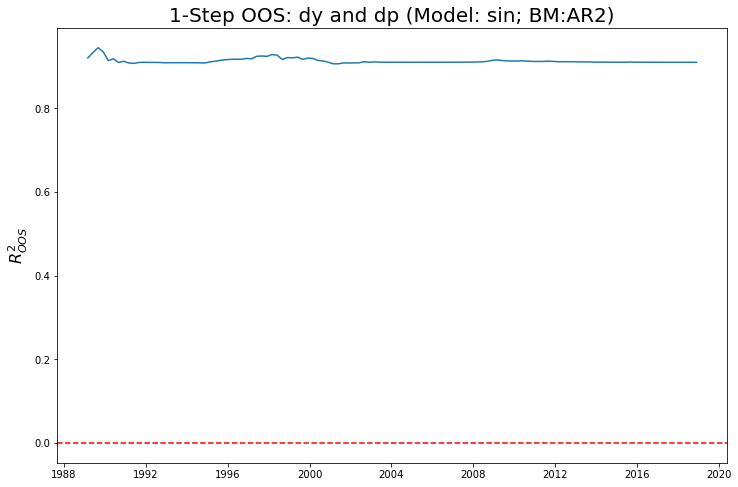

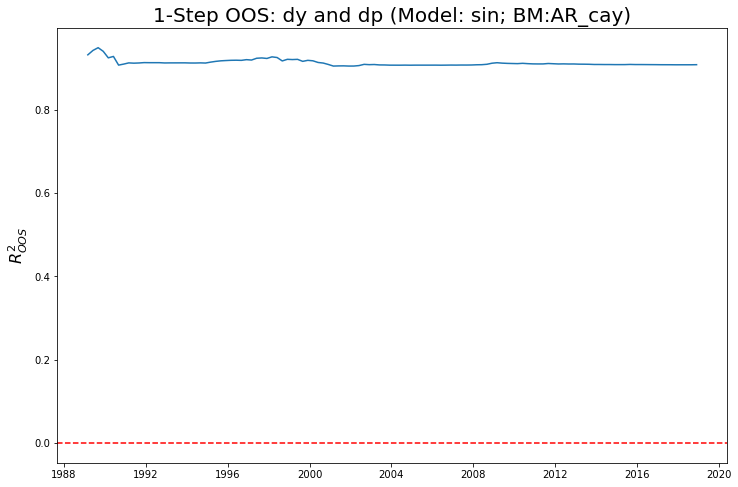

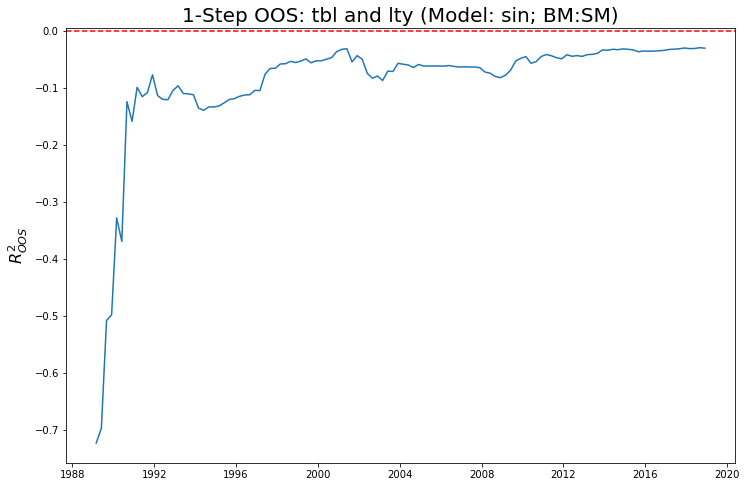

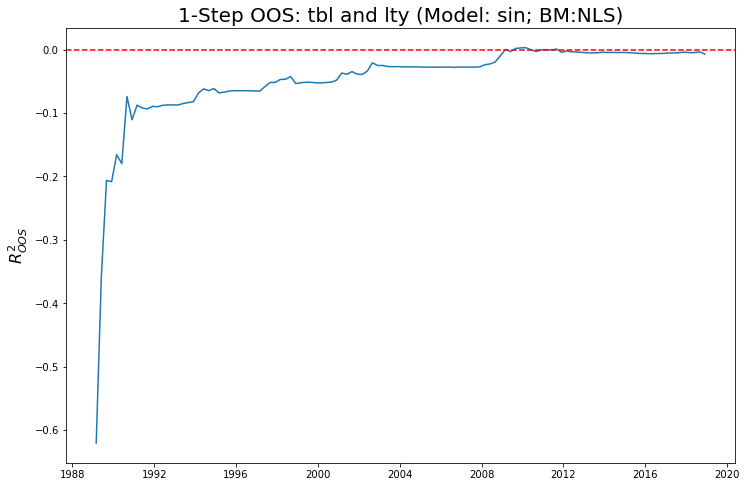

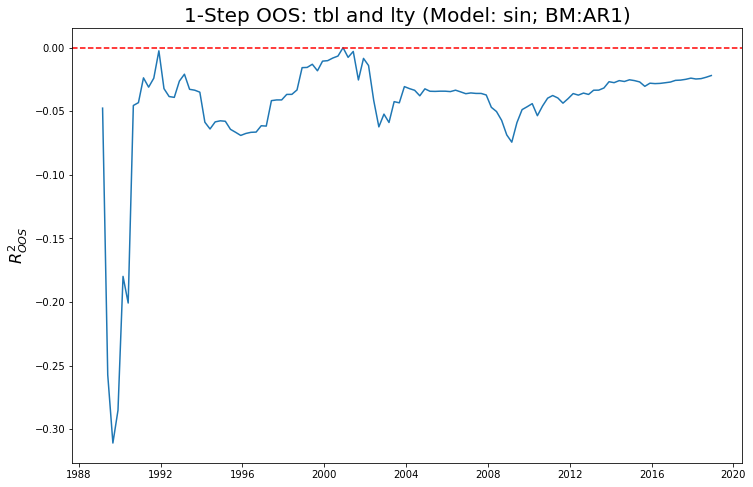

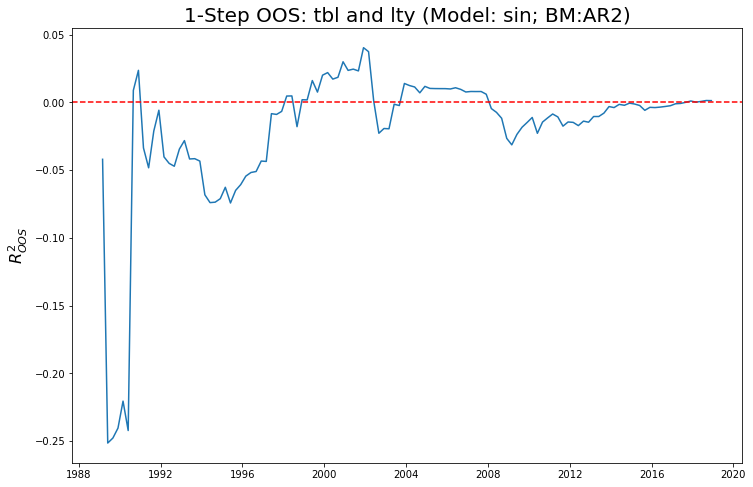

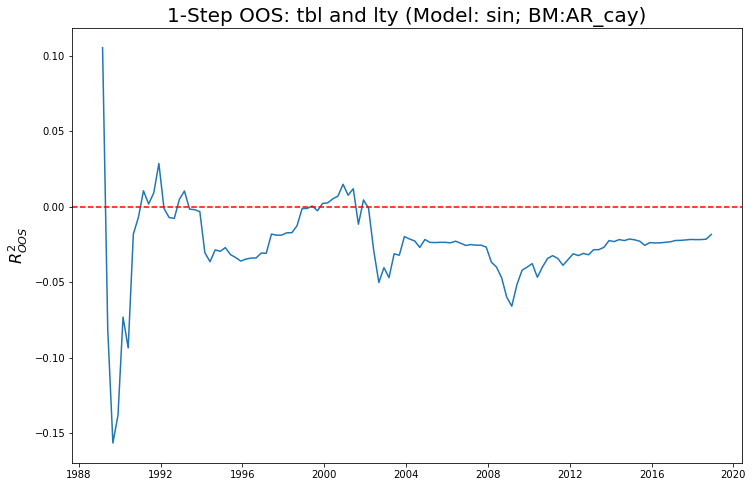

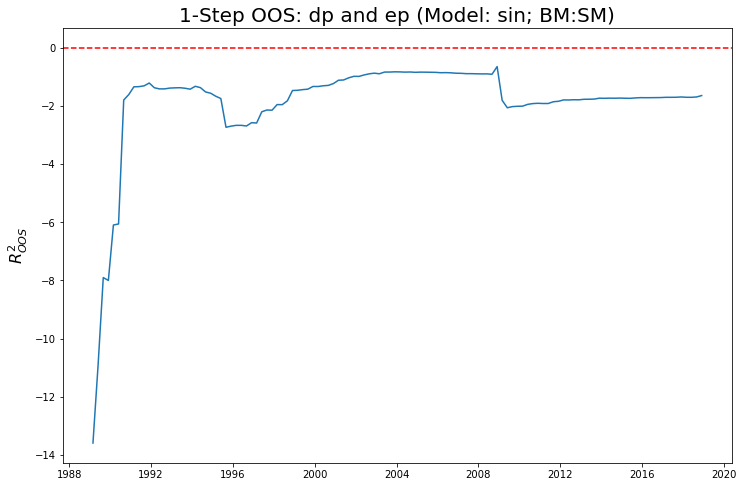

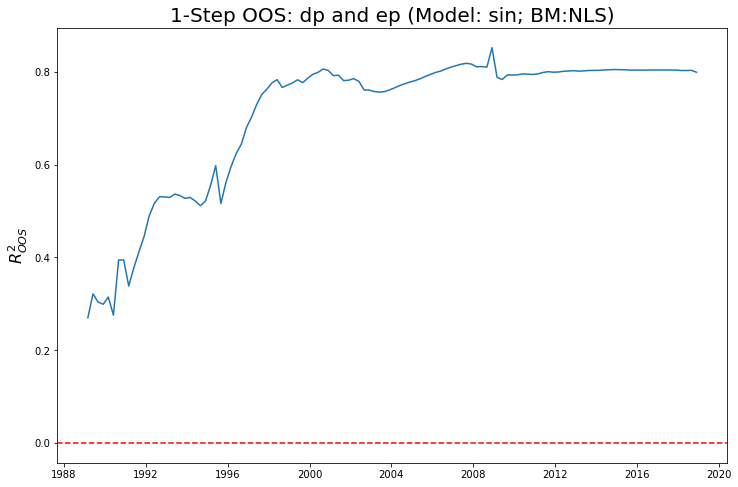

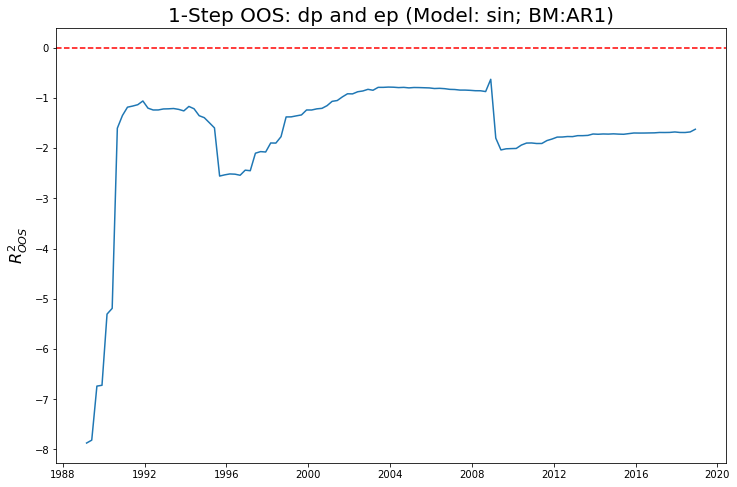

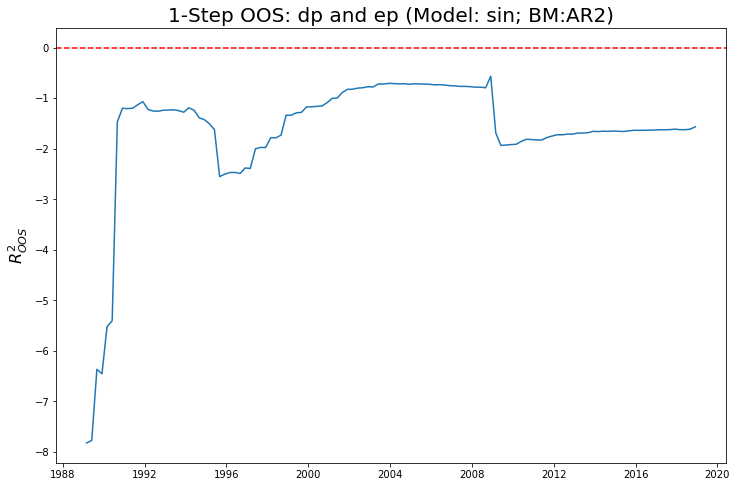

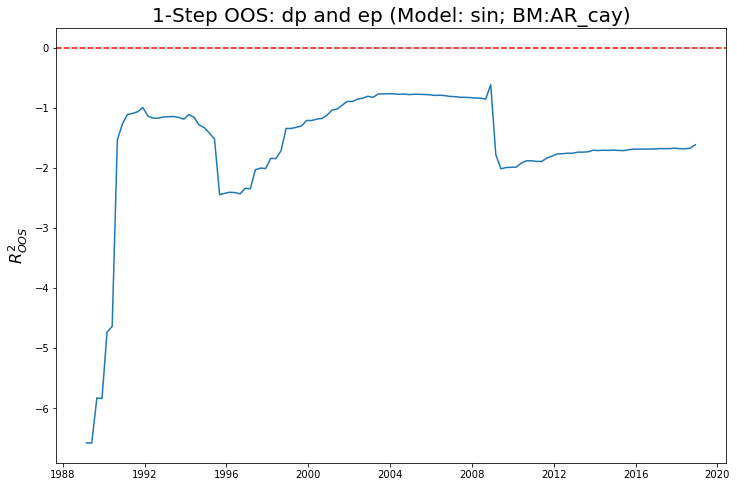

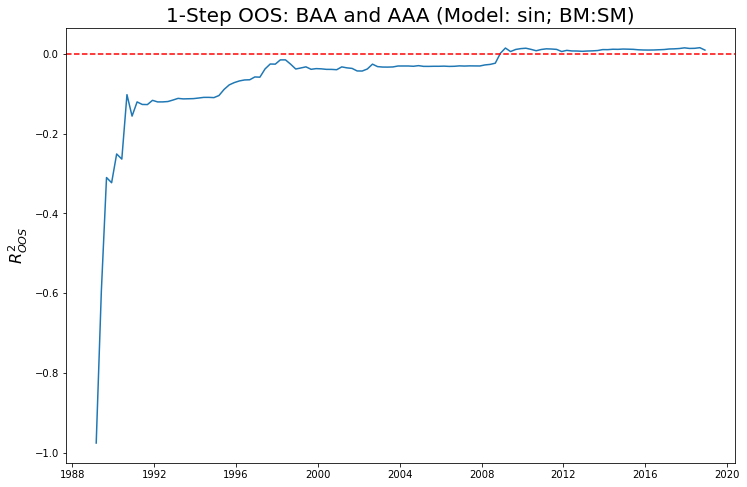

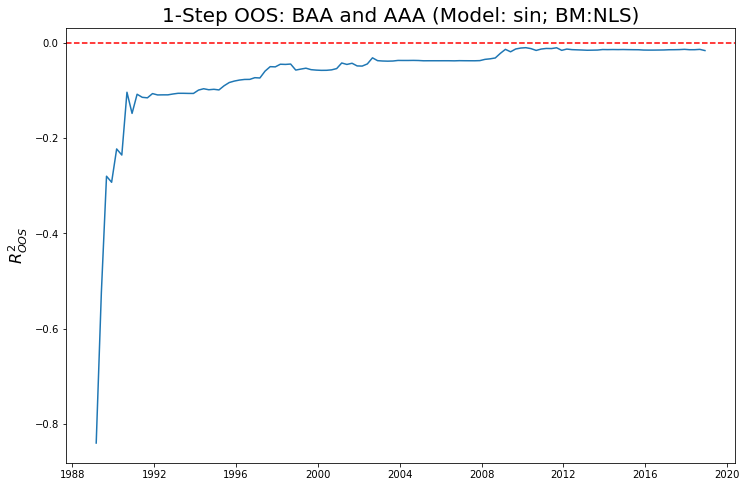

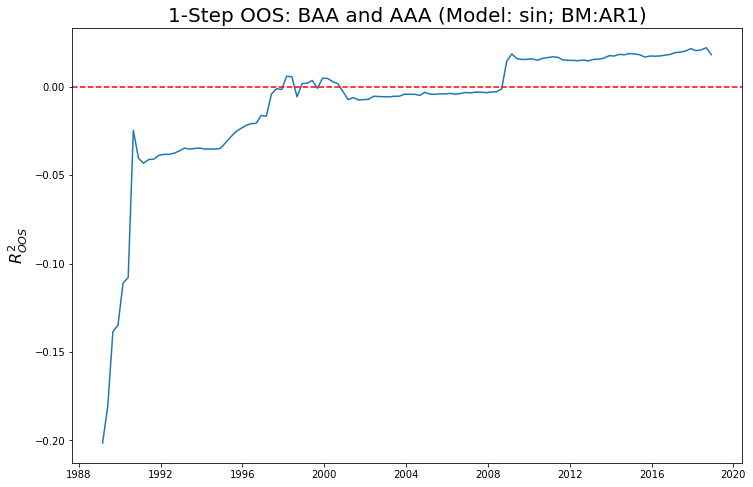

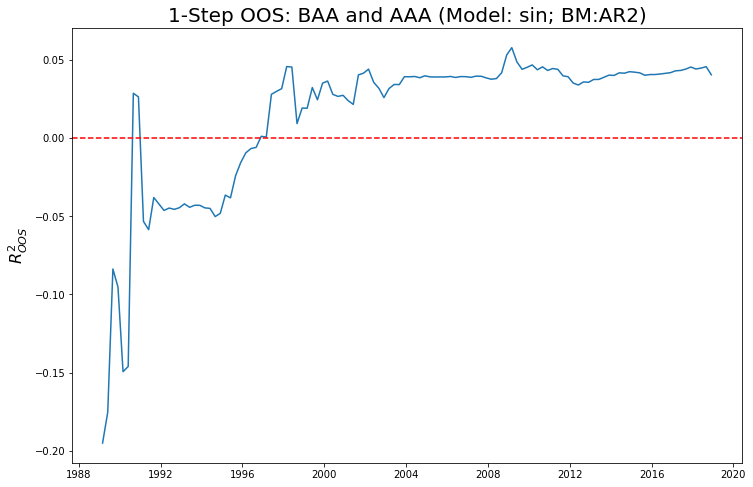

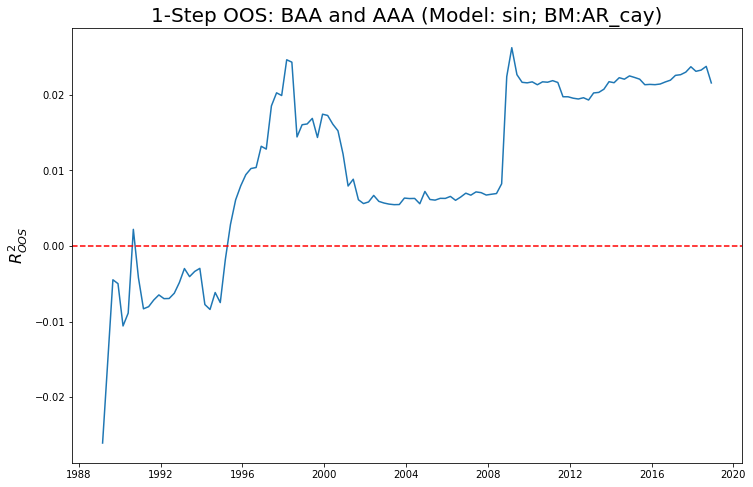

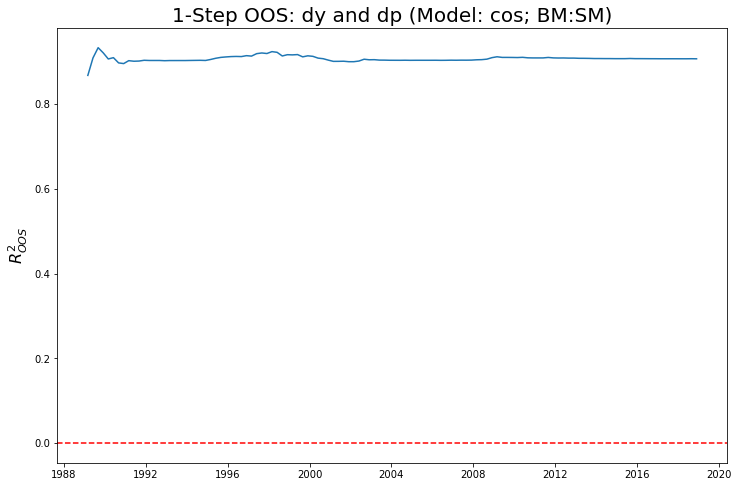

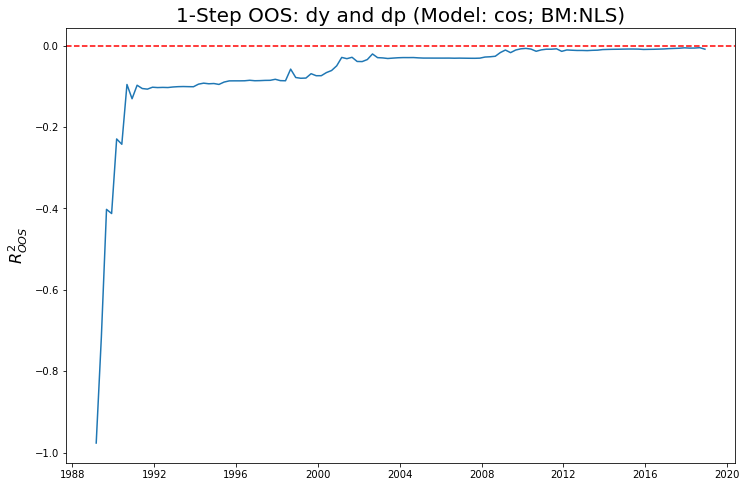

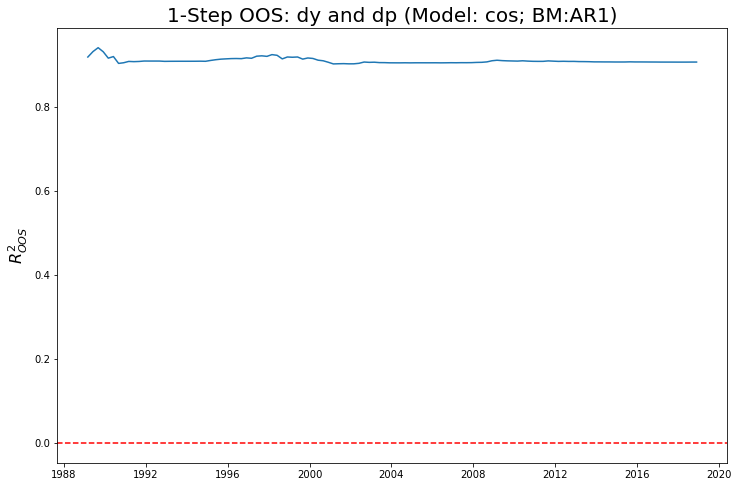

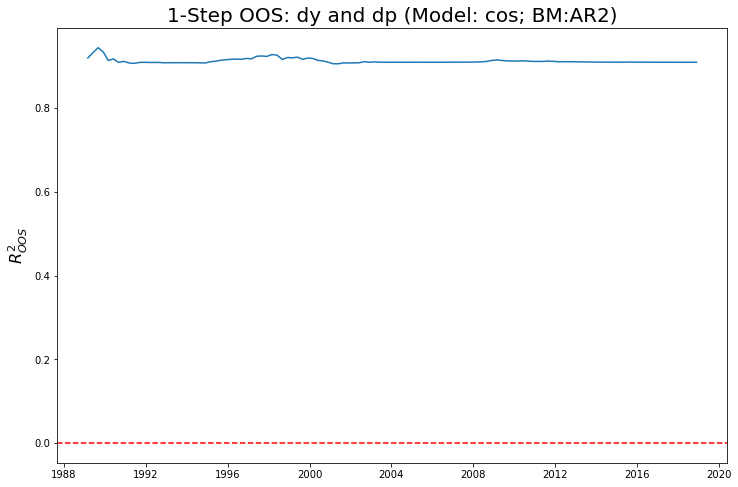

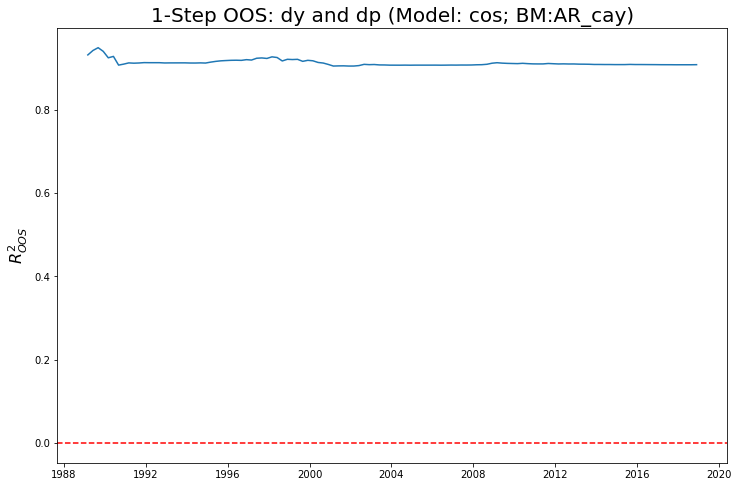

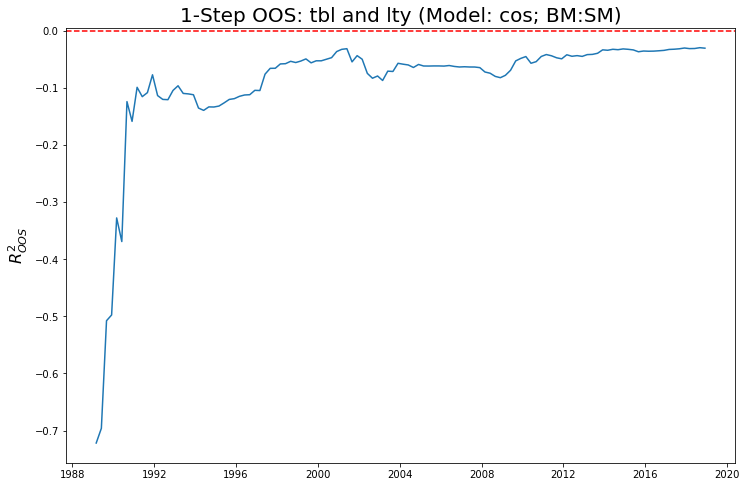

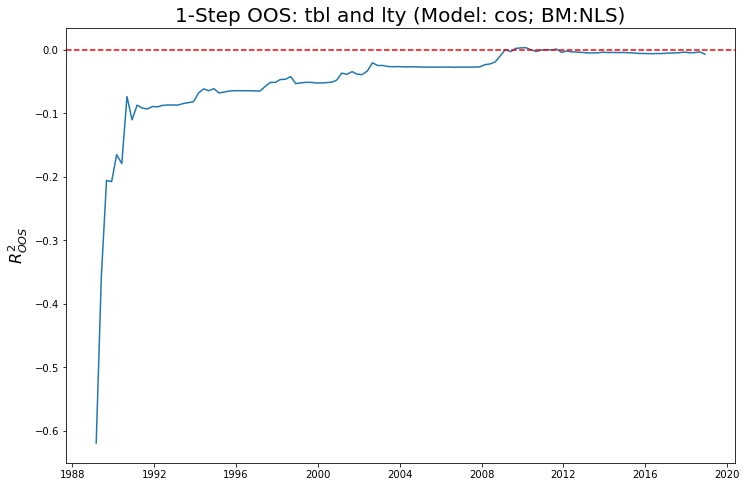

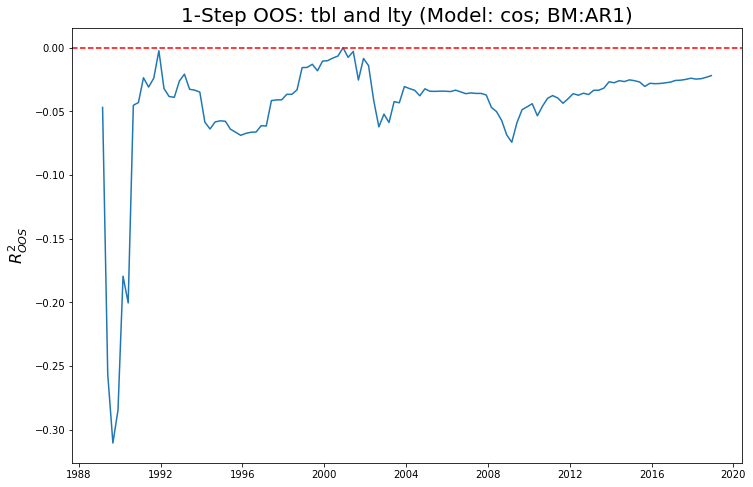

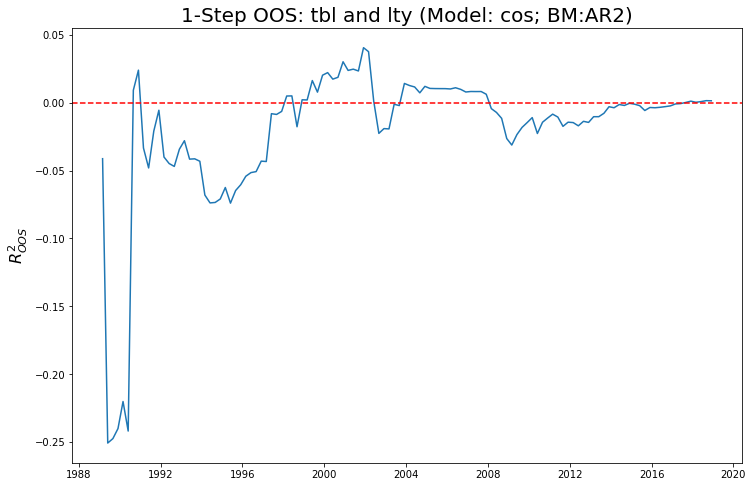

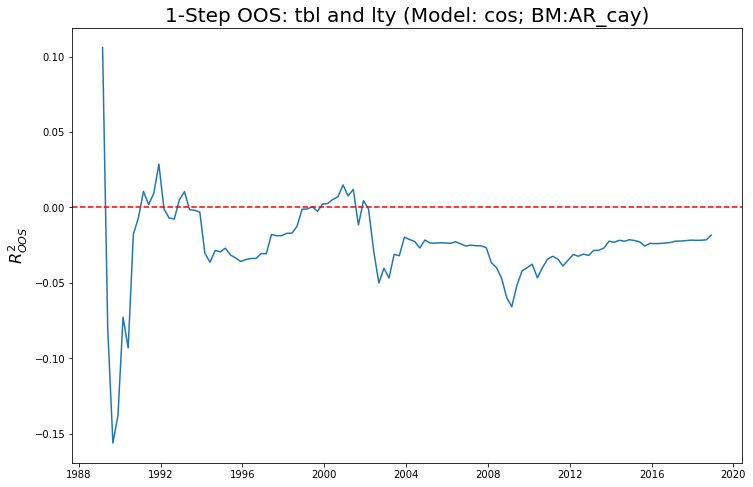

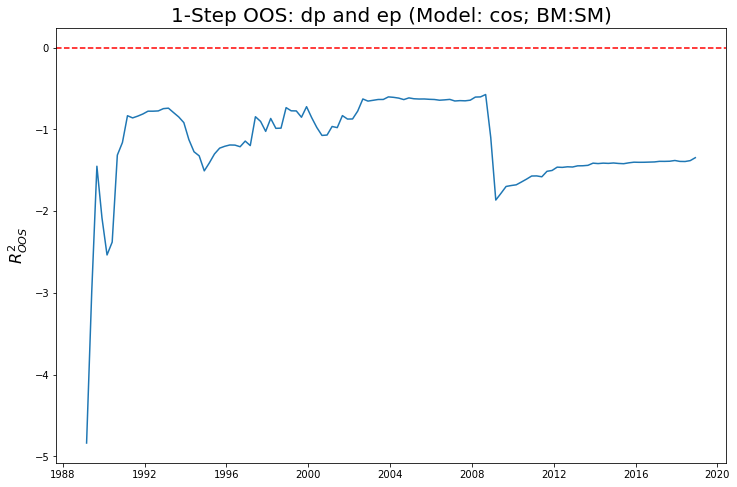

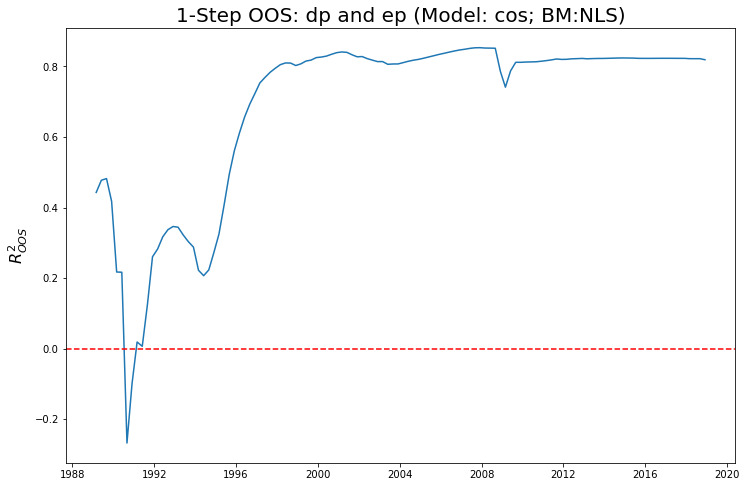

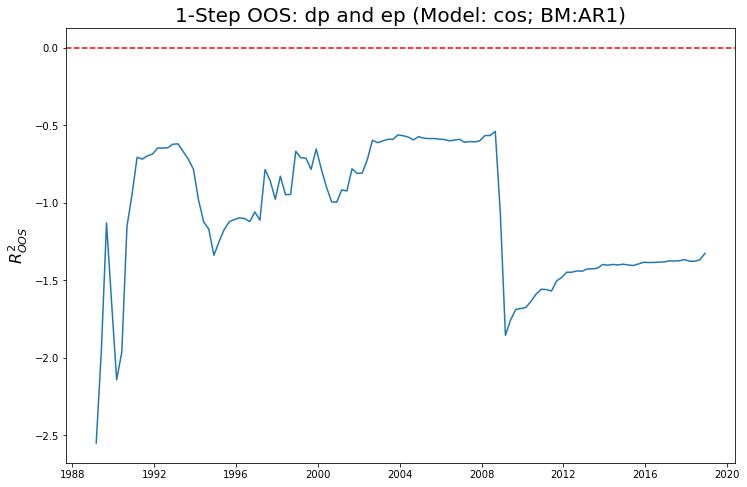

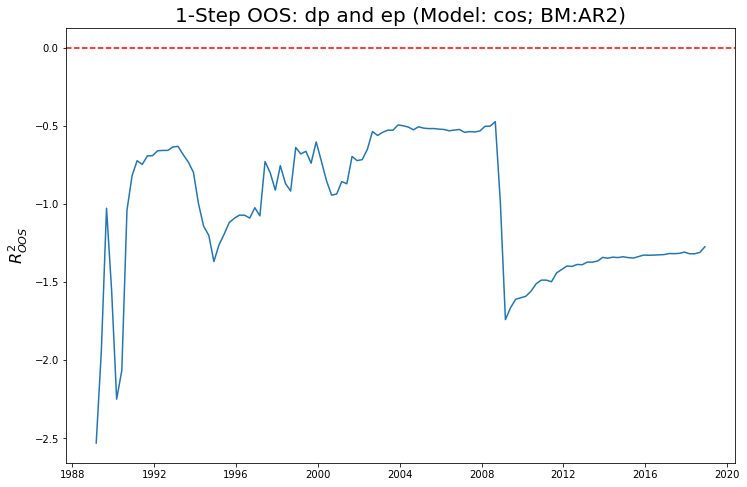

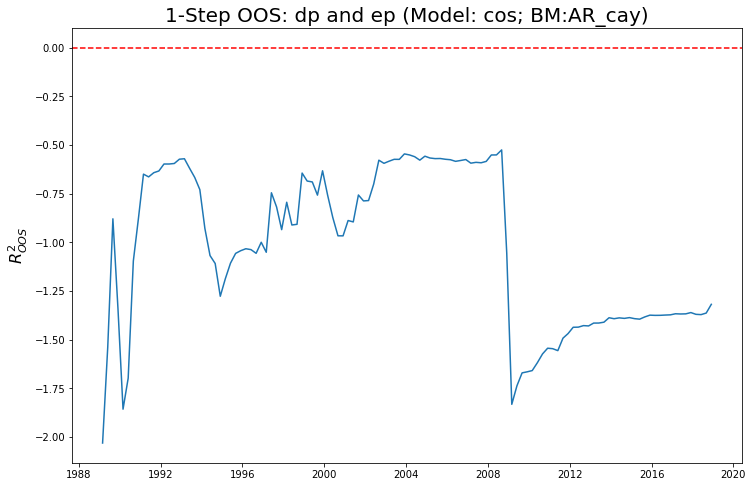

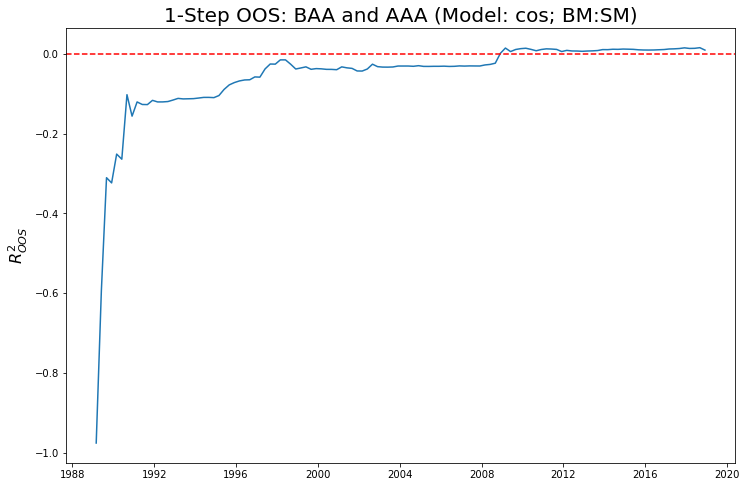

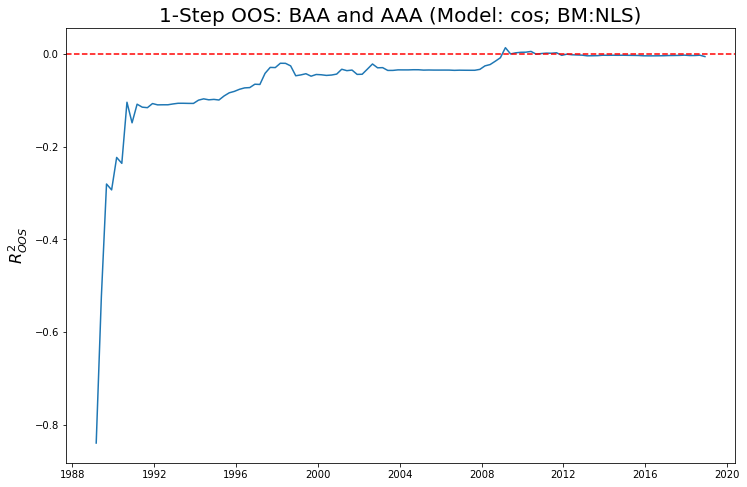

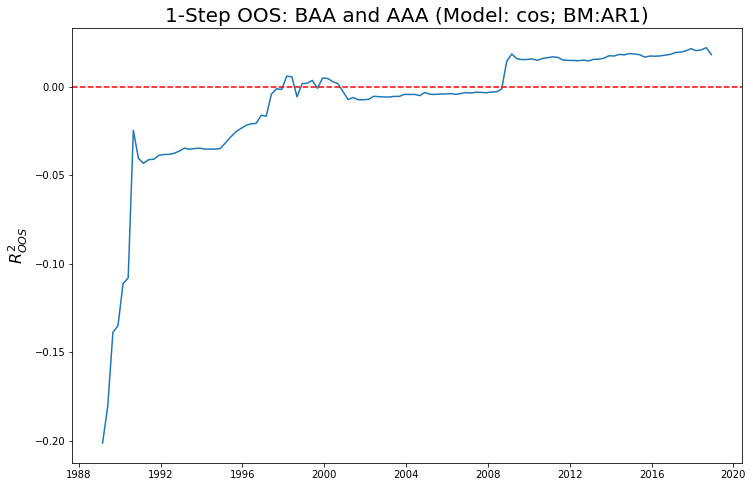

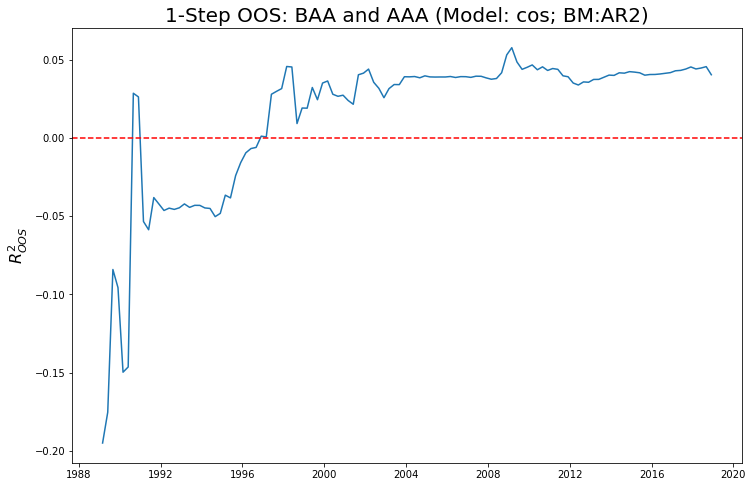

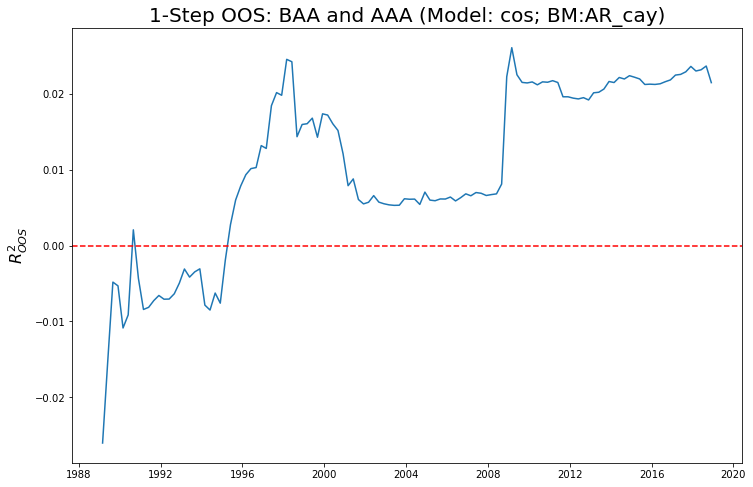

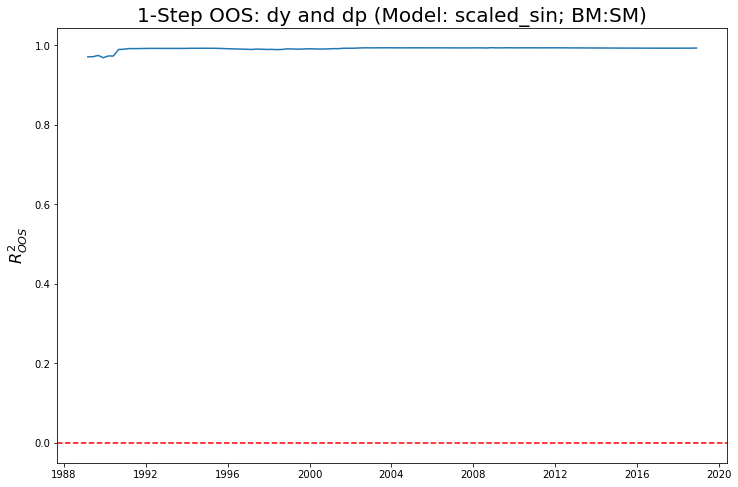

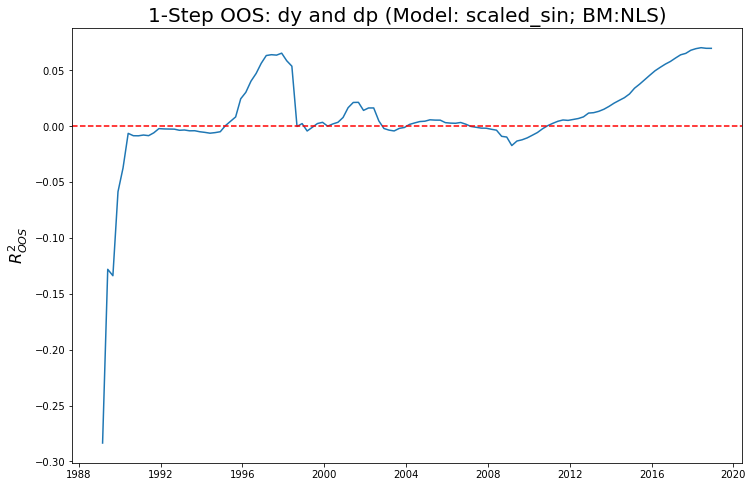

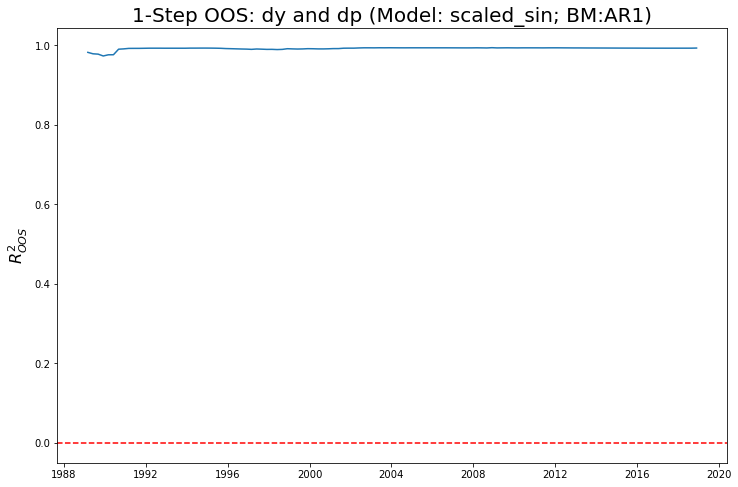

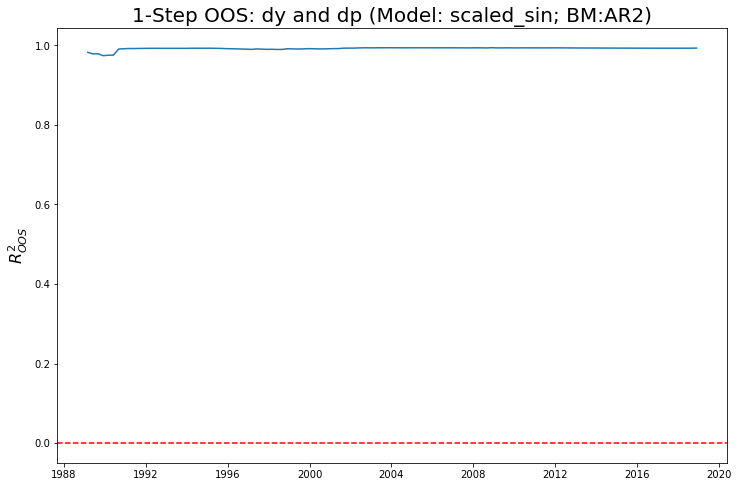

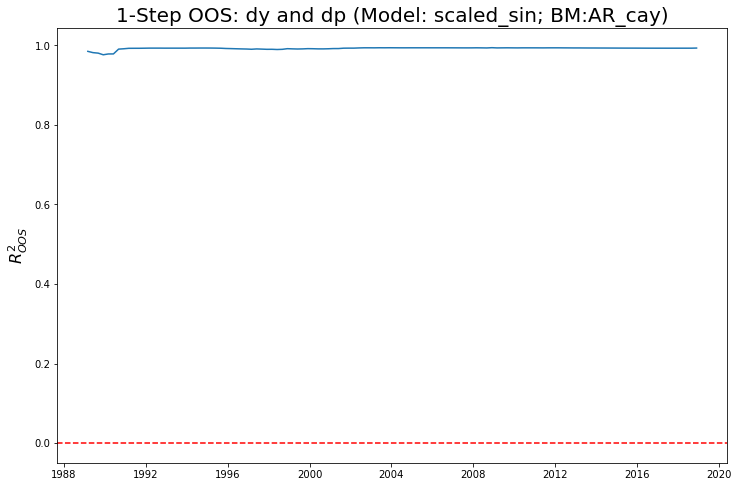

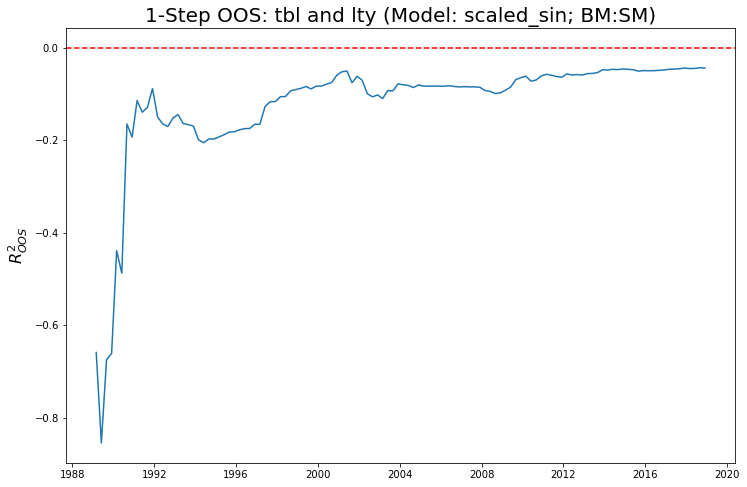

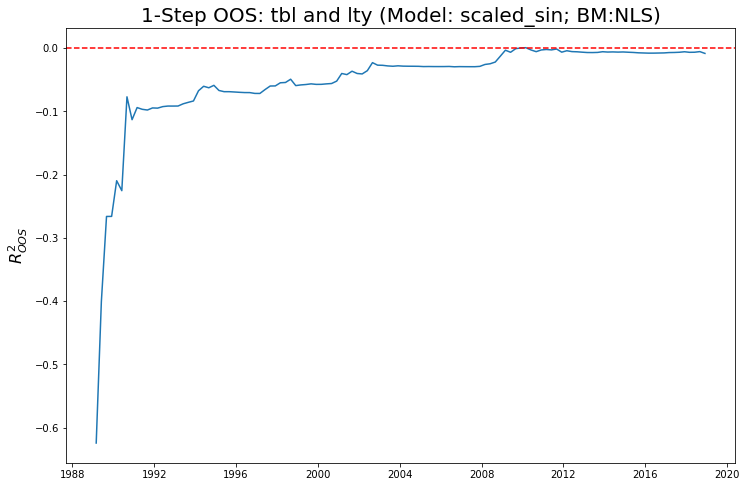

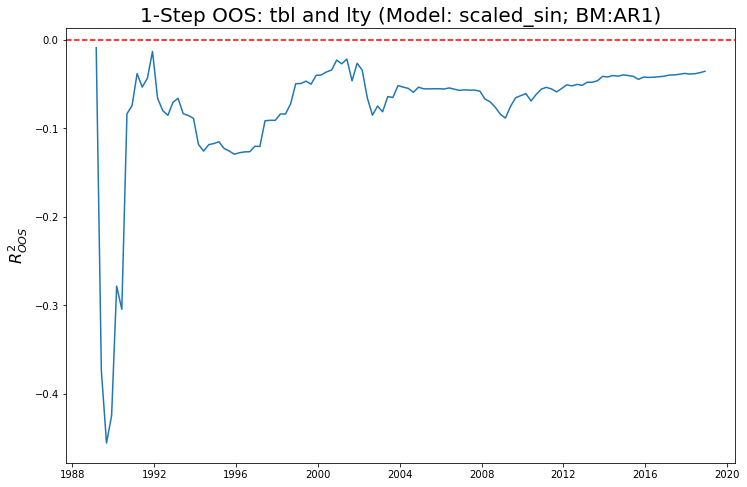

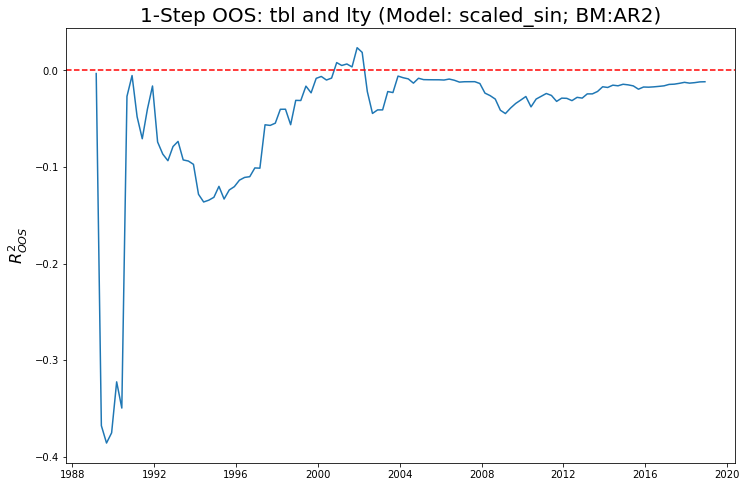

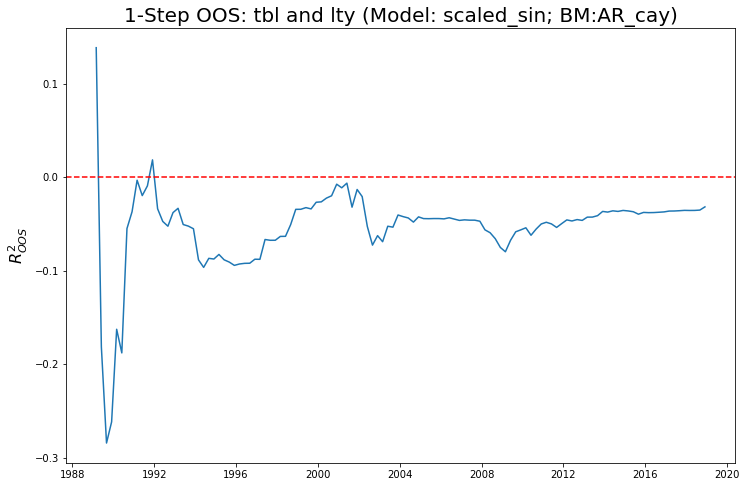

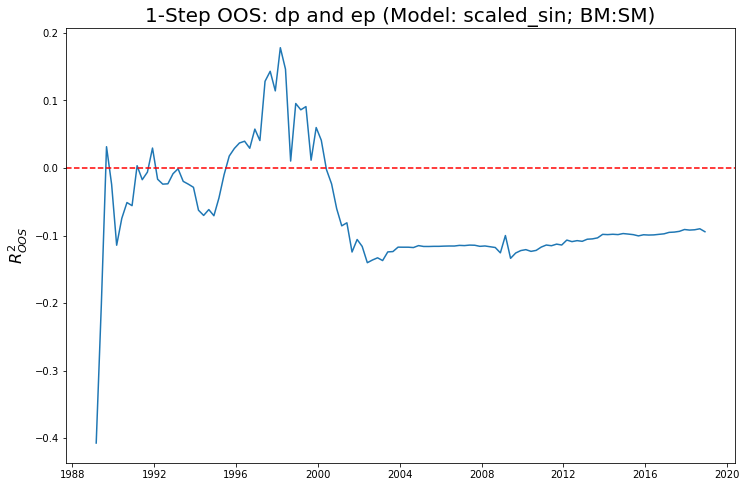

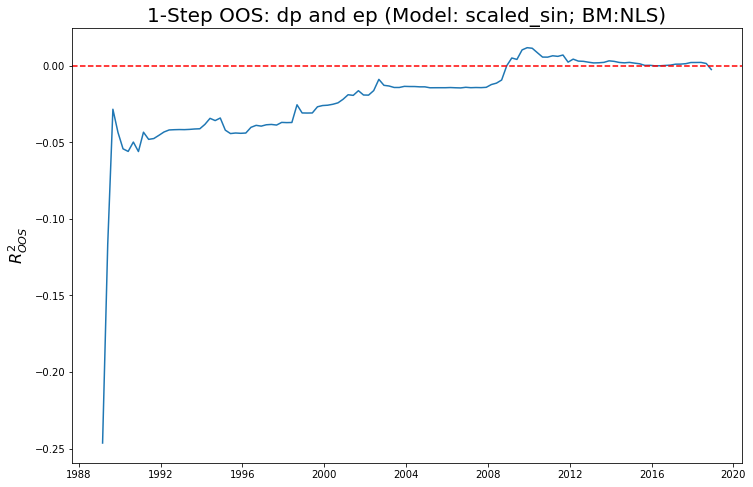

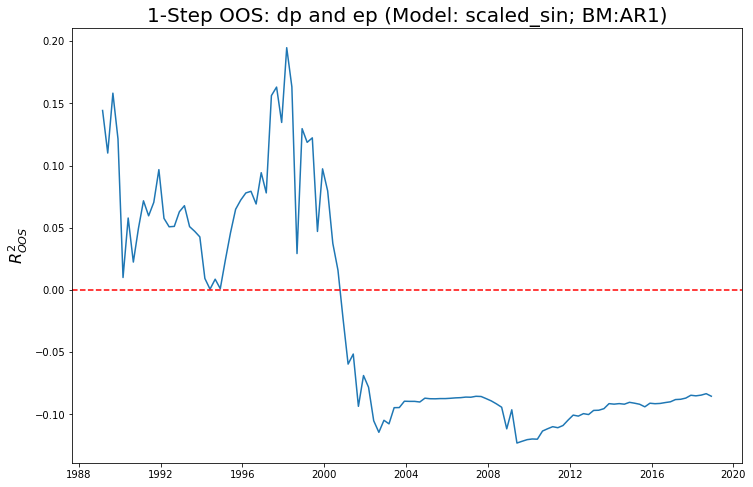

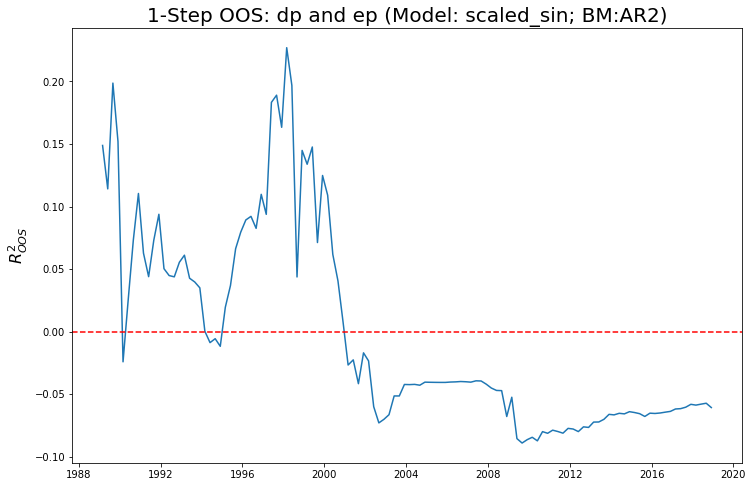

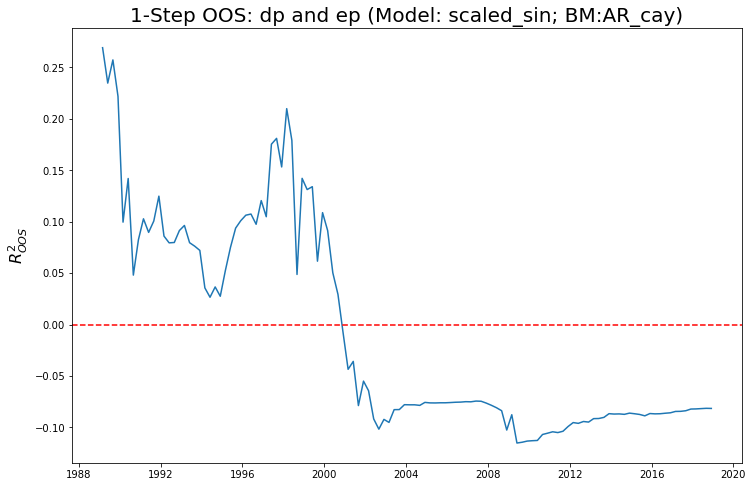

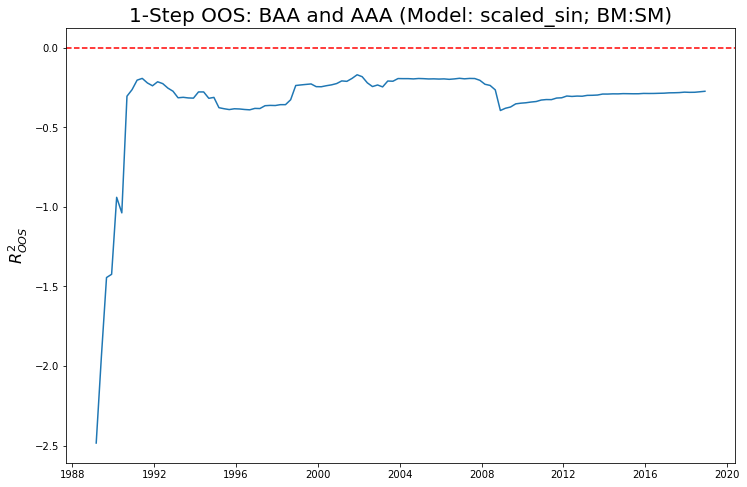

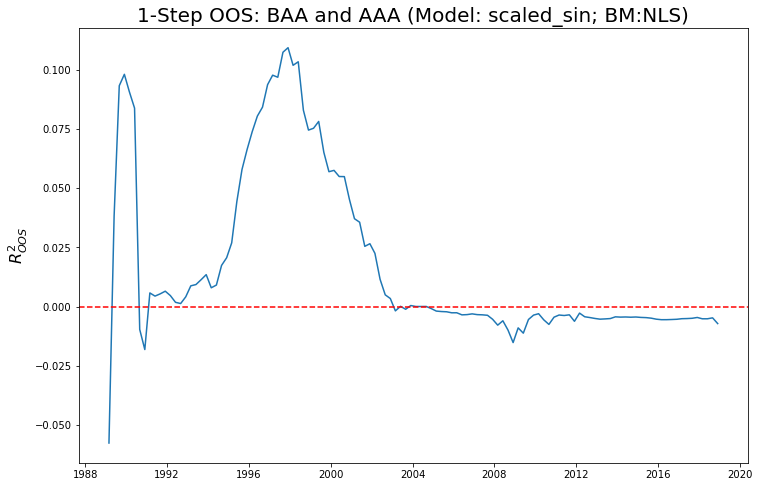

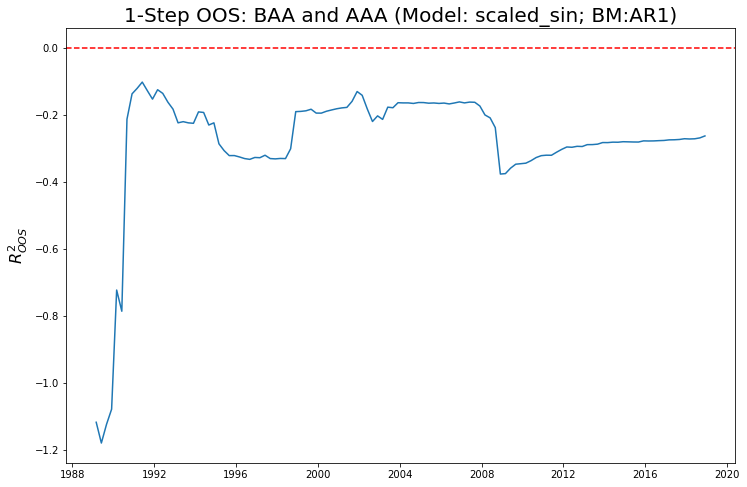

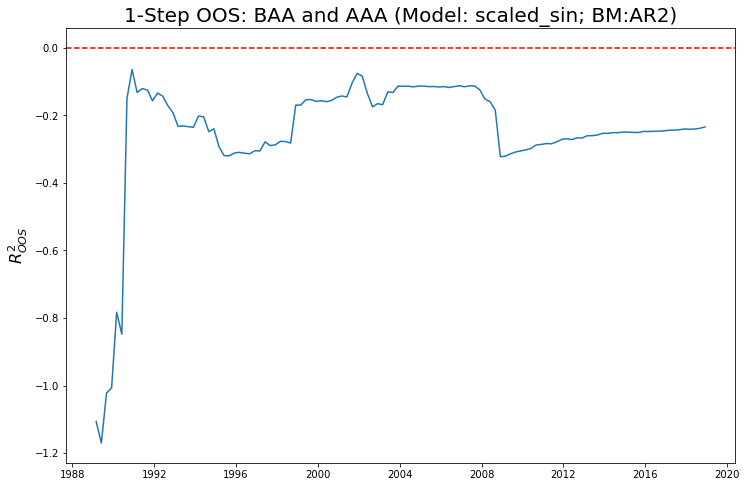

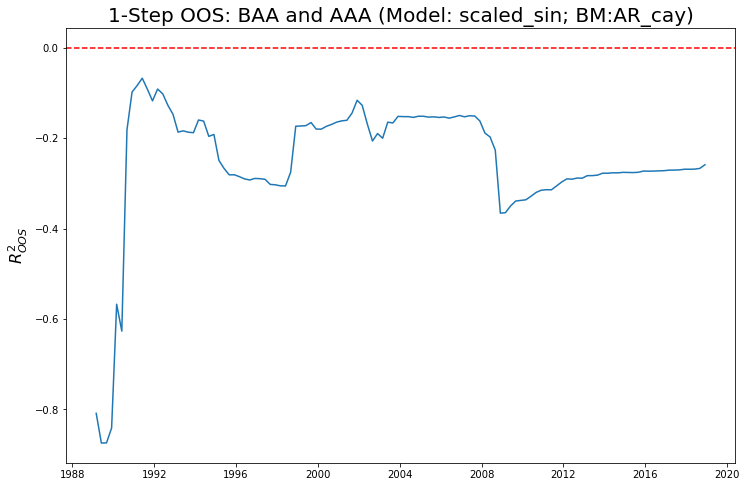

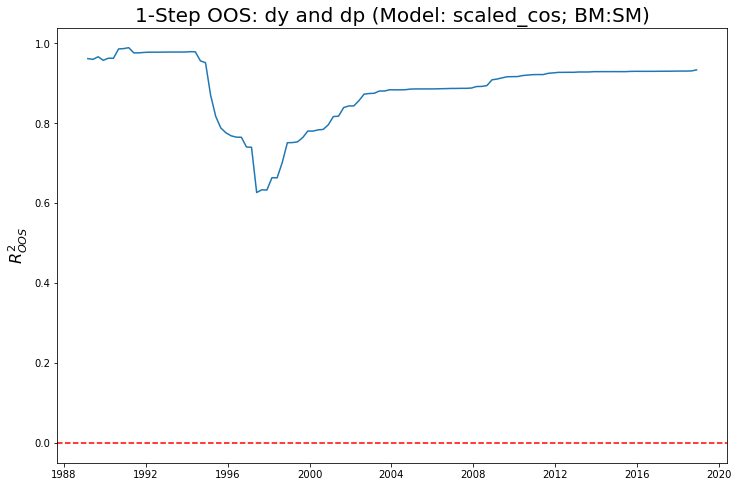

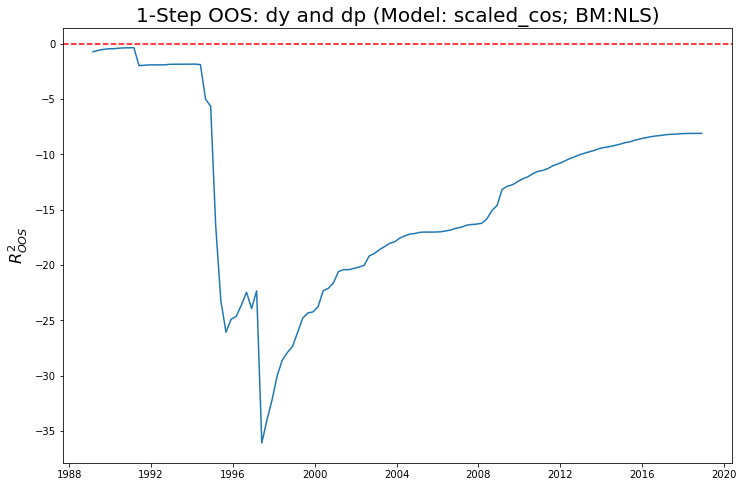

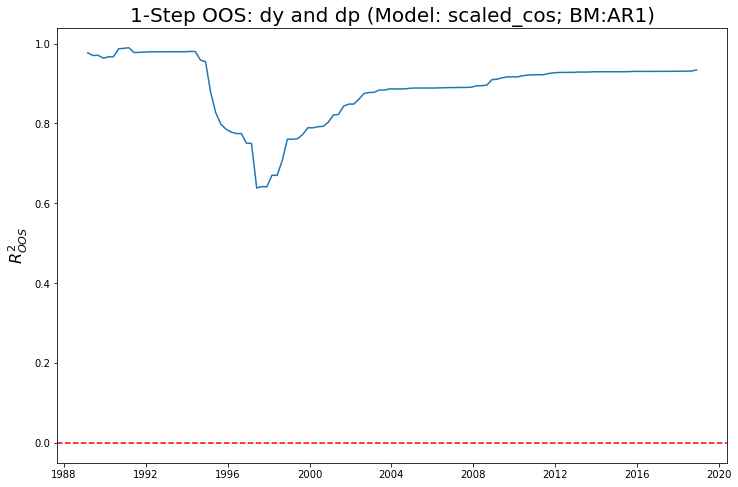

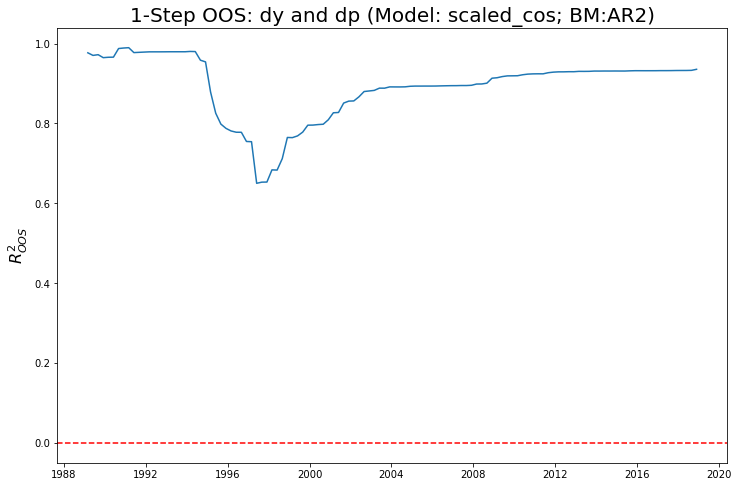

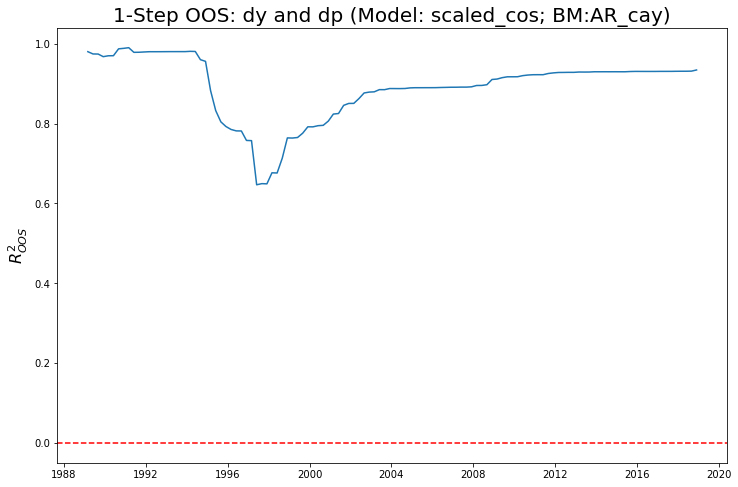

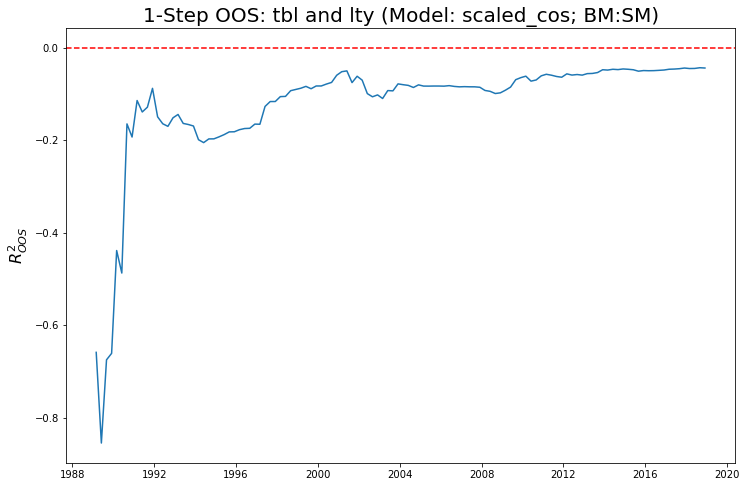

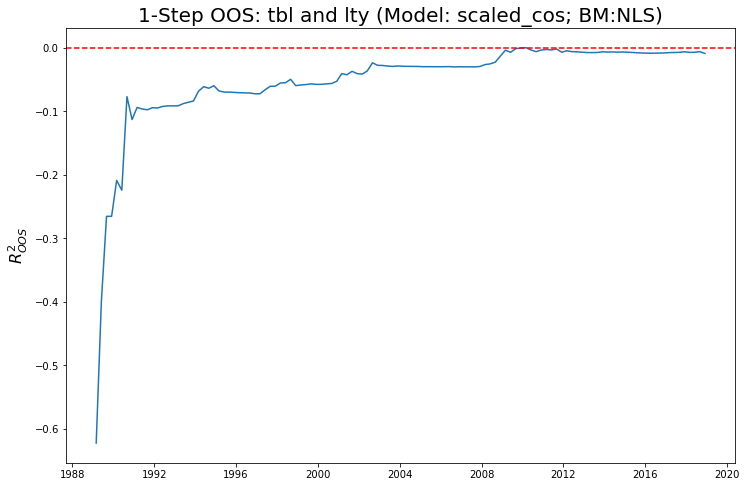

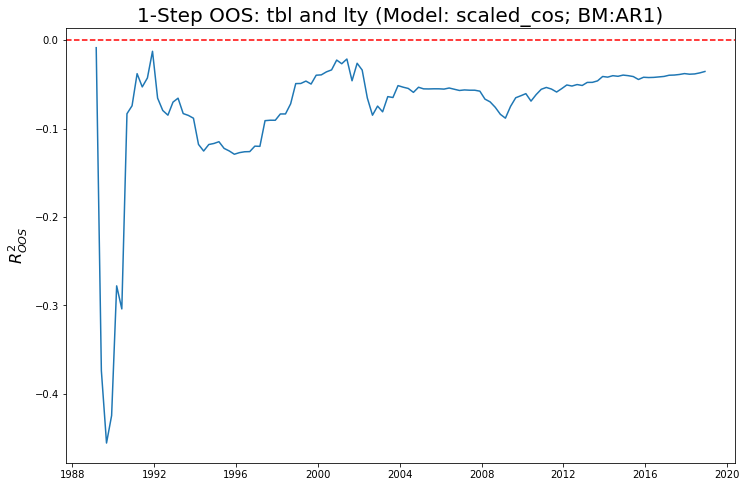

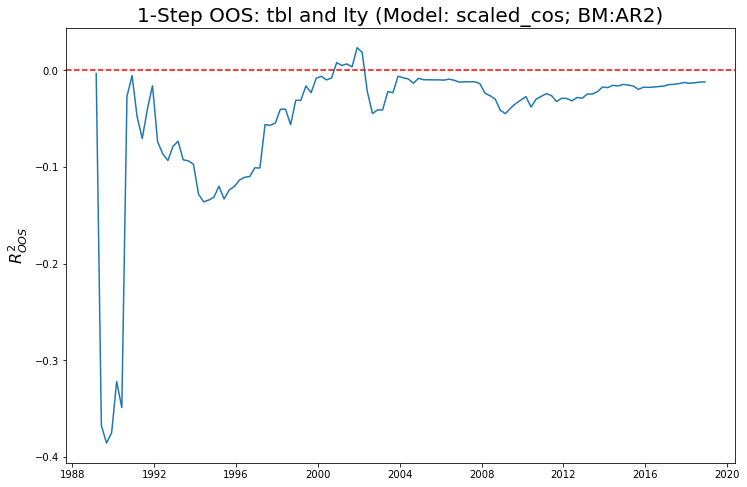

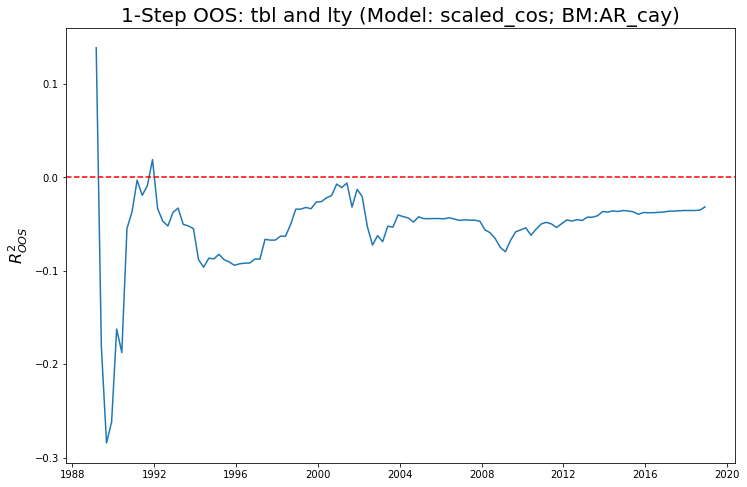

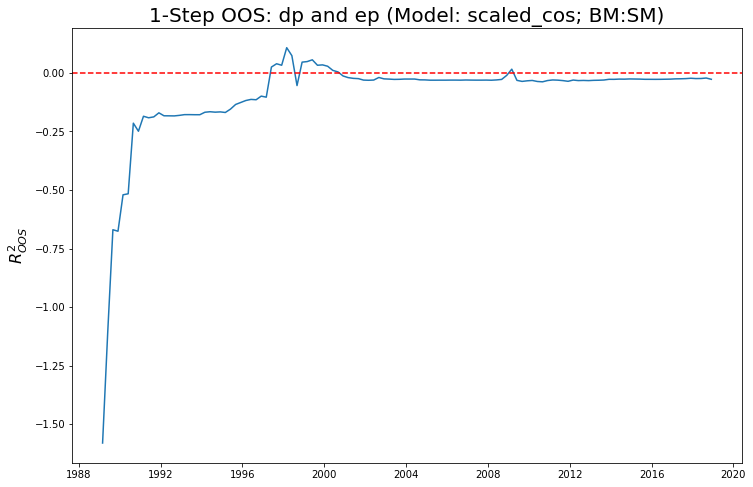

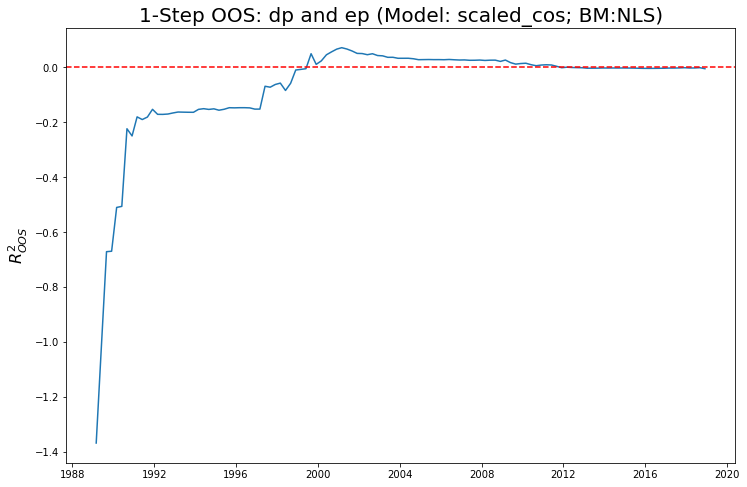

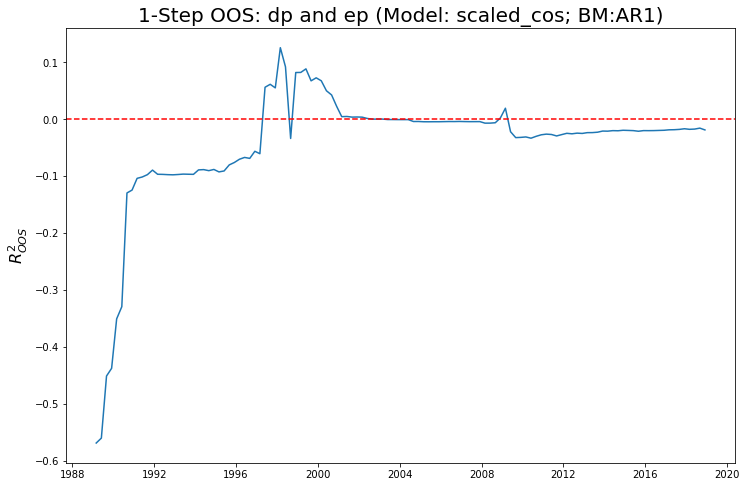

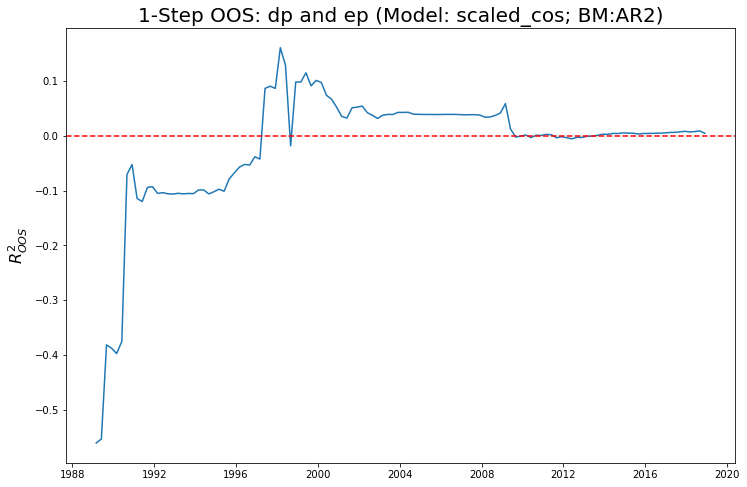

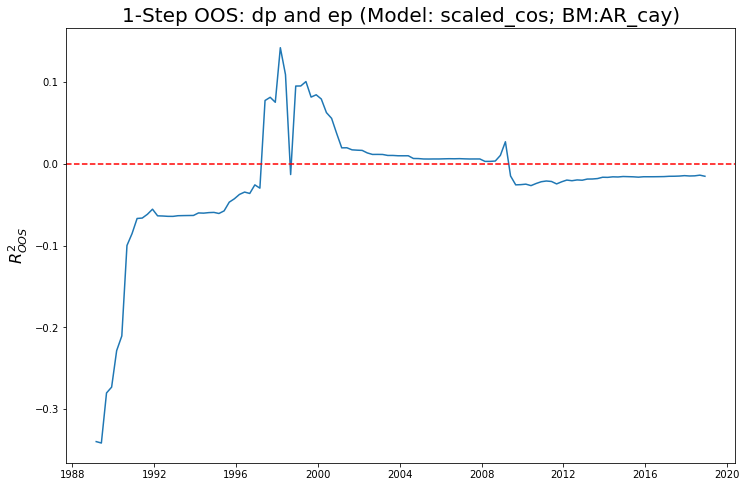

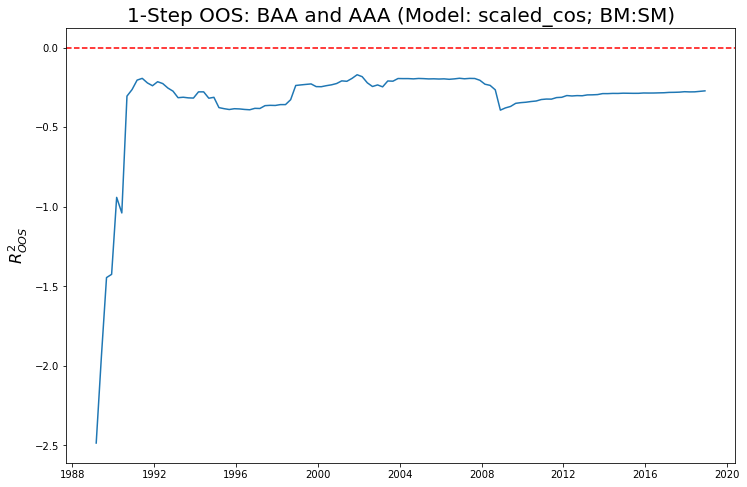

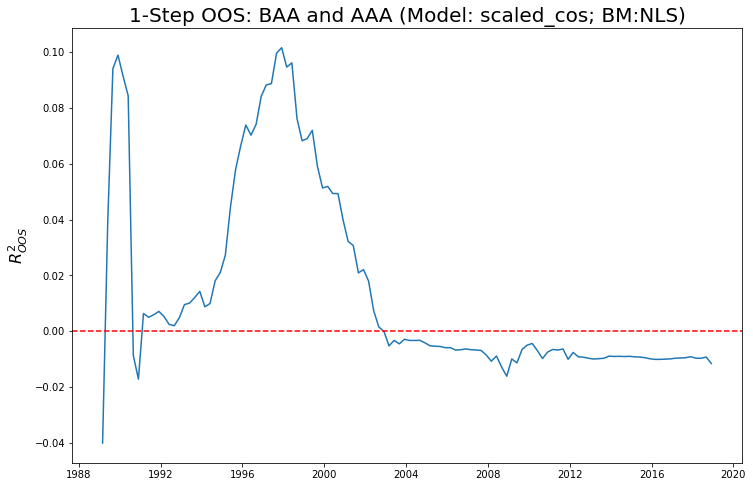

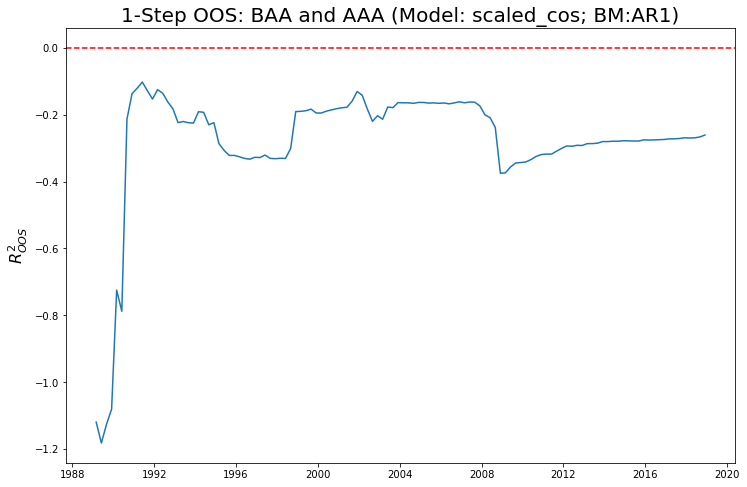

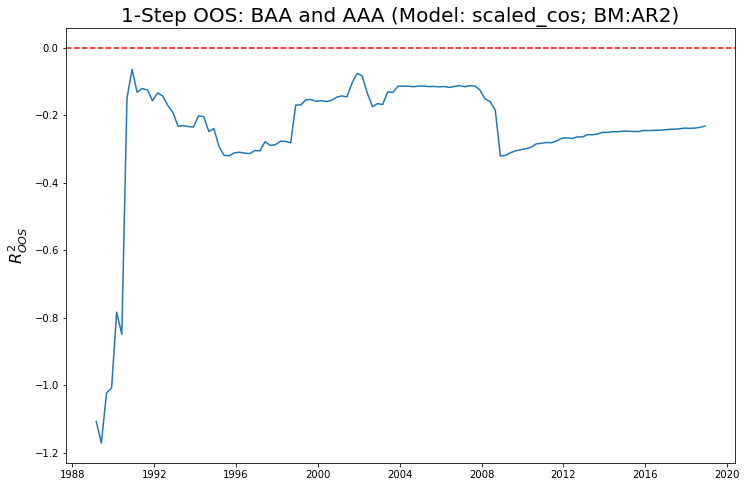

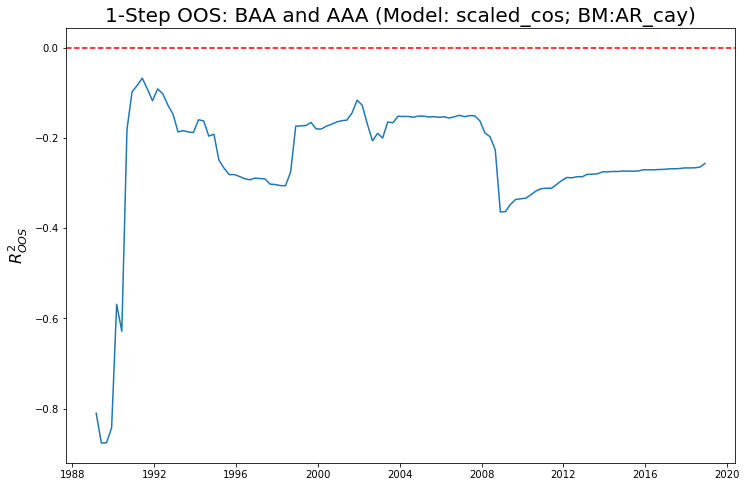

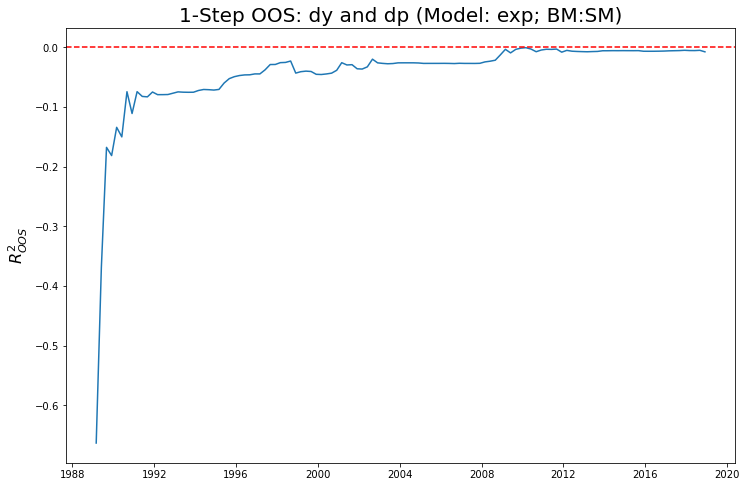

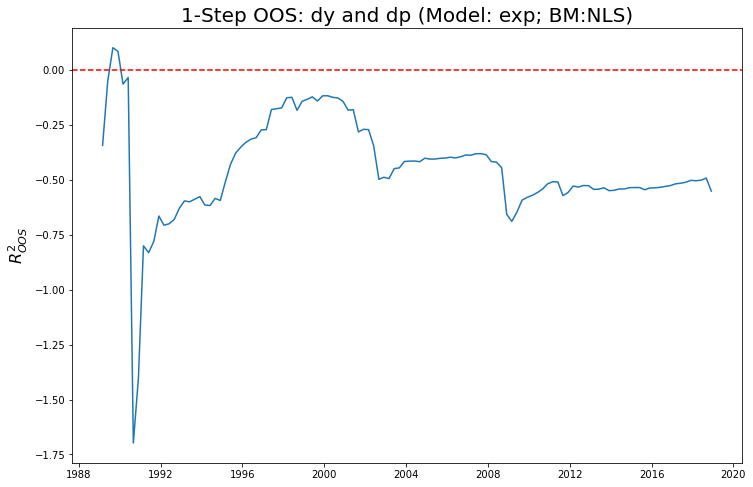

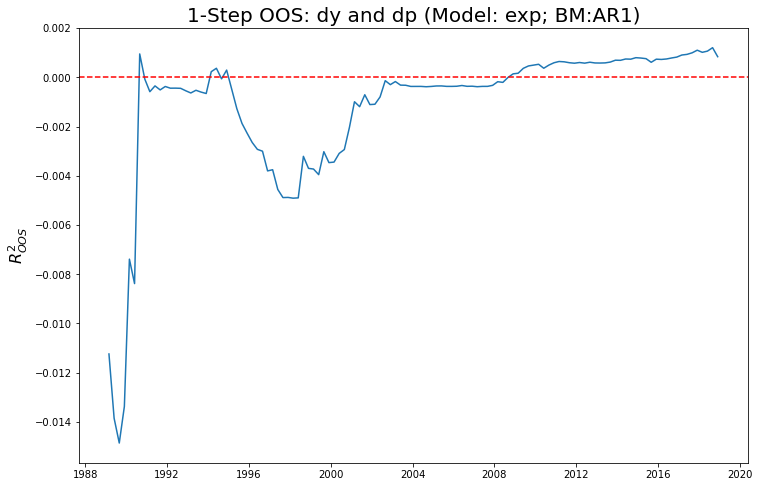

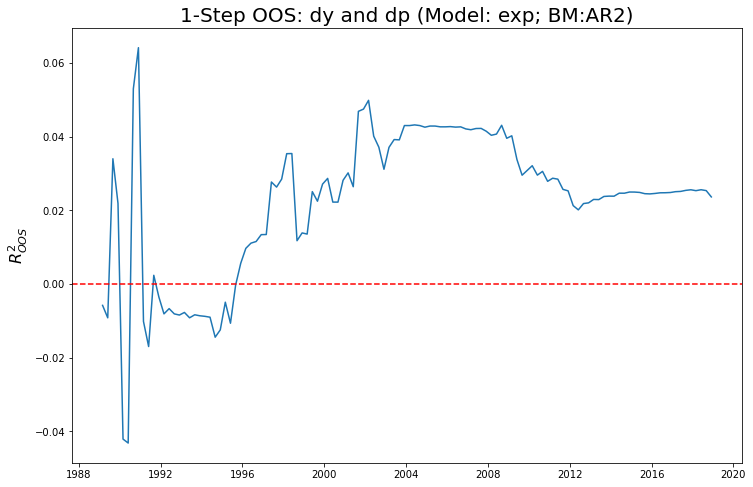

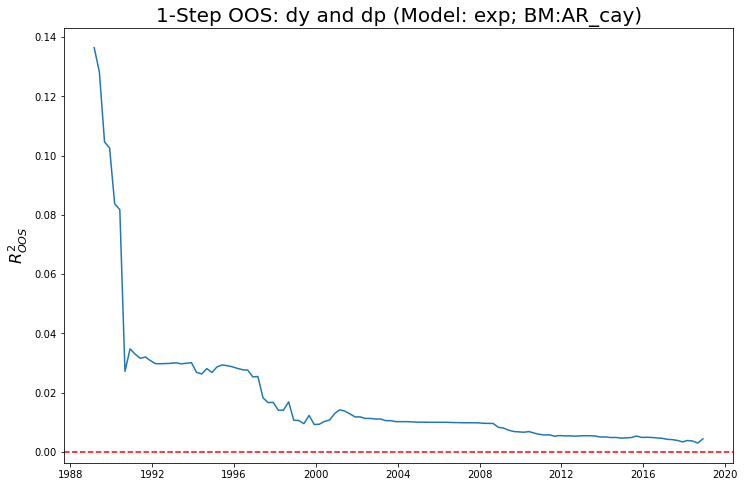

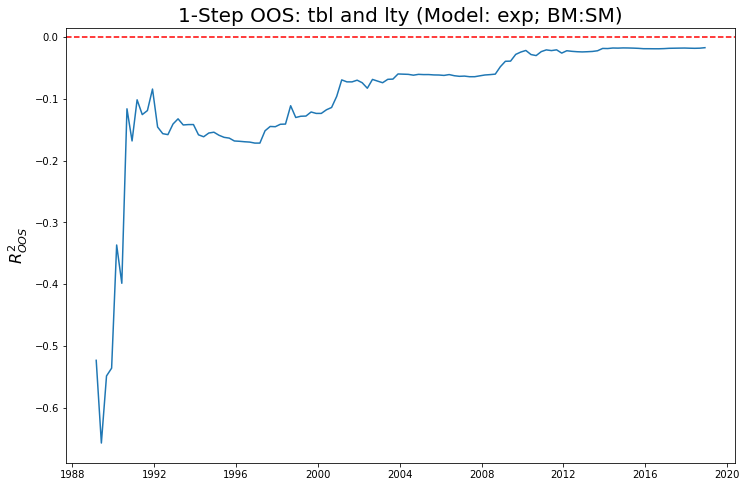

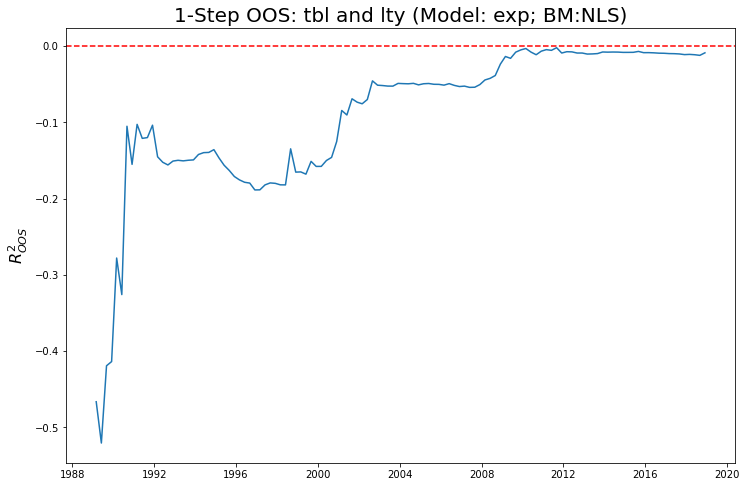

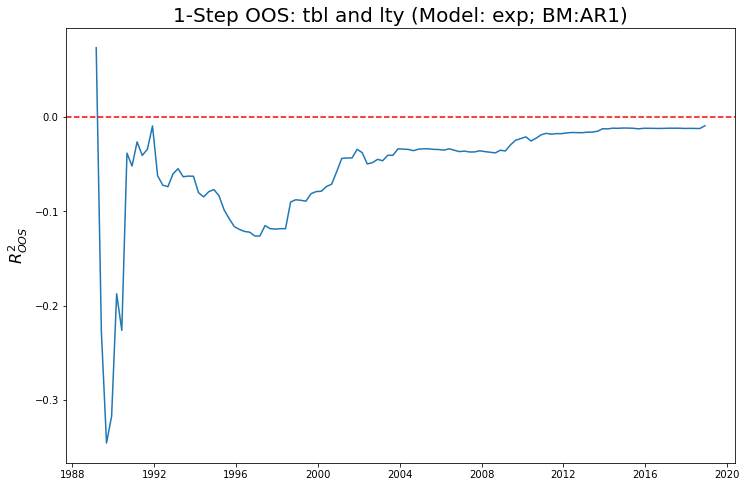

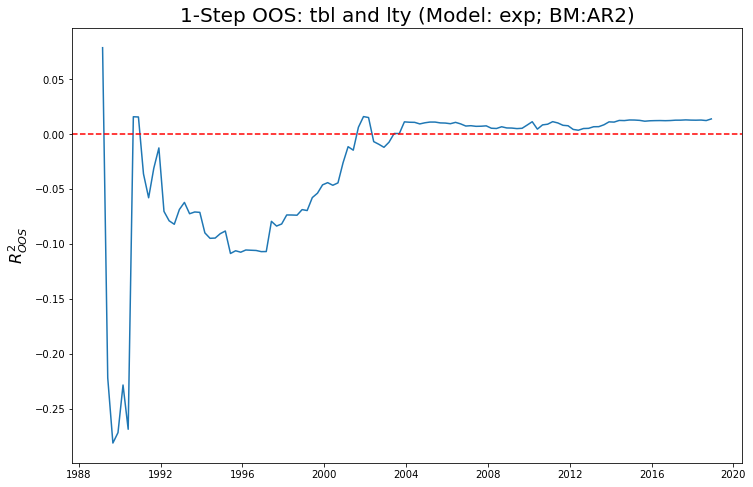

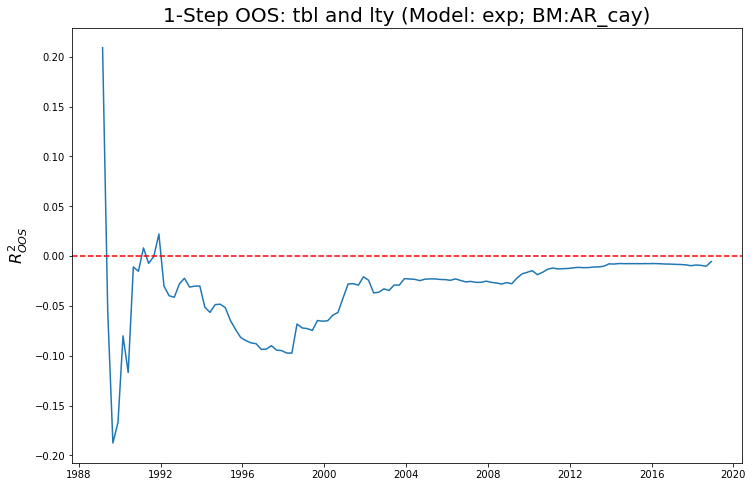

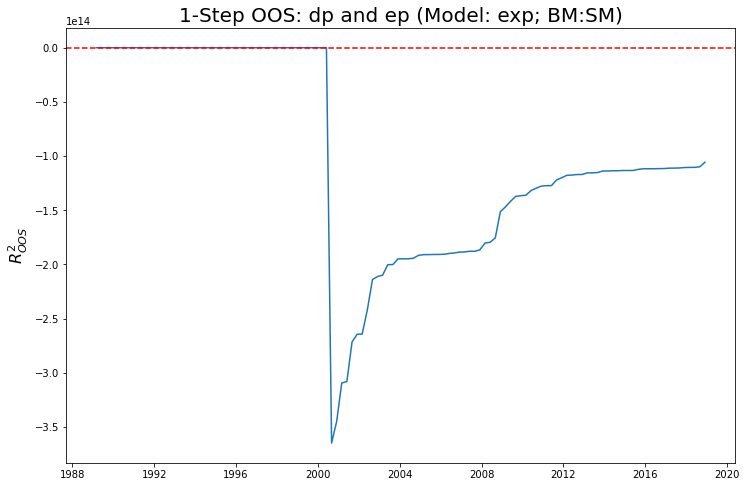

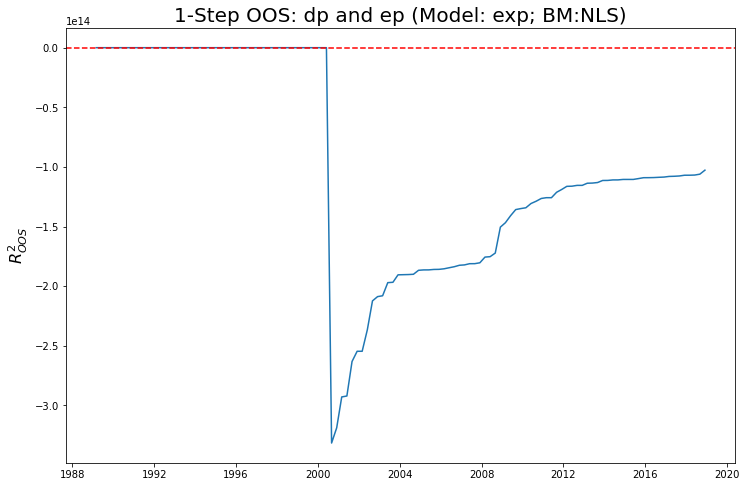

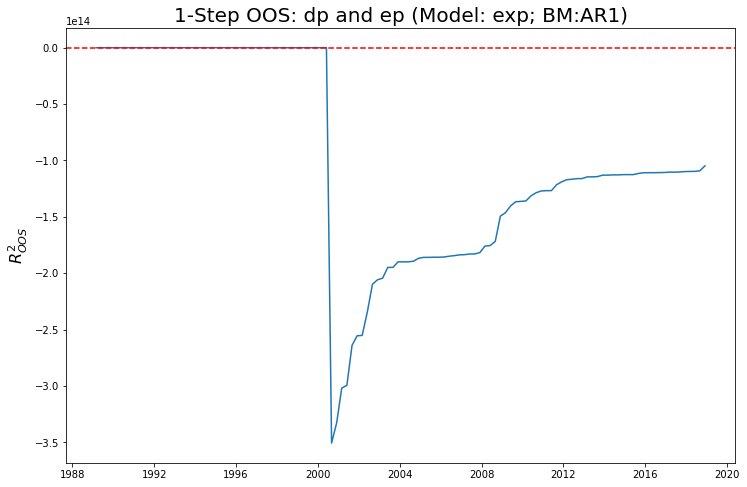

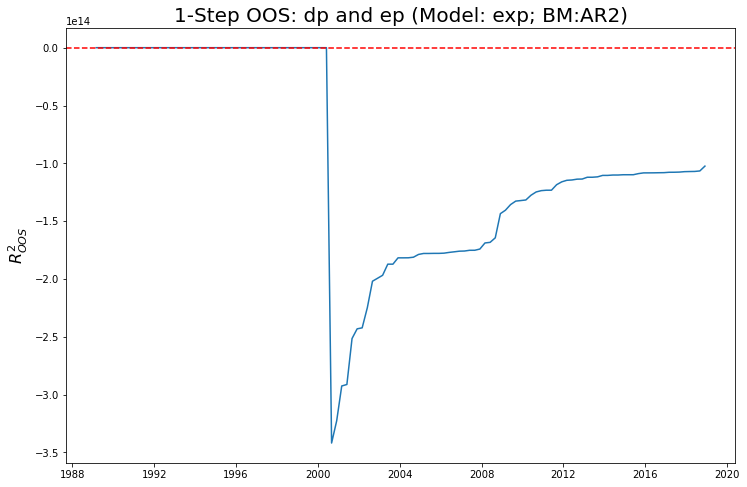

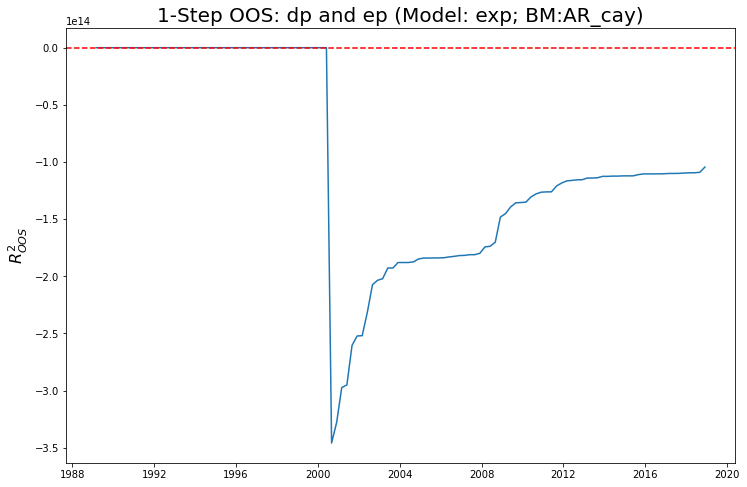

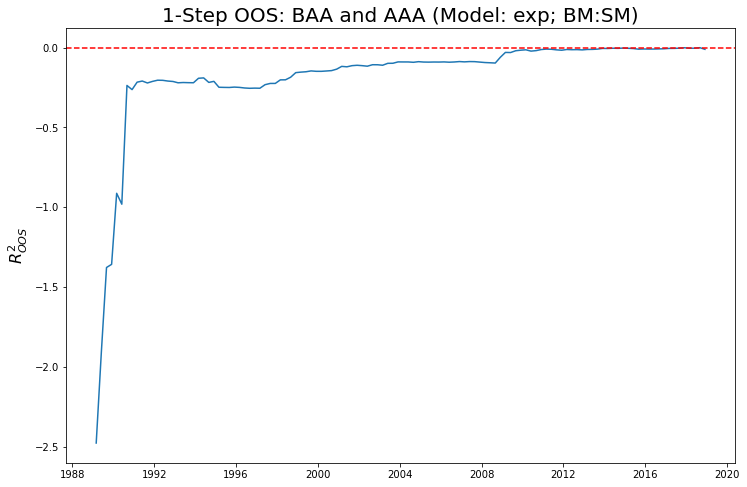

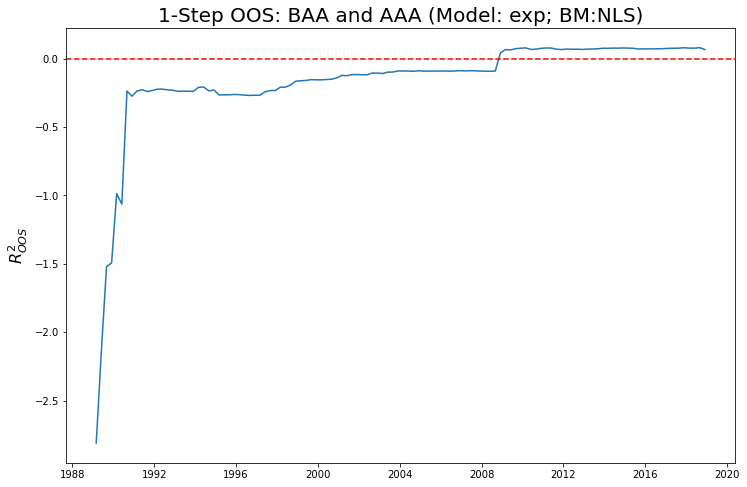

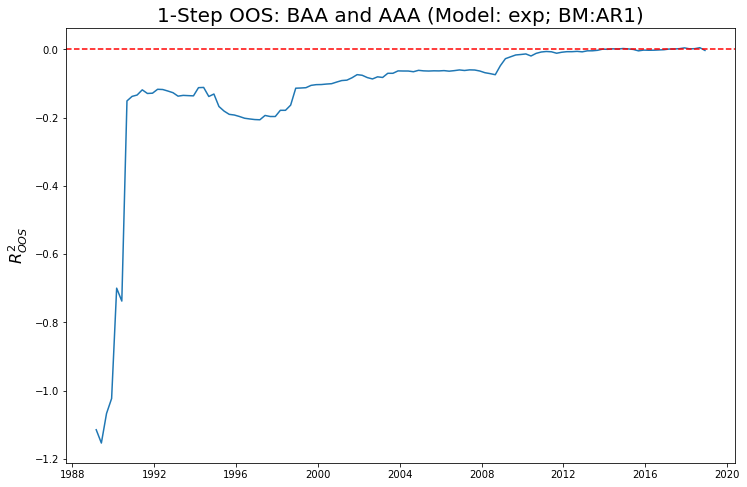

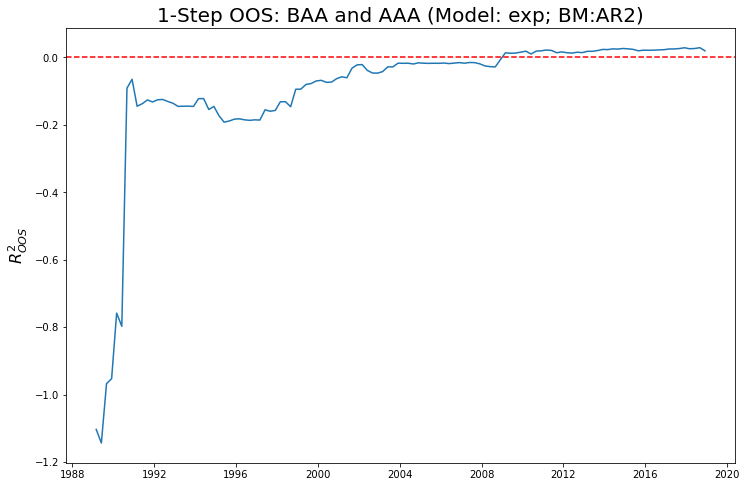

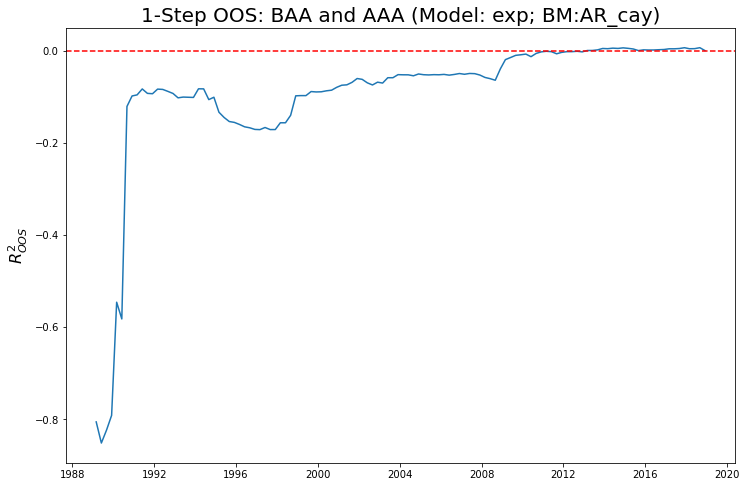

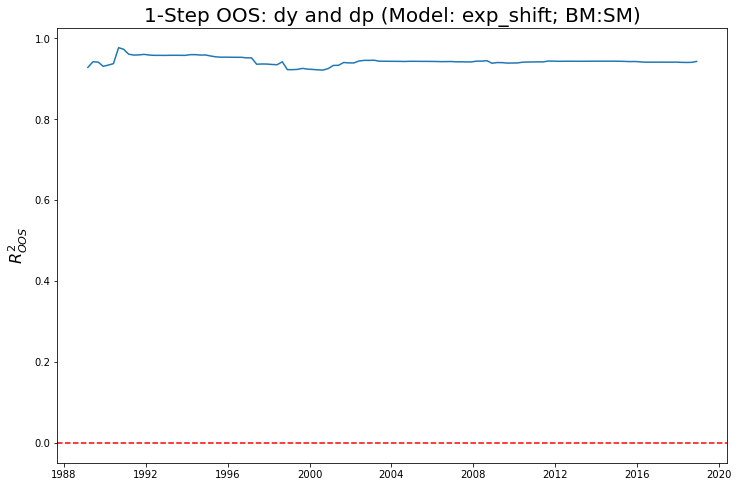

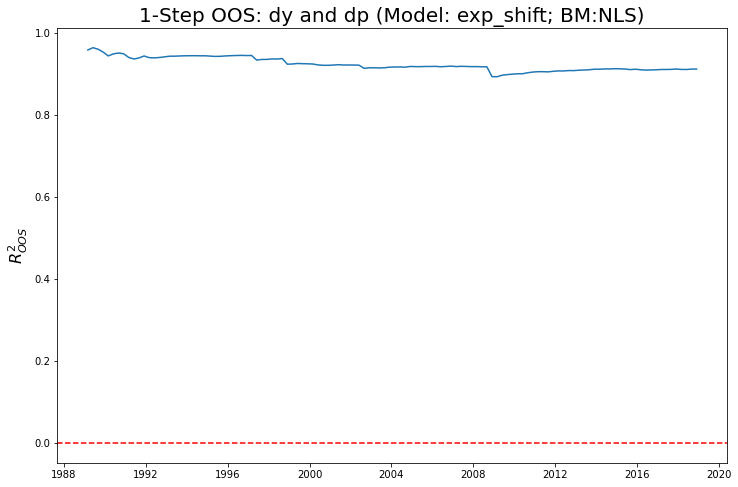

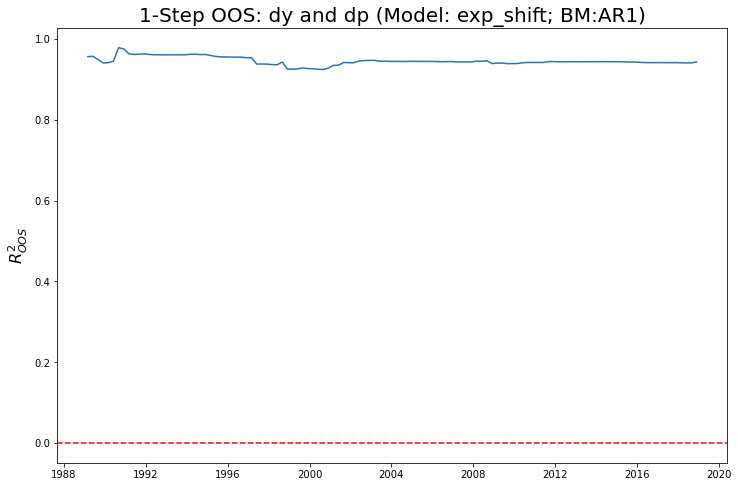

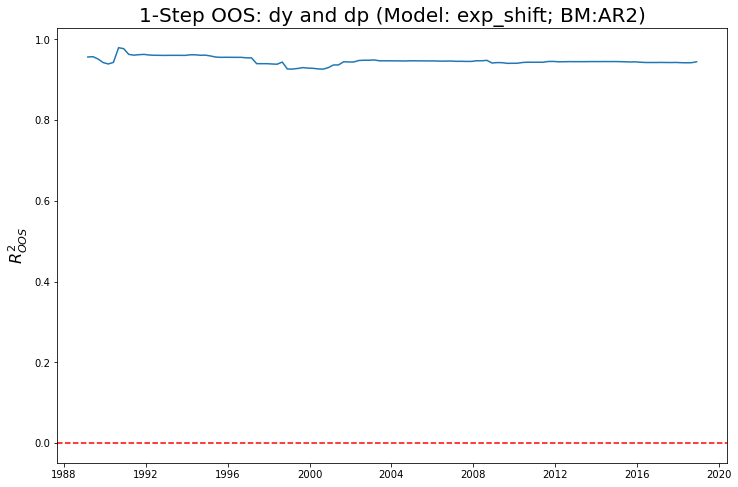

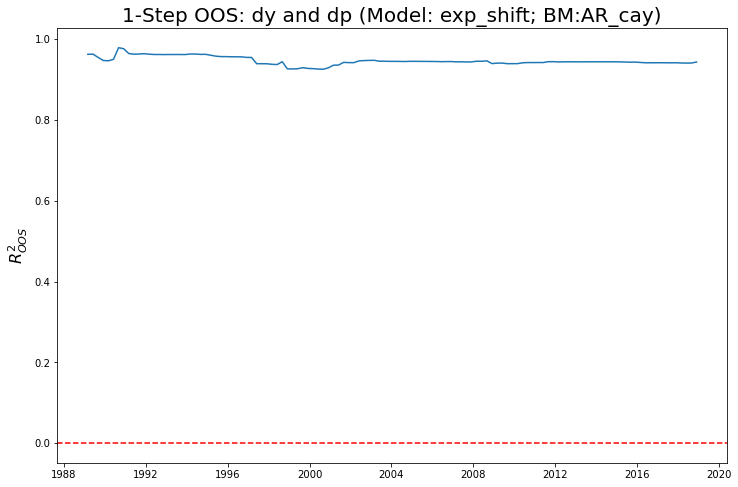

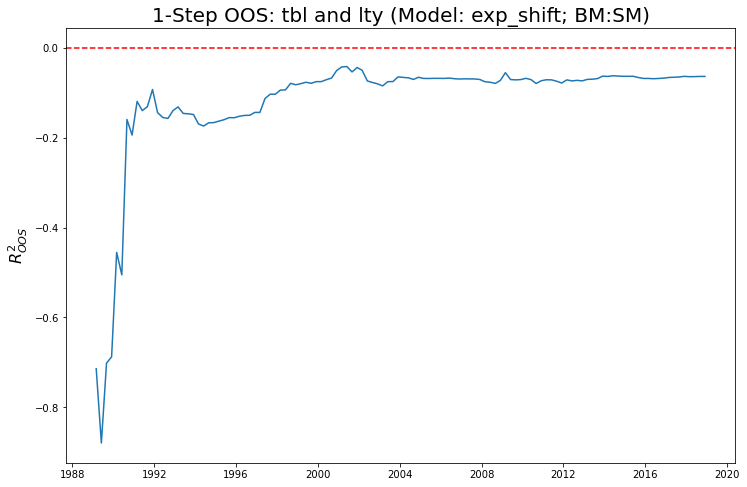

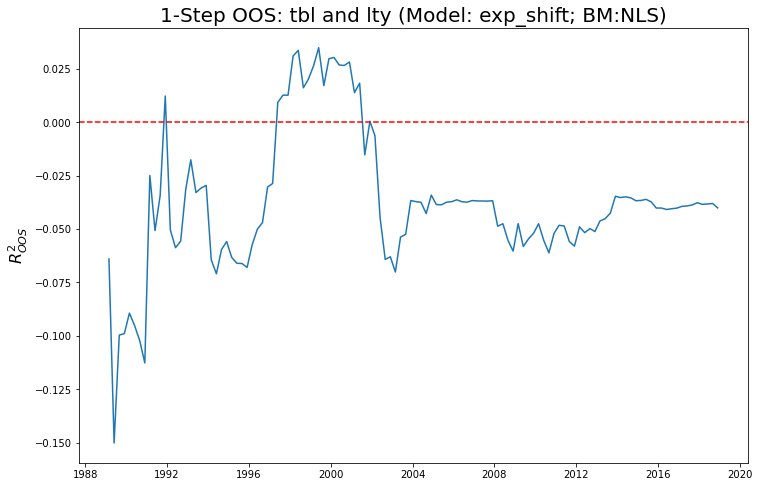

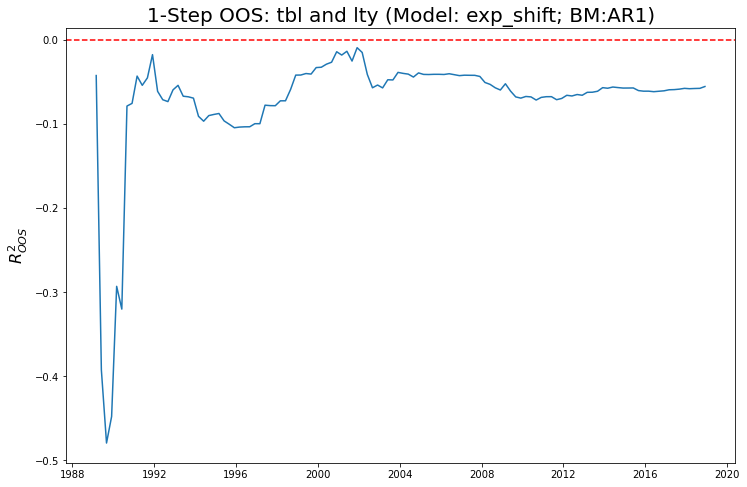

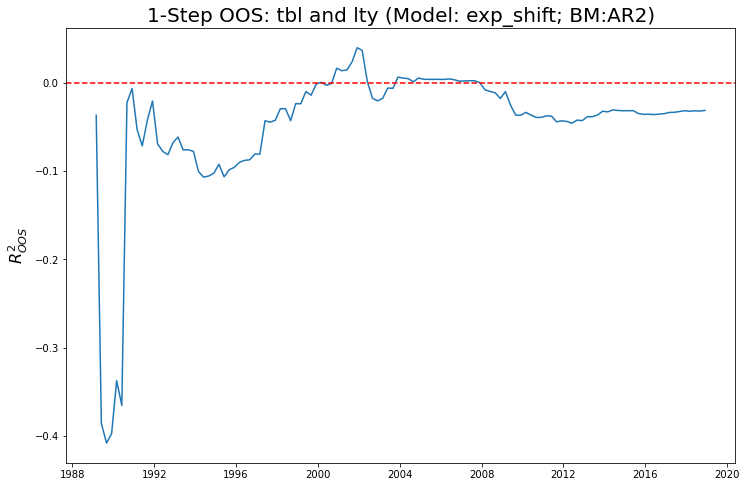

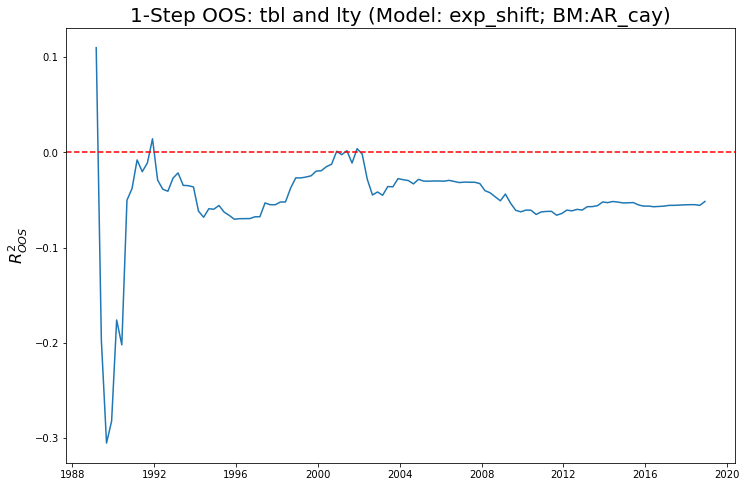

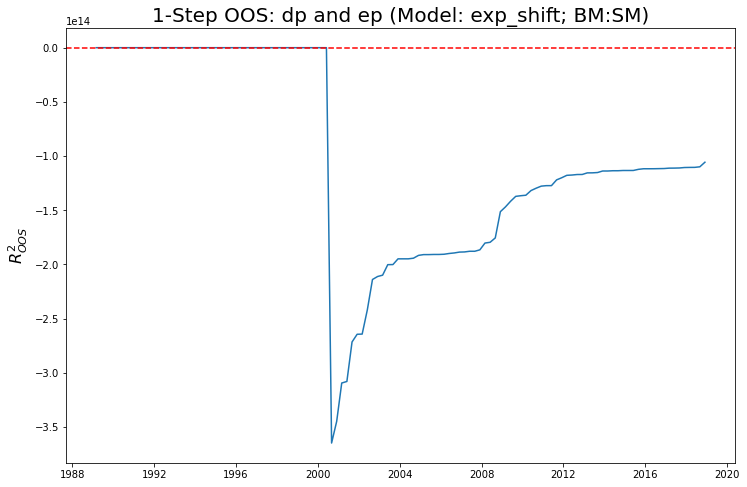

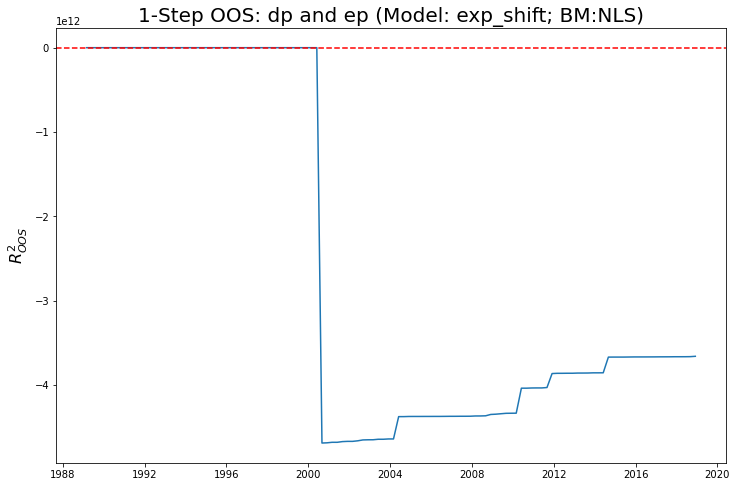

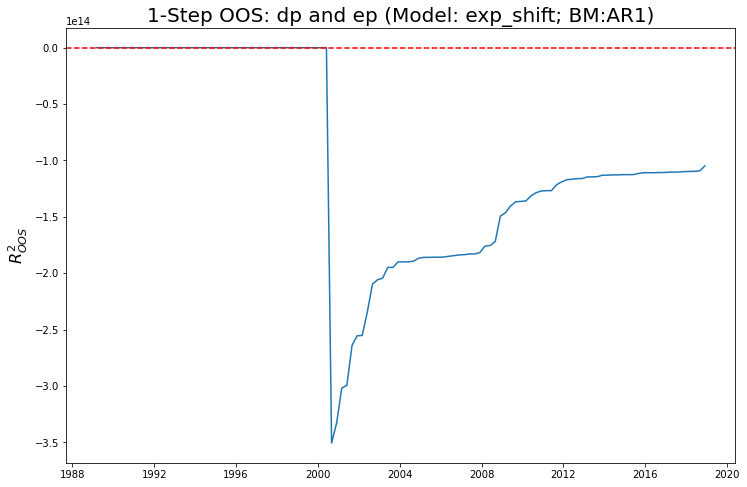

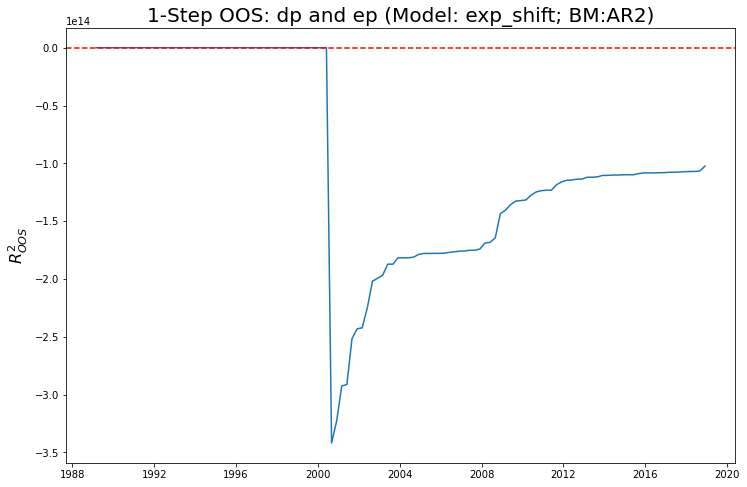

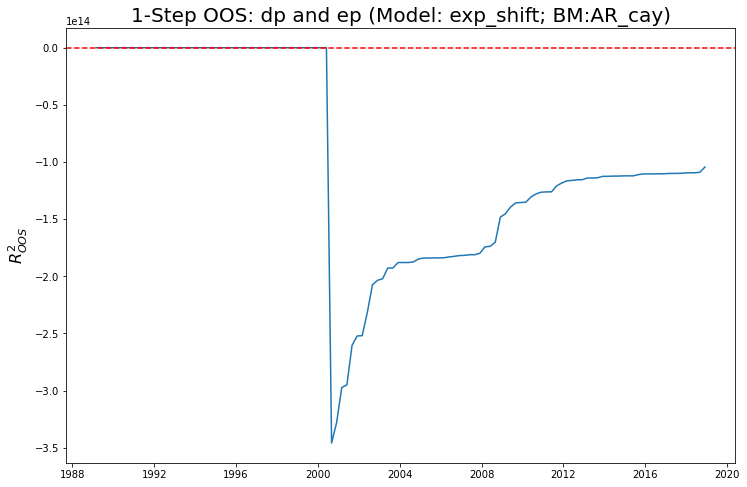

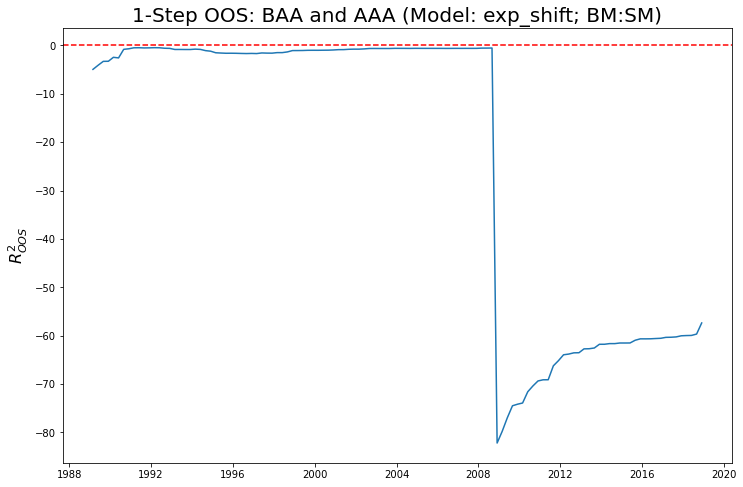

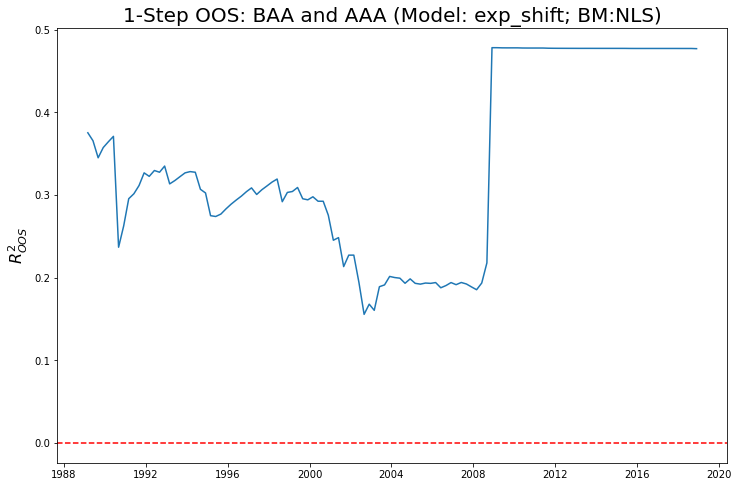

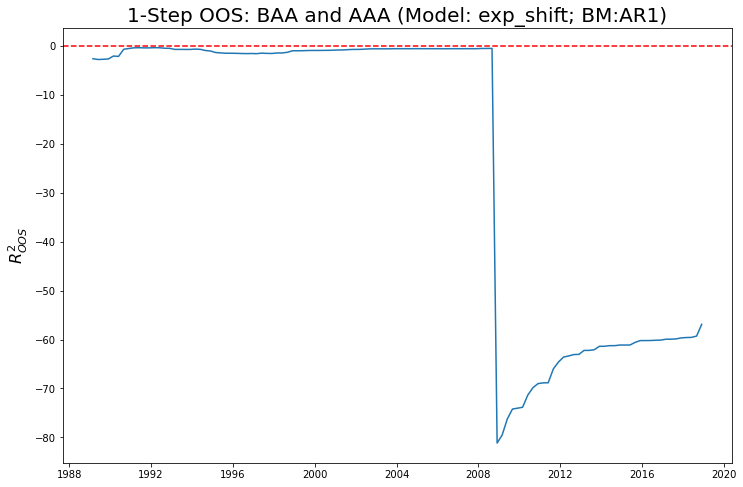

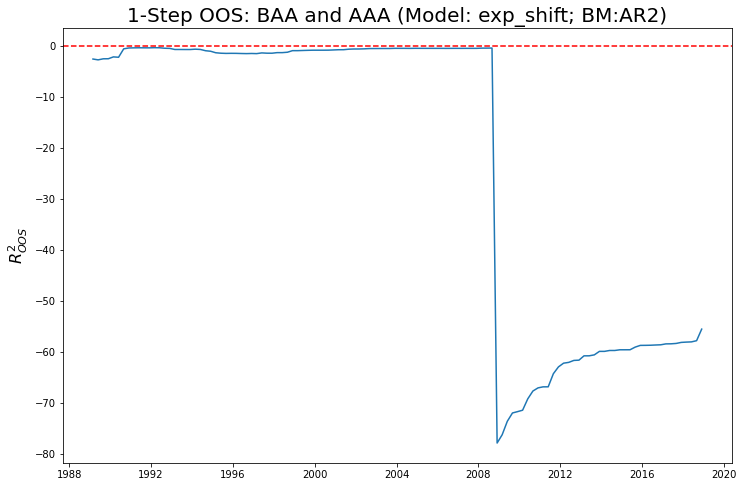

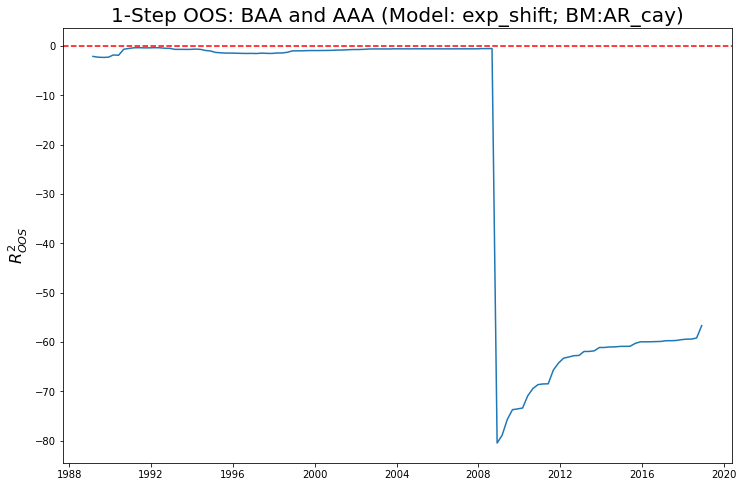

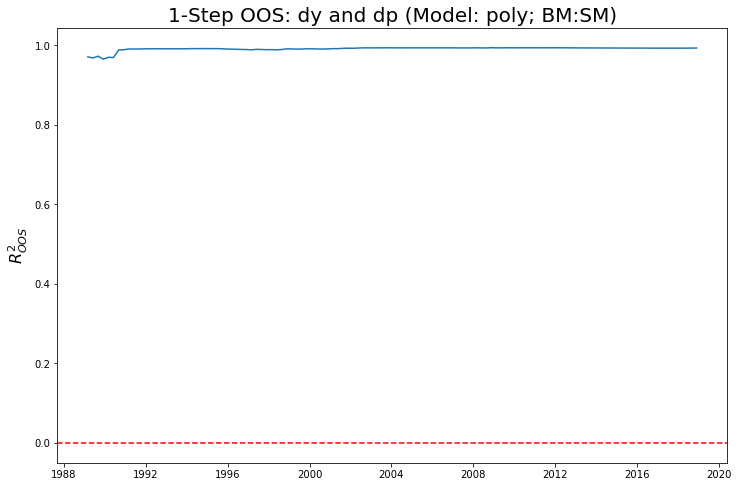

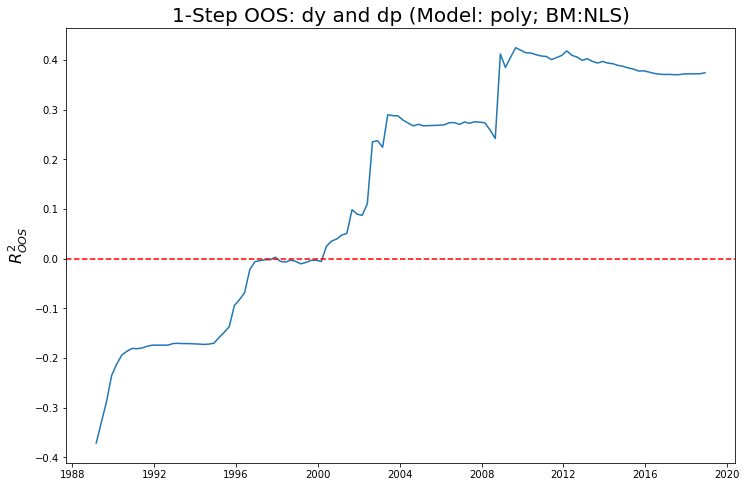

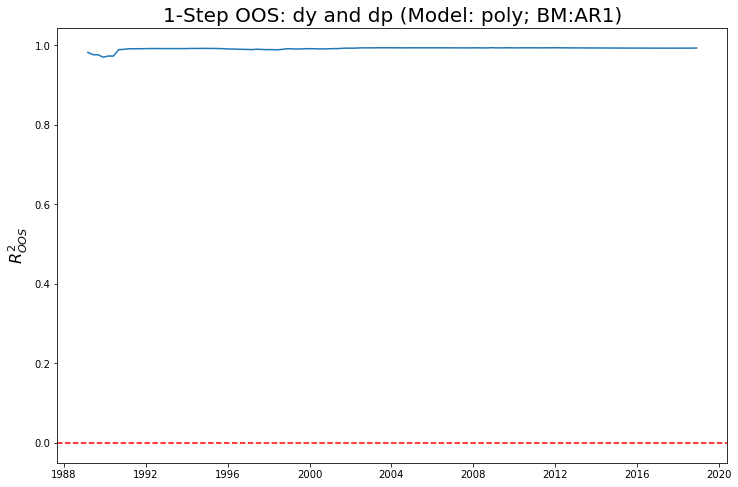

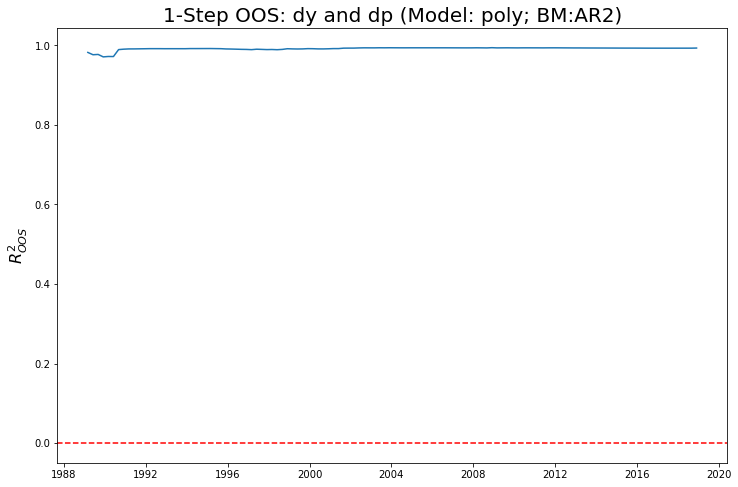

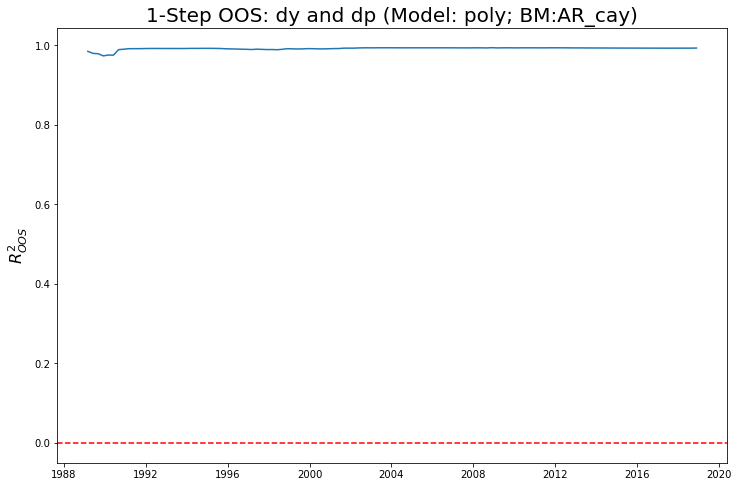

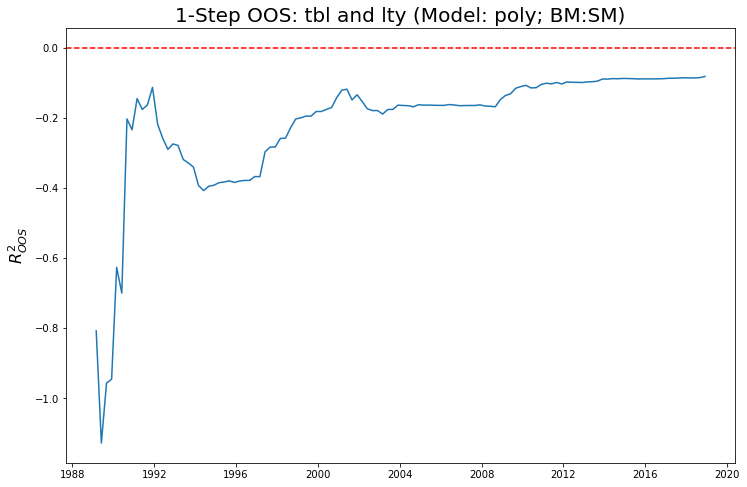

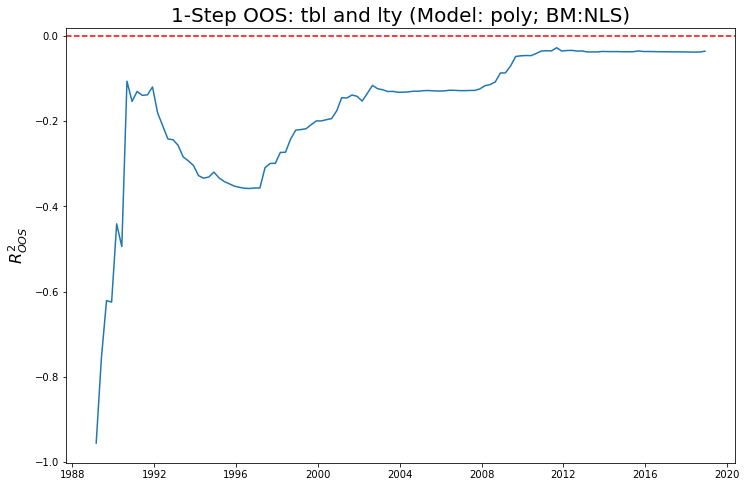

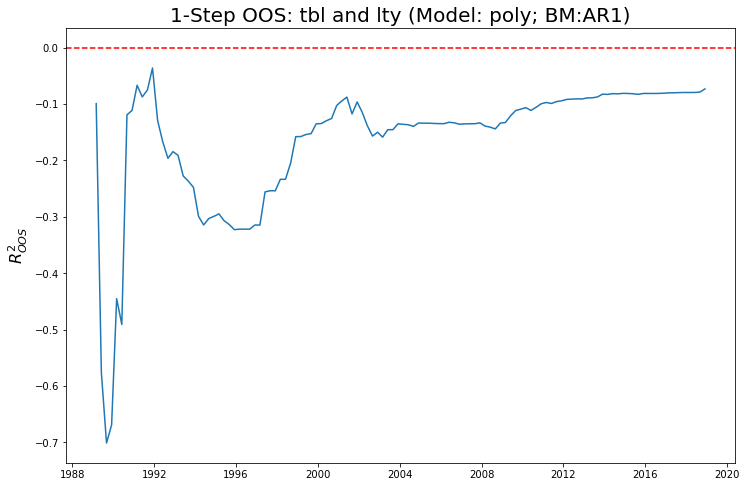

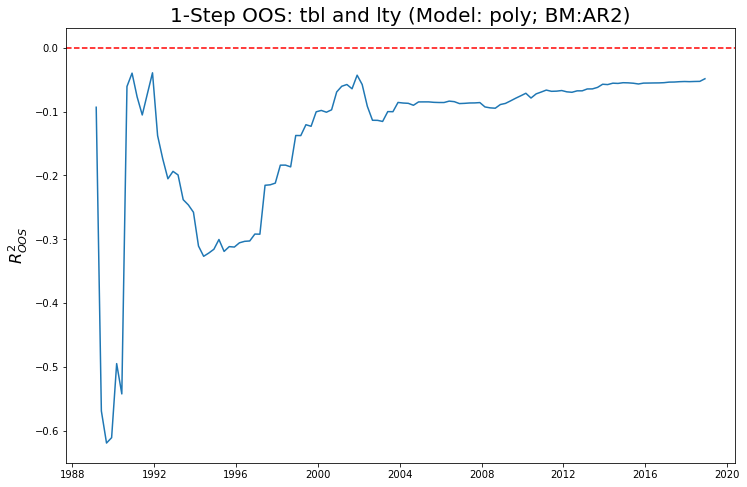

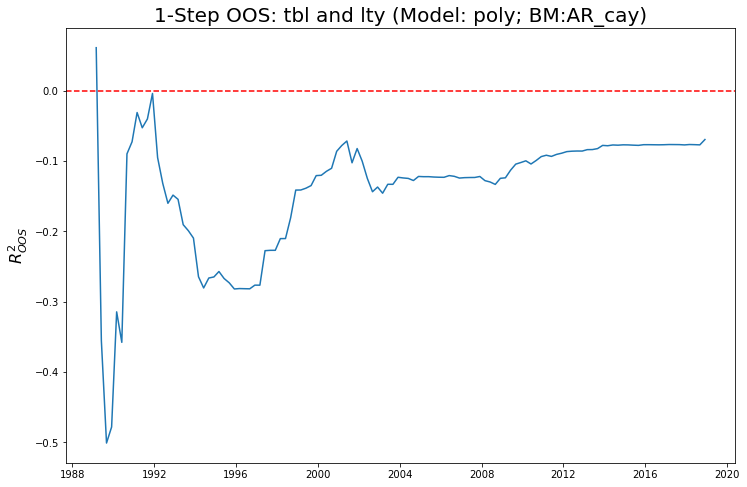

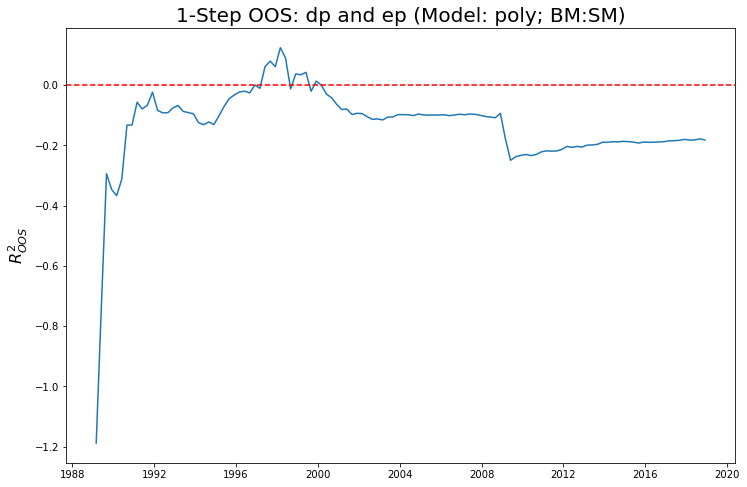

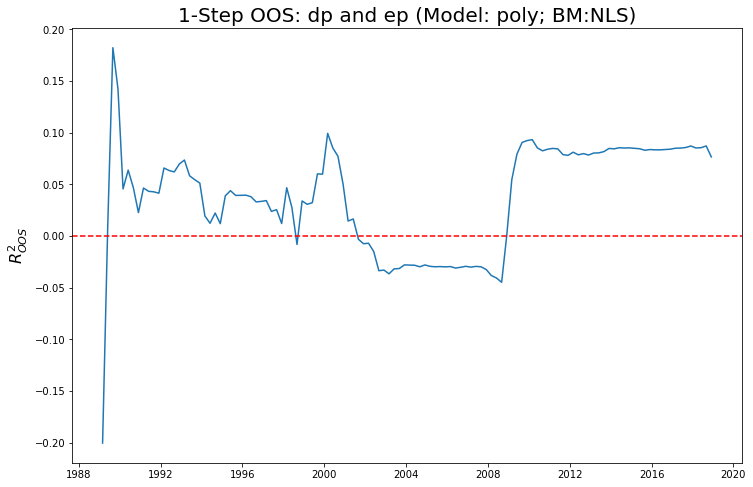

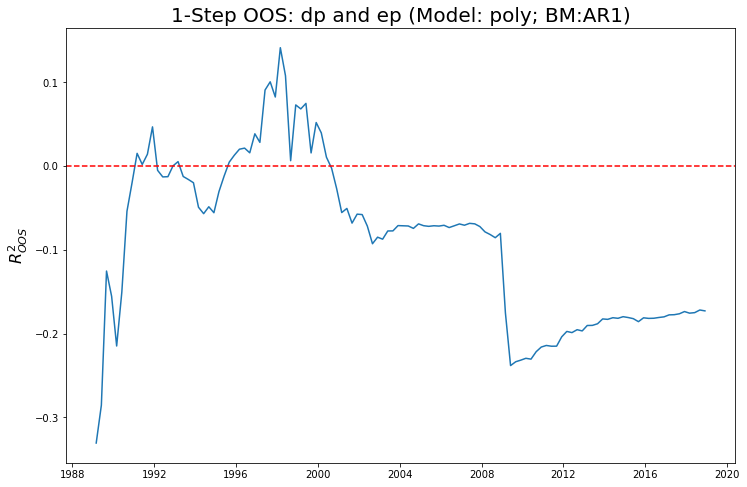

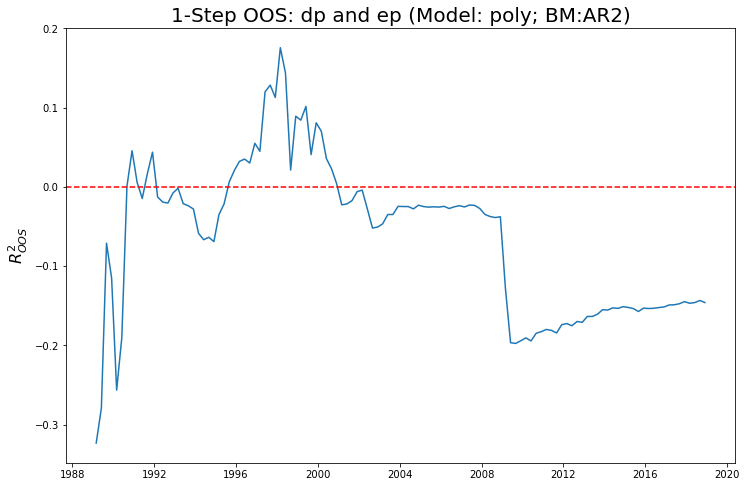

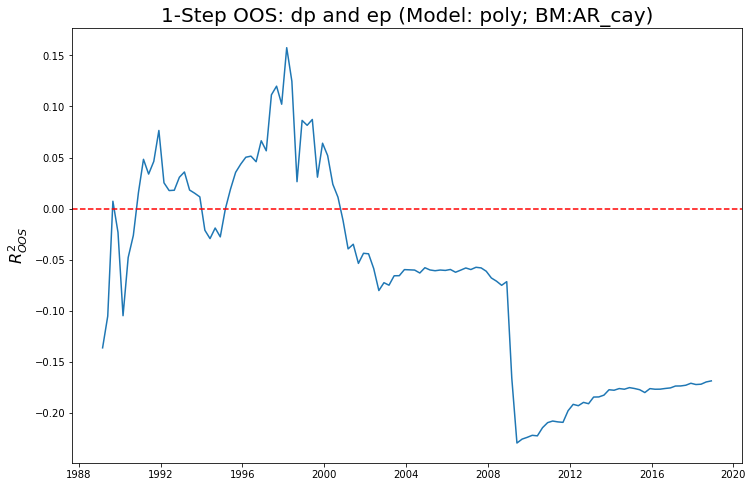

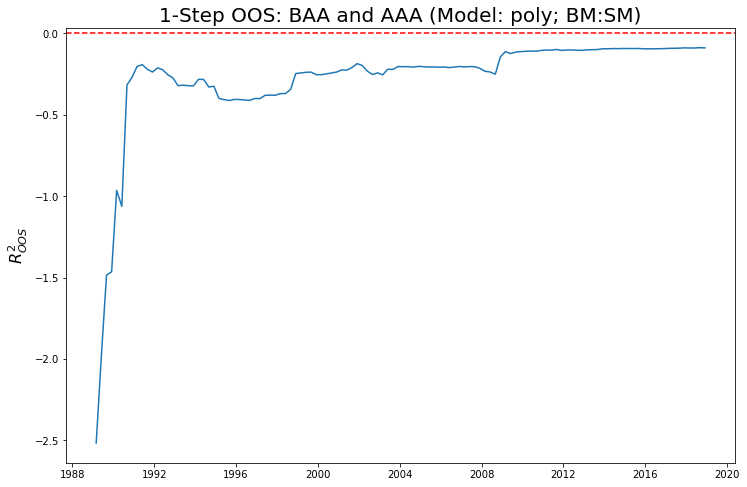

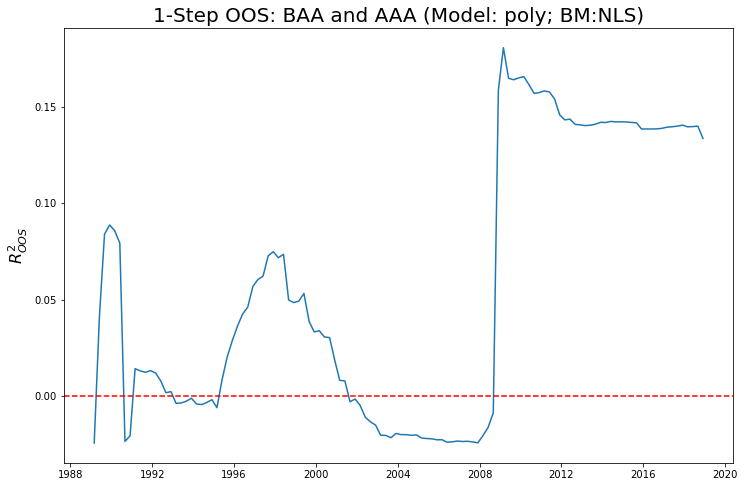

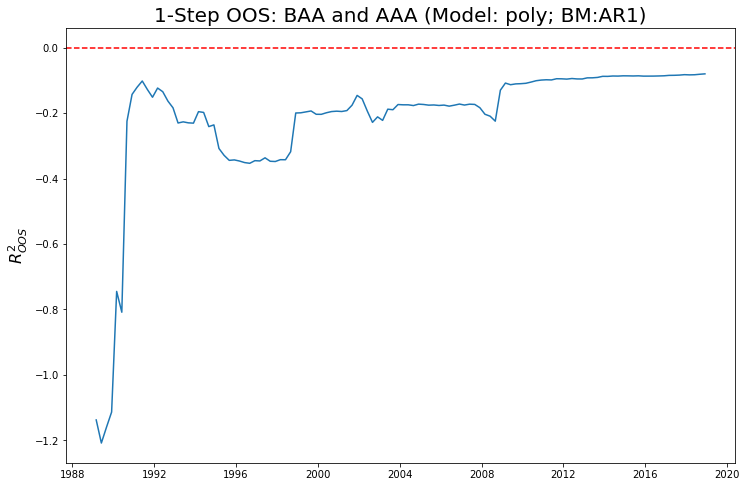

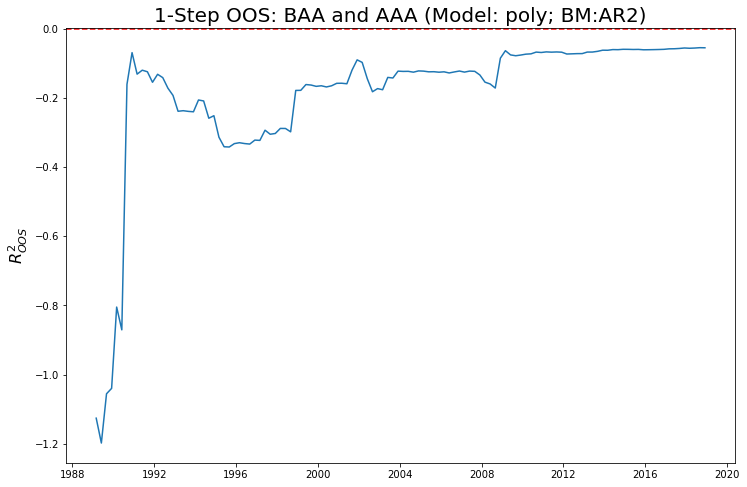

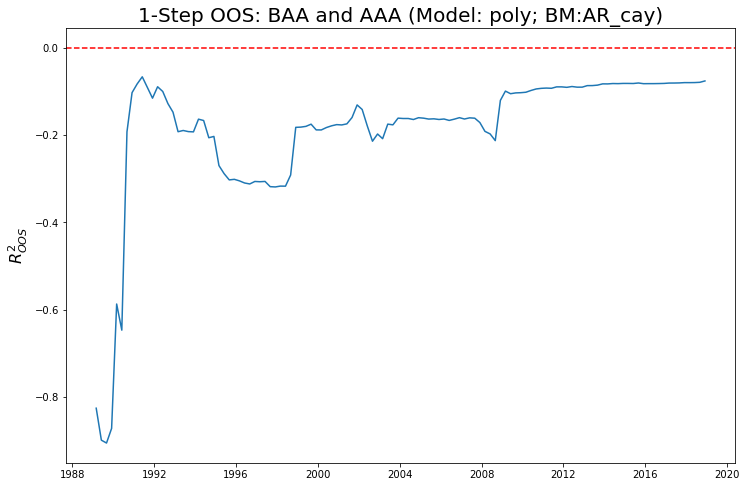

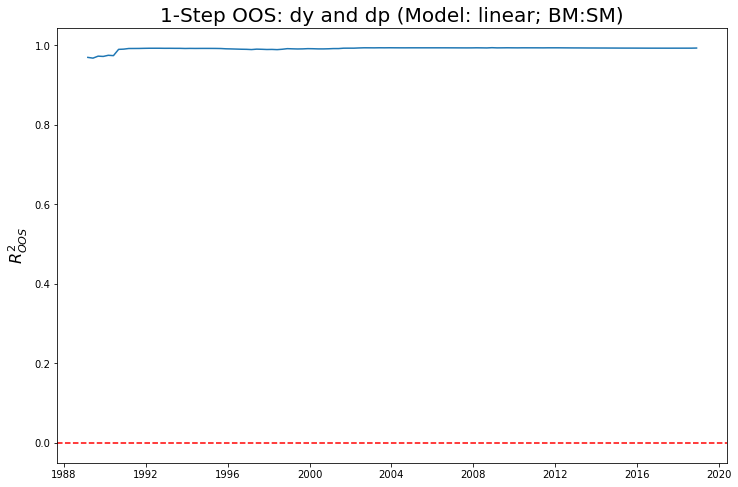

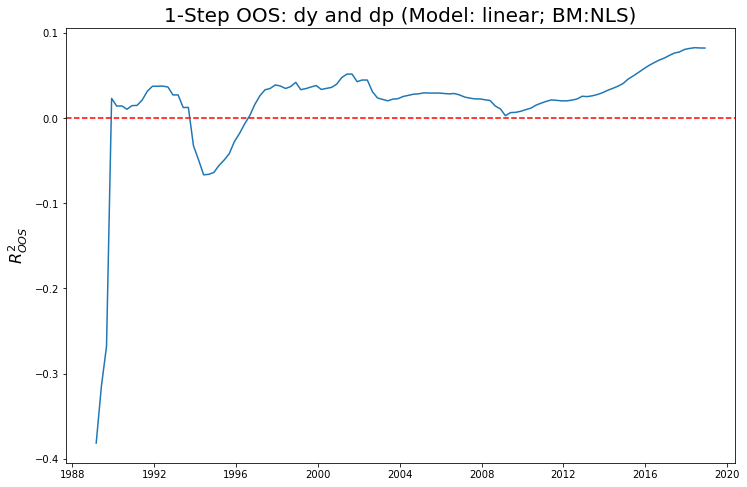

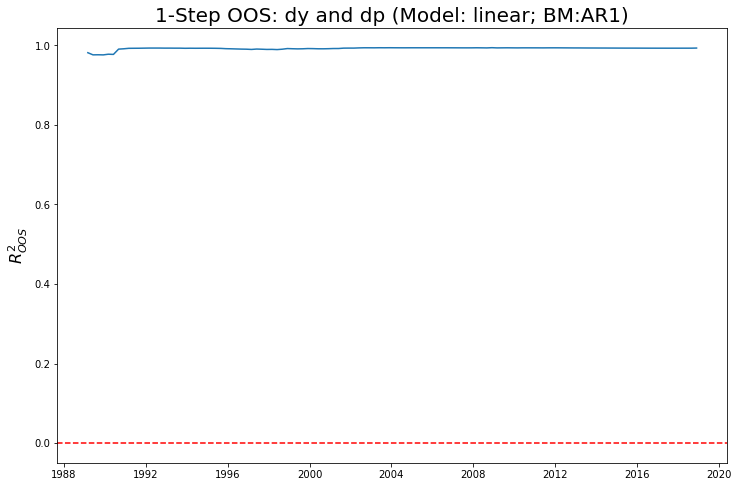

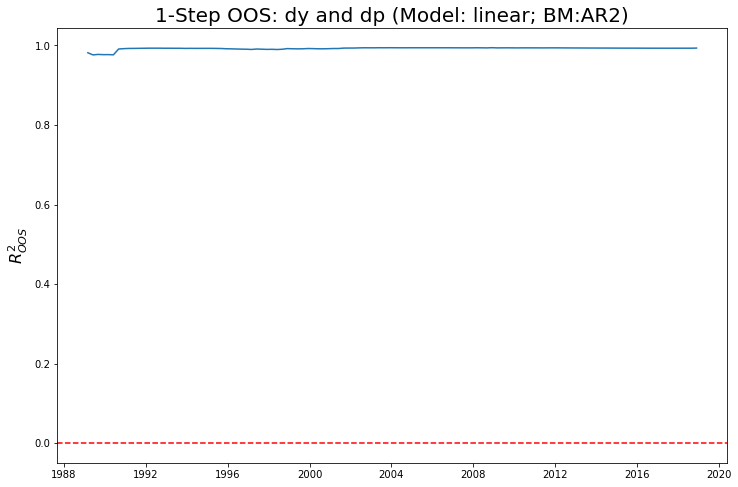

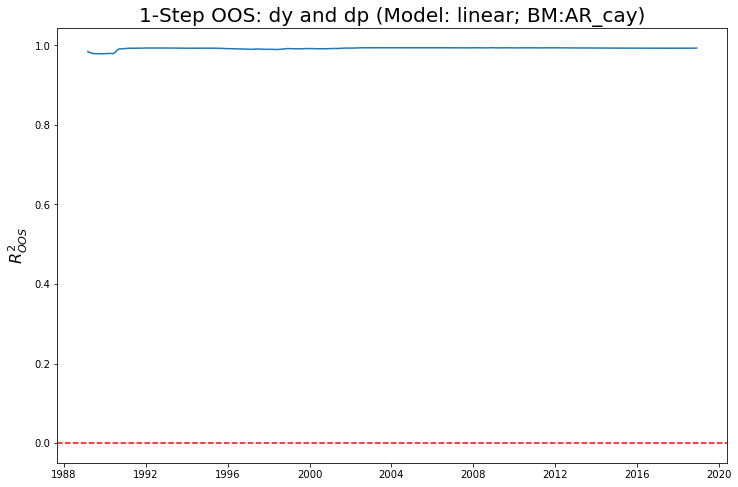

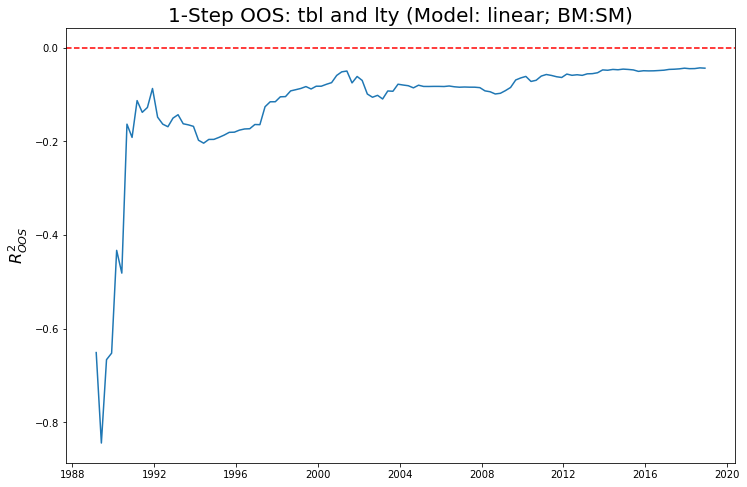

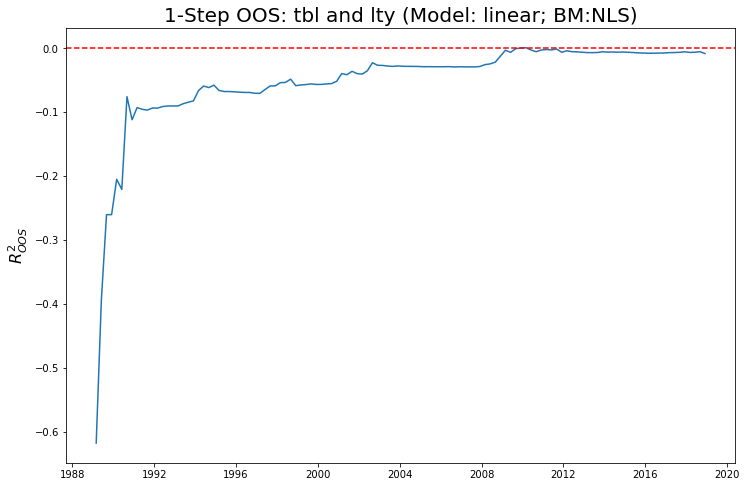

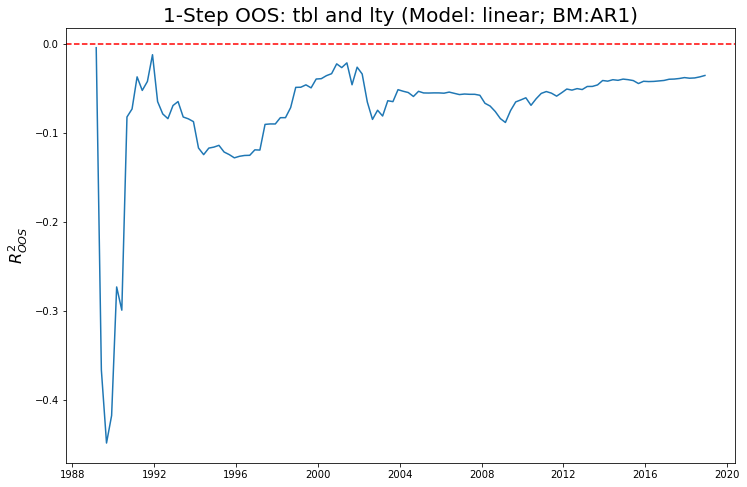

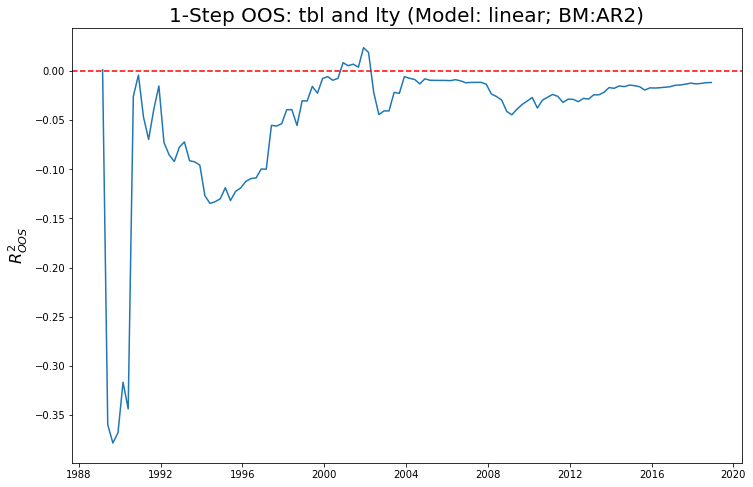

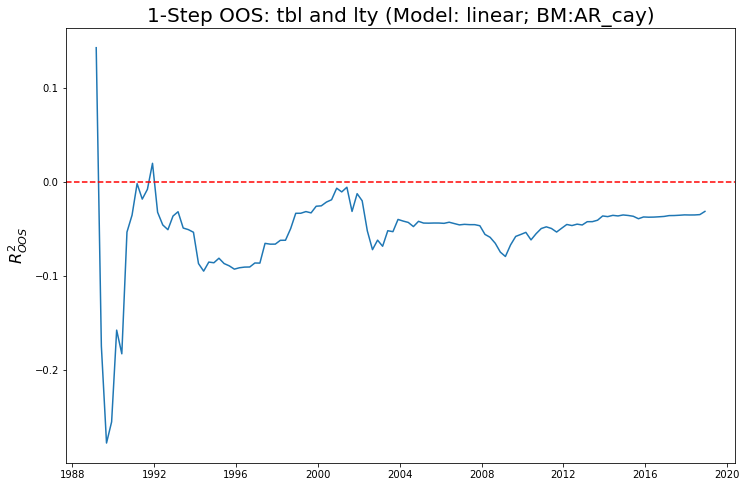

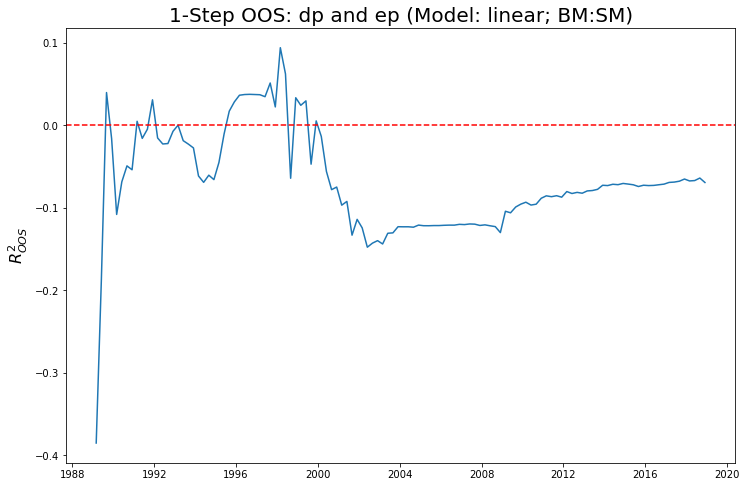

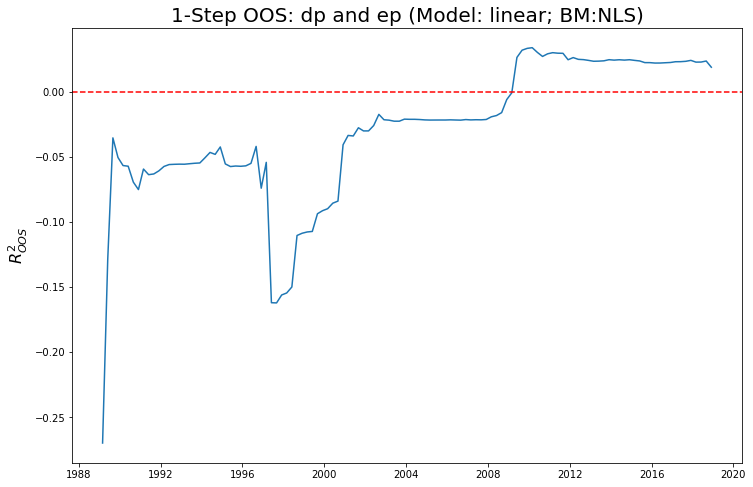

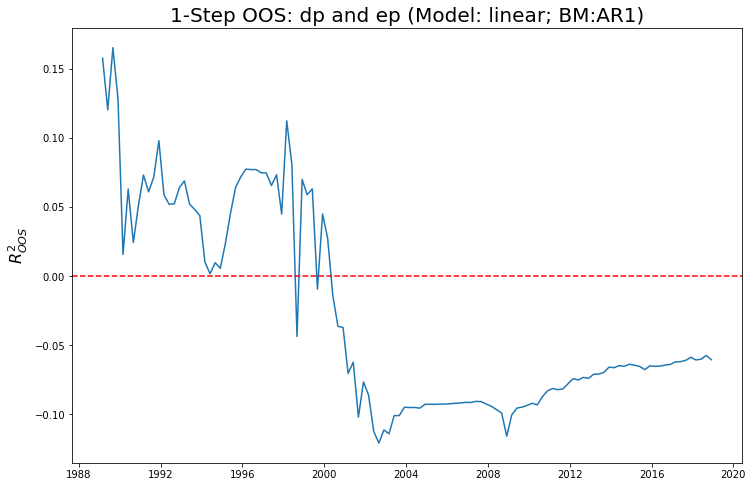

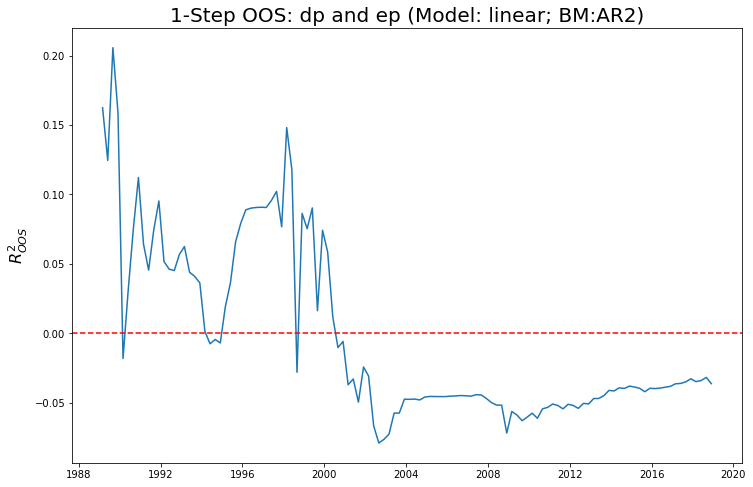

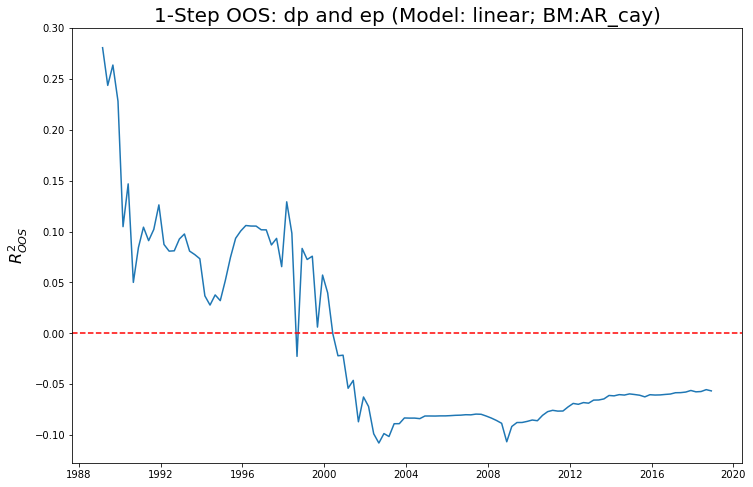

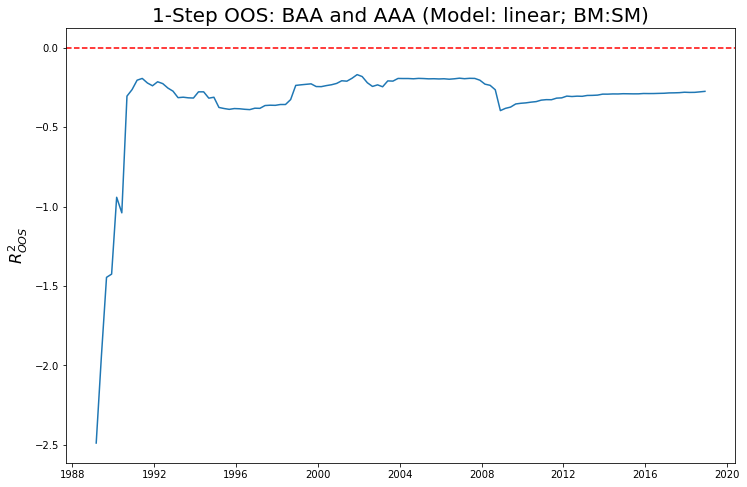

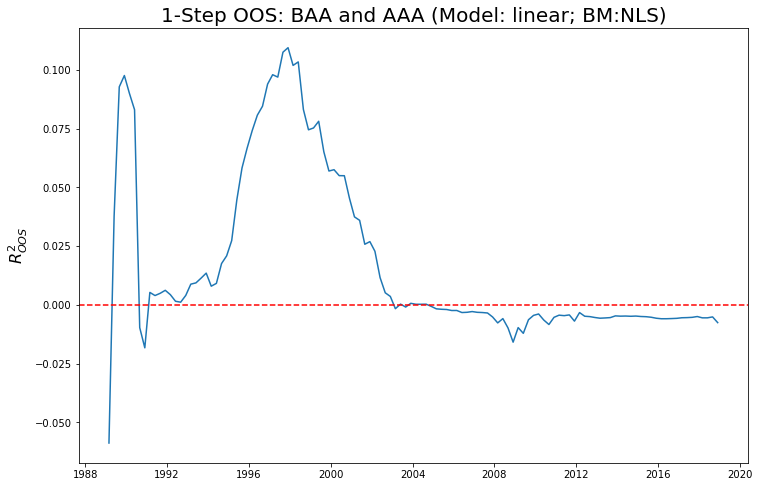

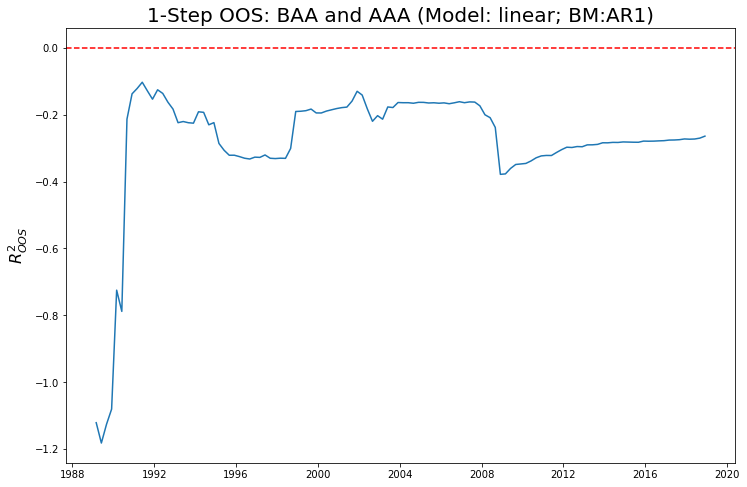

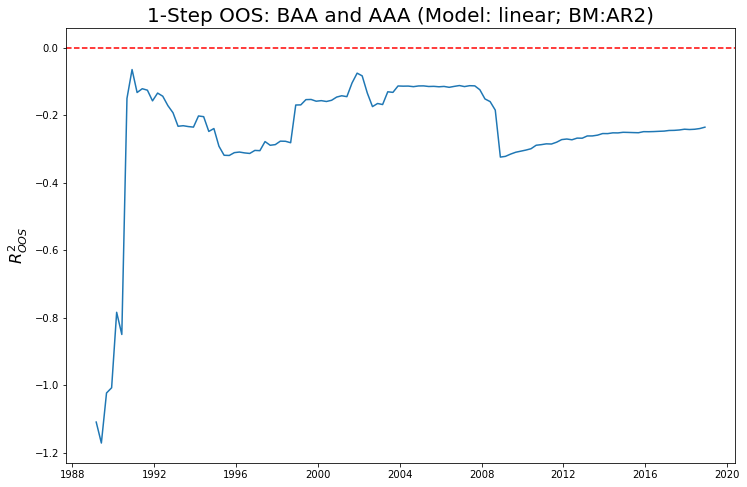

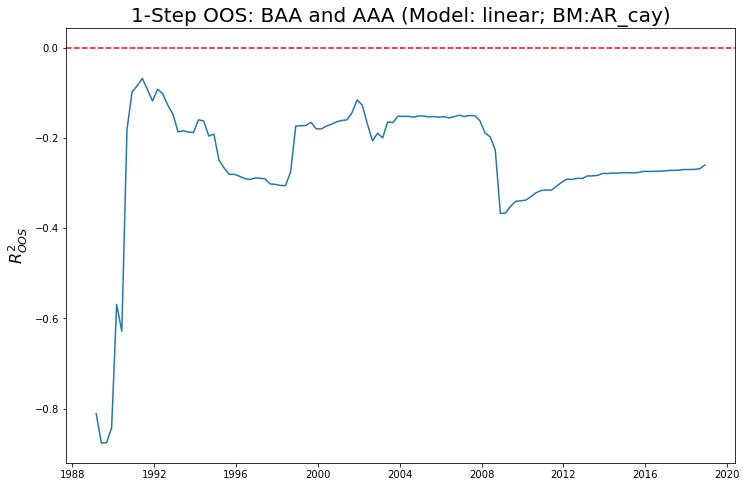

In [205]:
parent = os.getcwd()
folder = 'OOS_plots/taylor_newacy'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('R2_taylor_newcay.xlsx', header=[0,1], index_col=0, sheet_name = k.__name__)['1989-03-01':]
    for i,j in itertools.product(co_list, base):
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[i][j])
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('1-Step OOS: '+ co_dict[i] + ' (' + 'Model: '+ k.__name__[:-5] + '; BM:' + j + ')', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k.__name__[:-5] + '_' + i + '_' + j))

## Regenerate results for project 2

In [275]:
writer_R2 = pd.ExcelWriter('results/OOS_R2_project2.xlsx', engine='xlsxwriter')

for f in fun_list:
    oos_MSE = pd.read_excel('results/OOS_MSE_start0.xlsx', header=[0,1], index_col=0, sheet_name = f)
    for i, j in itertools.product(base, co_list):
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j][k])):
            target_sum.append(oos_MSE[j]['NLS_MSE'][-(R+1):].sum())
            cumu_sum.append(oos_MSE[j][k][-(R+1):].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
        cumulate_R2.loc[j].loc[i] = cumu_R2
    cumulate_R2.T.to_excel(writer_R2, sheet_name=f)
writer_R2.save()
writer_R2.close()

In [276]:
fun_list = ['sin_func',
            'cos_func',
            'scaled_sin_func',
            'scaled_cos_func',
            'exp_shift_func',
            'exp_func',
            'poly_func']

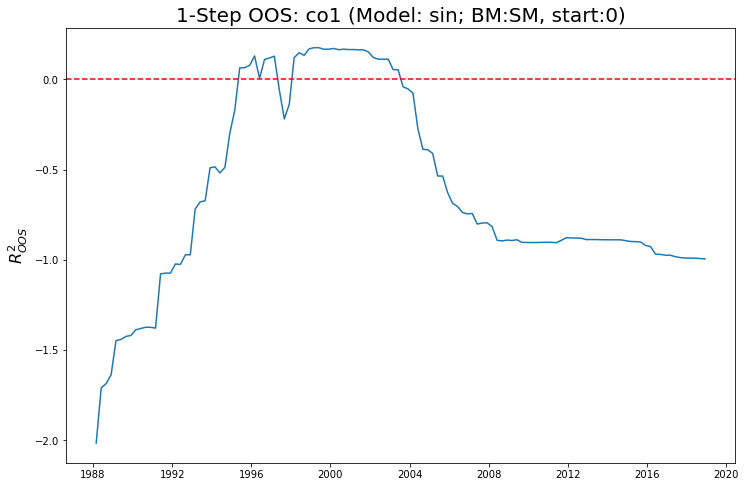

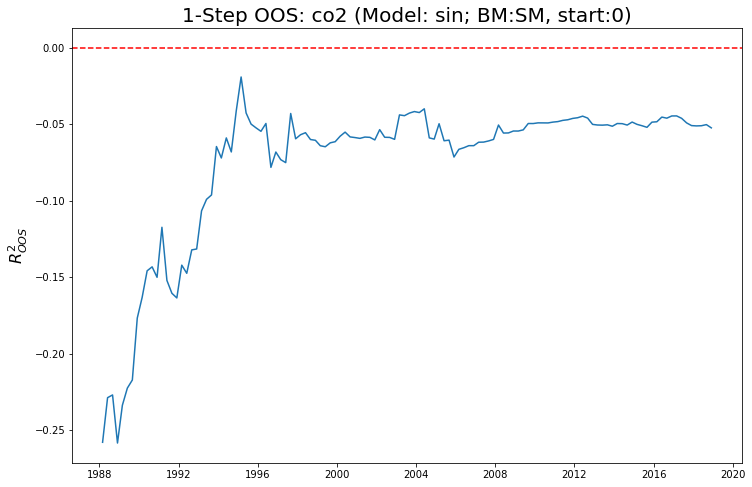

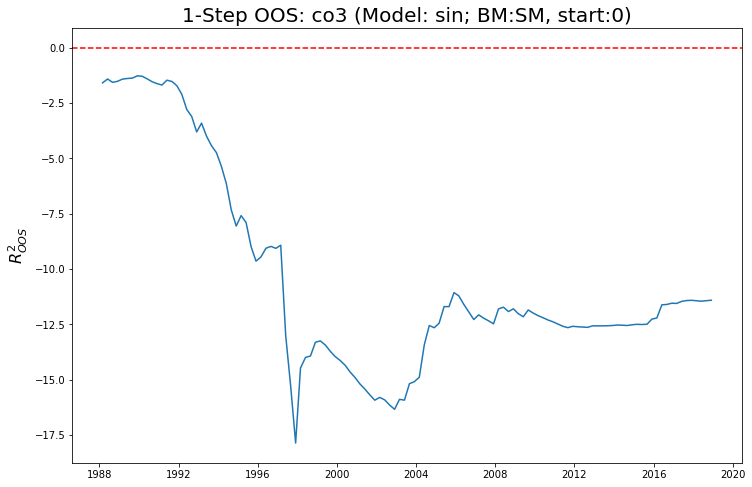

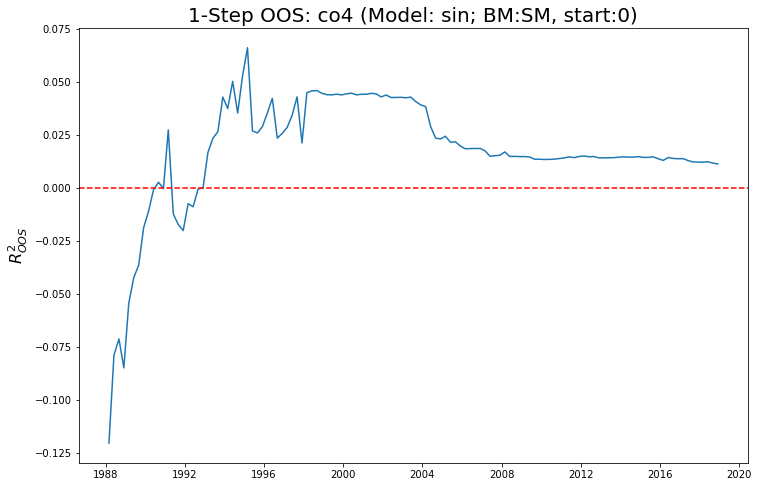

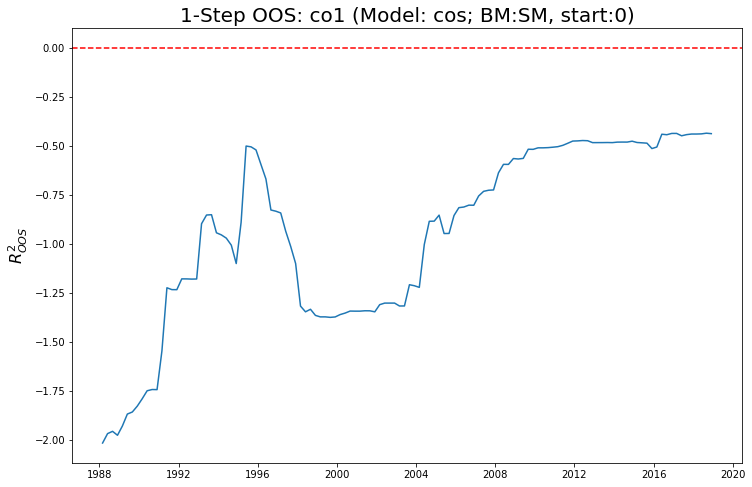

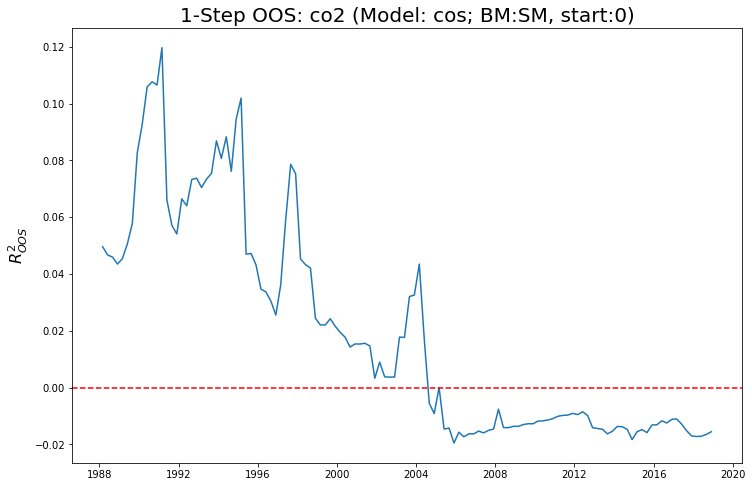

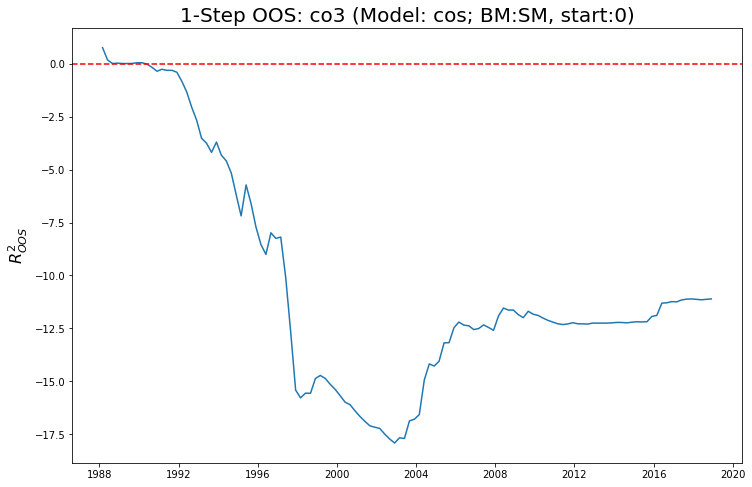

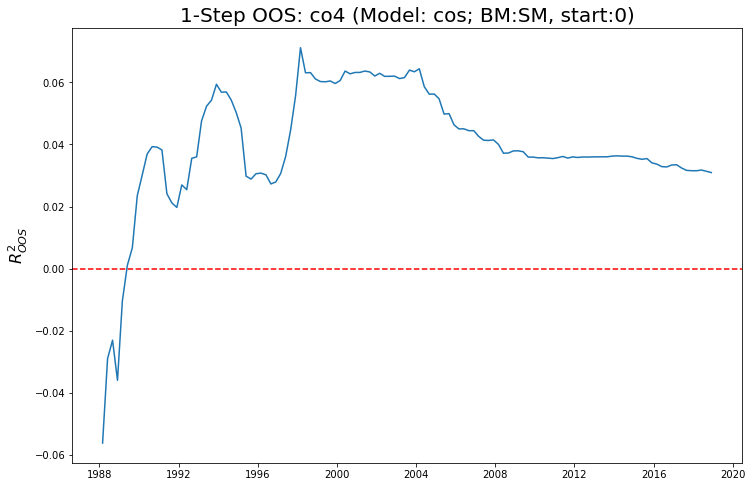

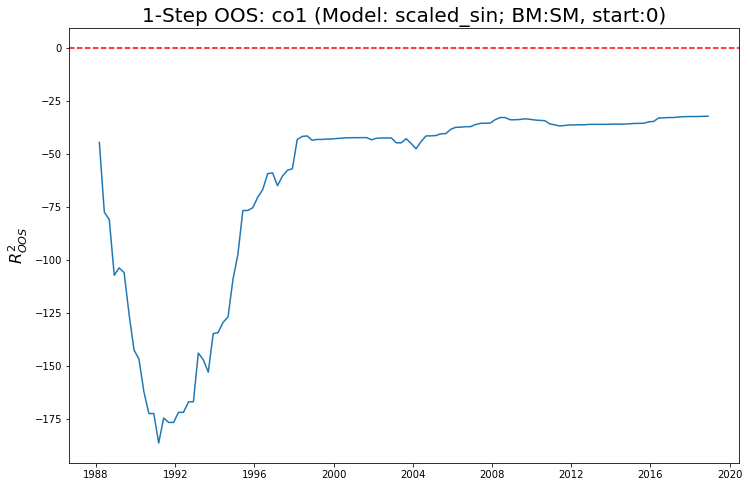

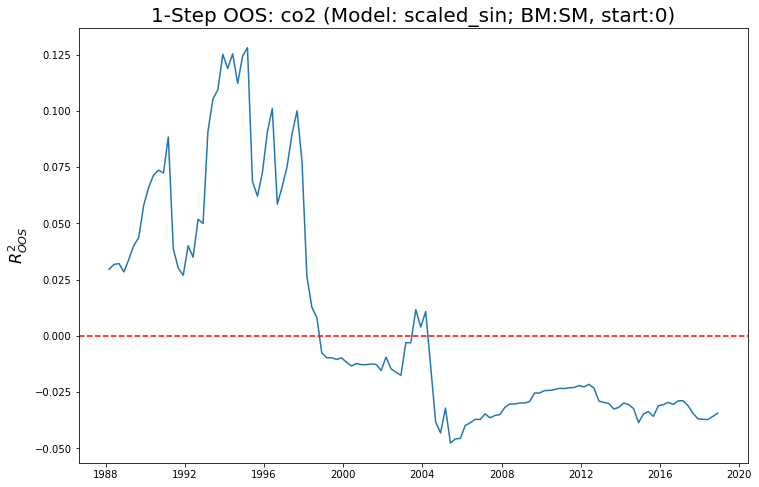

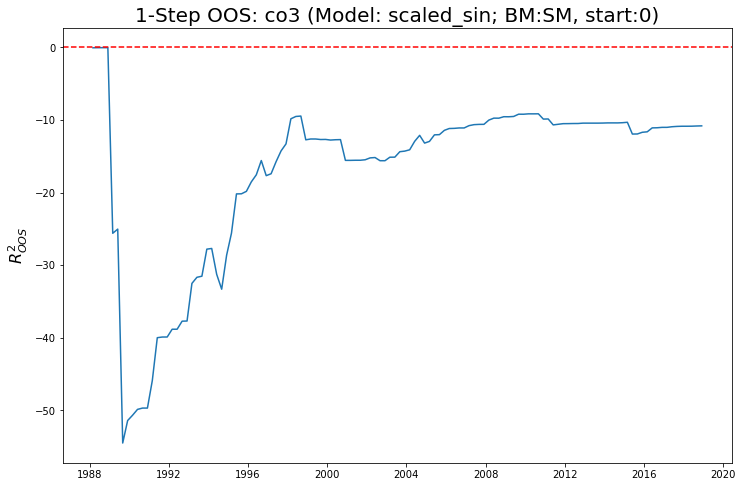

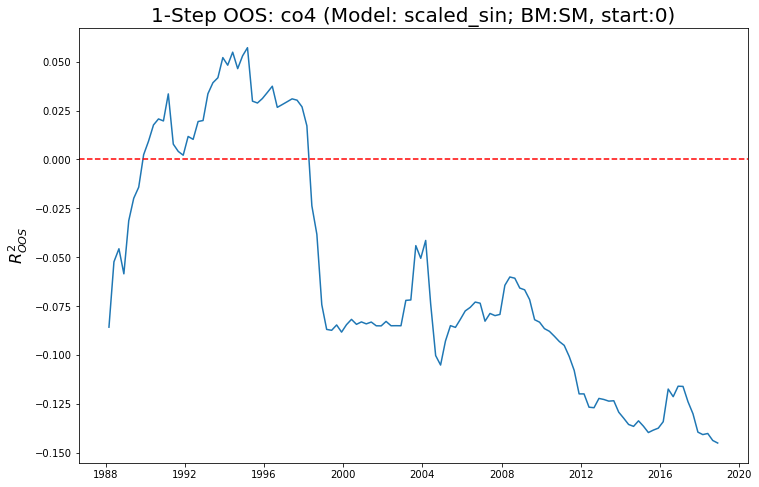

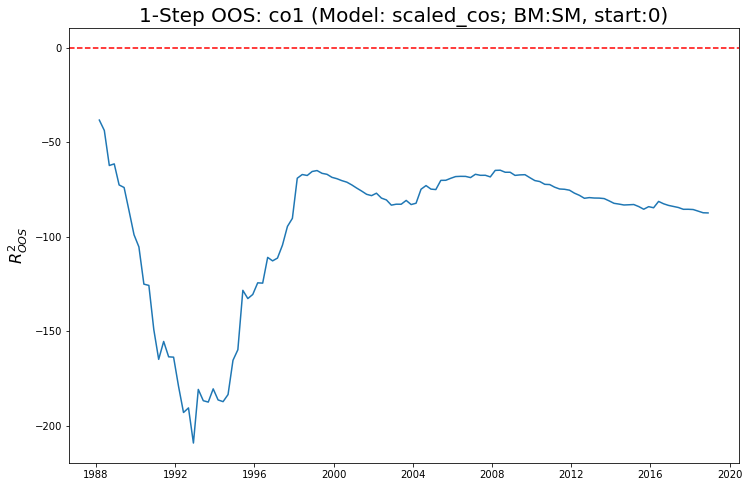

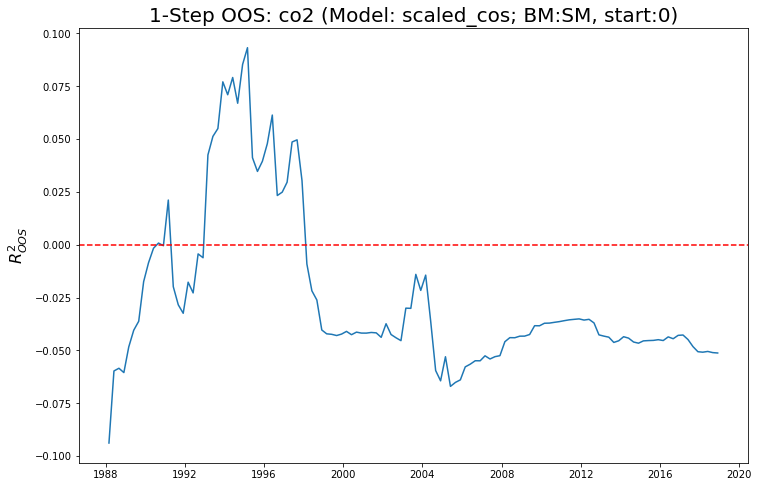

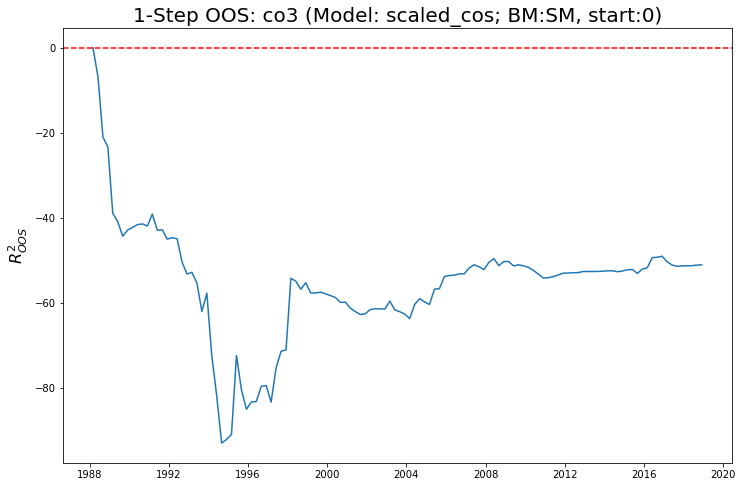

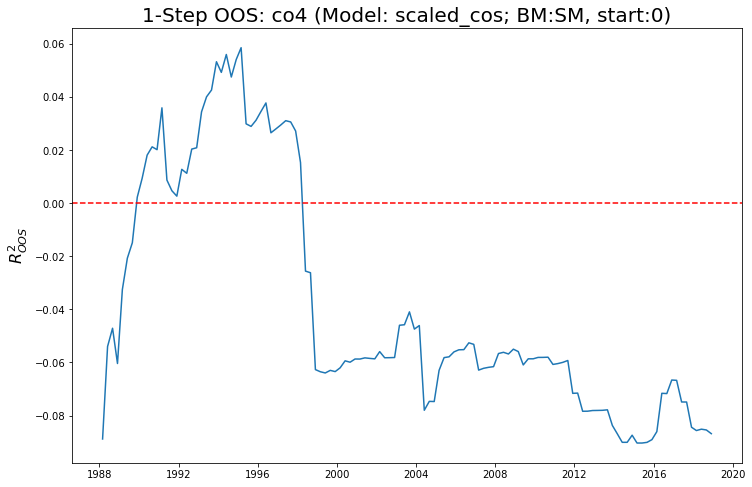

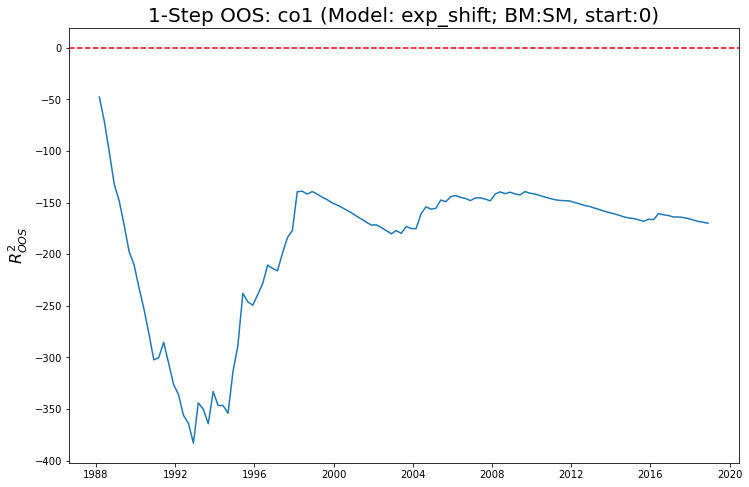

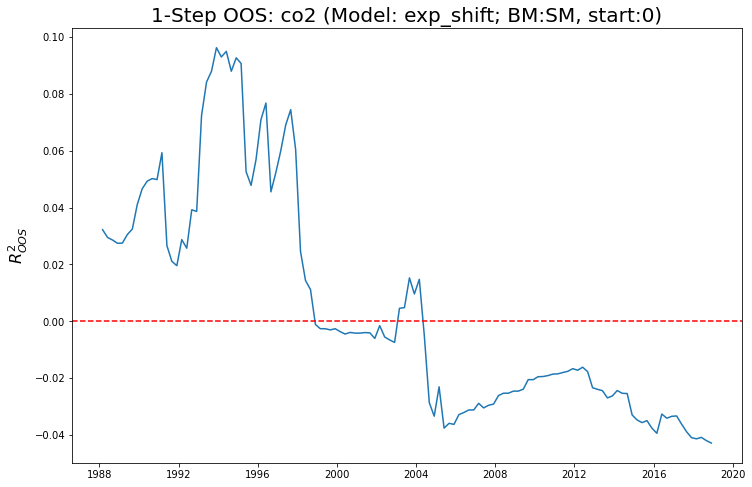

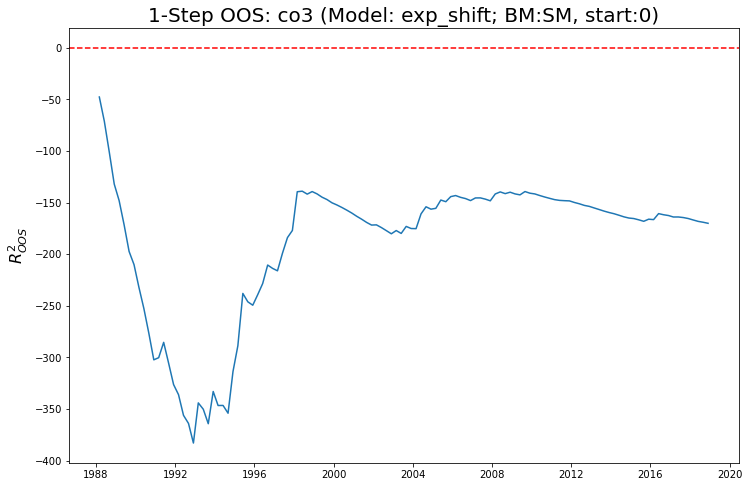

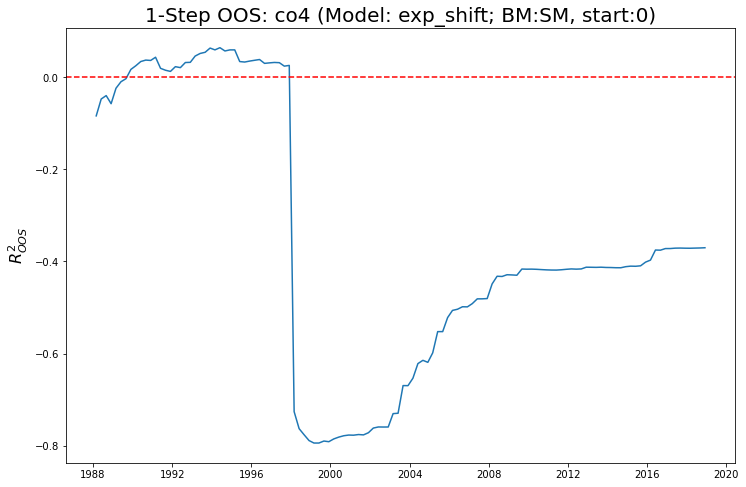

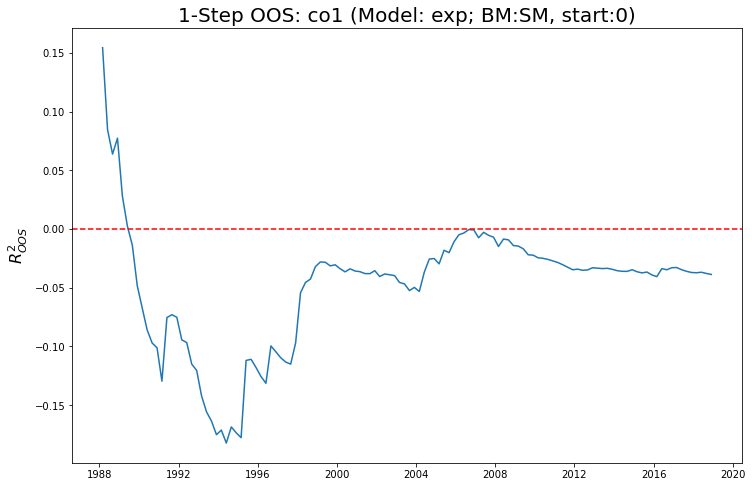

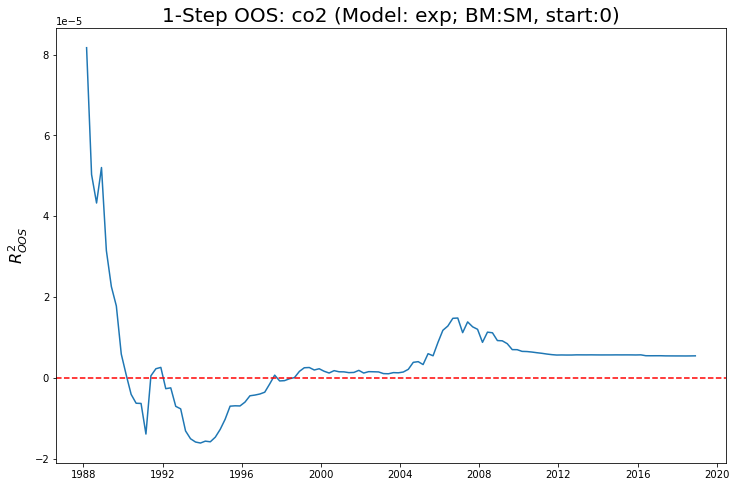

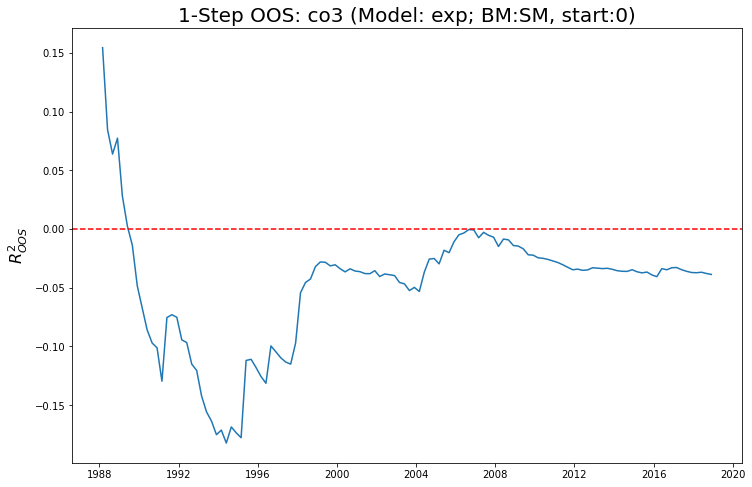

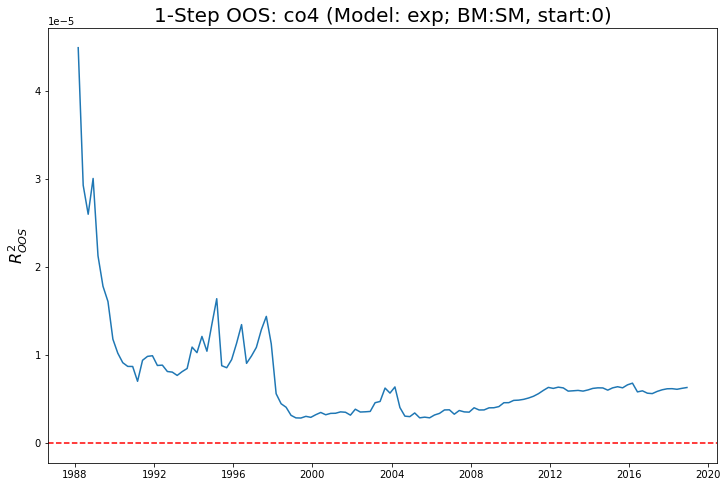

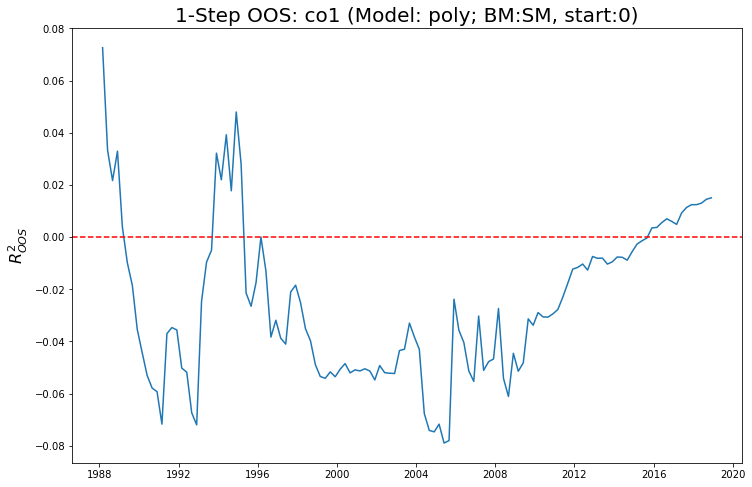

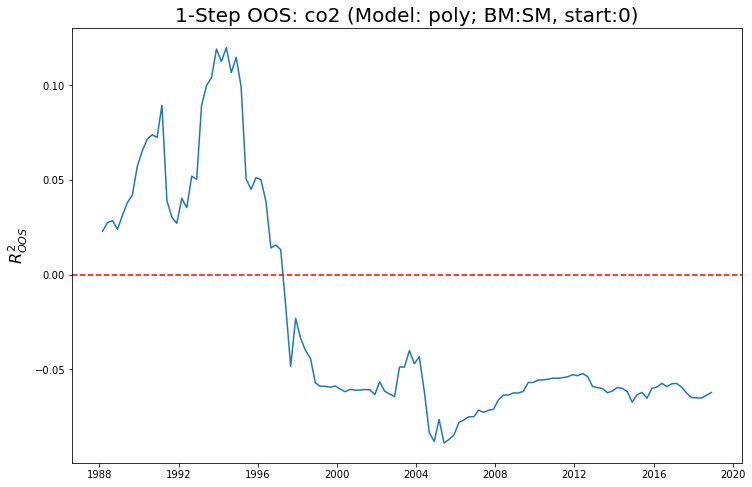

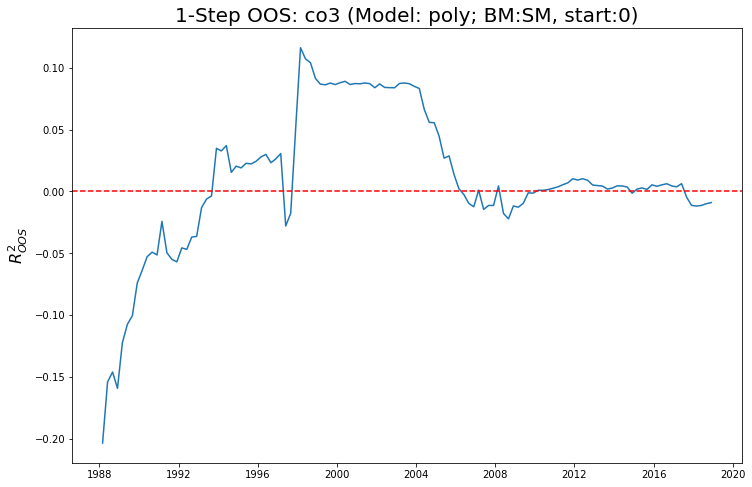

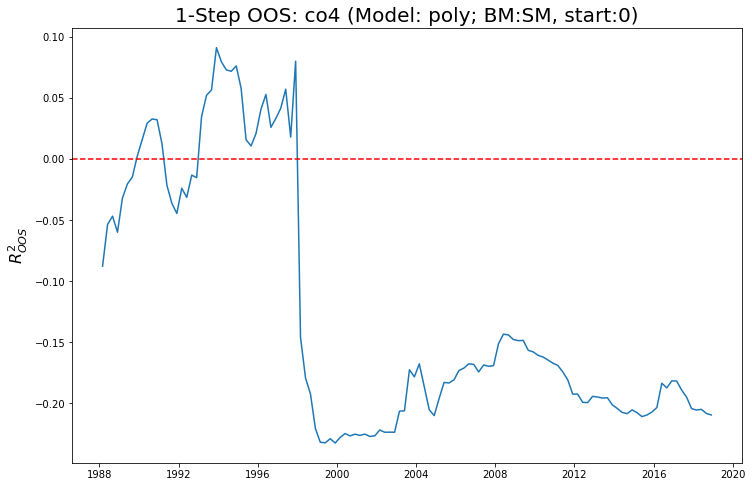

In [277]:
parent = os.getcwd()
folder = 'OOS_plots/project2'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('results/OOS_R2_project2.xlsx', header=[0,1], index_col=0, sheet_name = k)
    for i in co_list:
#         print(i)
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[i]['SM'])
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.title('1-Step OOS: '+ i + ' (' + 'Model: '+ k[:-5] + '; BM:' + 'SM' + ', start:0)', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k[:-5] + '_' + i + '_' + 'SM' + '_0'))

# Plot U

In [26]:
results = pd.read_excel('results/full_sample.xlsx', header=[0,1], index_col=[0,1])
results_taylor = pd.read_excel('results/Taylor_fullsample.xlsx', header=[0,1], index_col=[0,1])

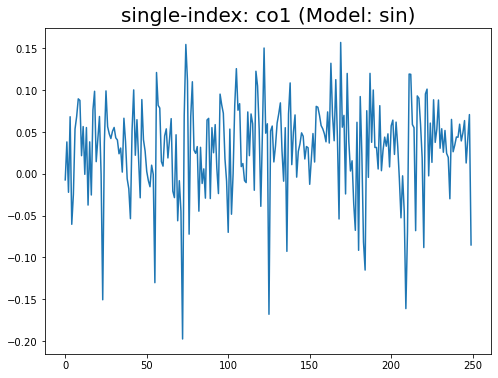

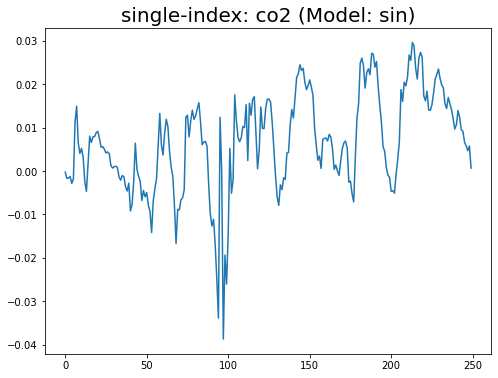

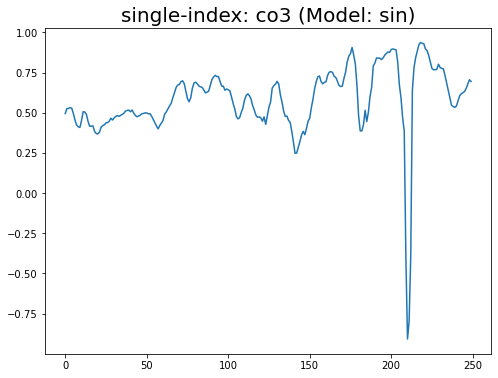

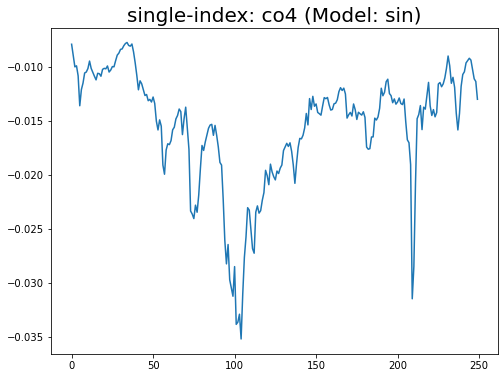

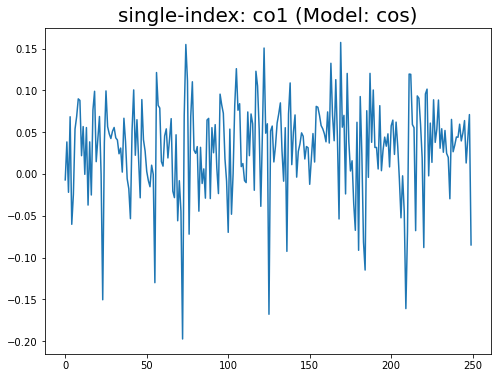

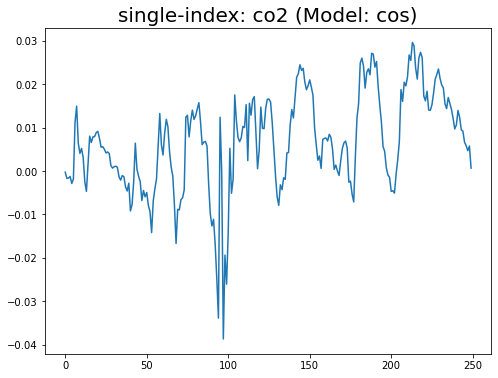

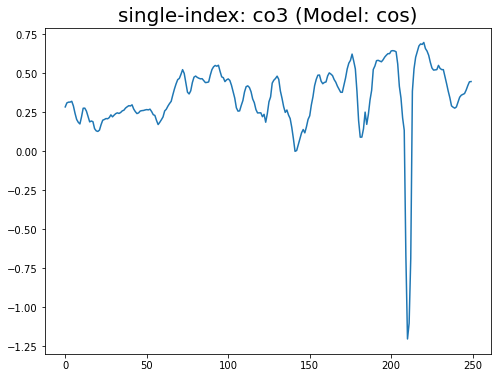

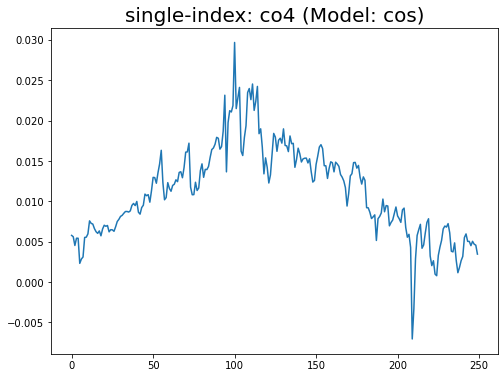

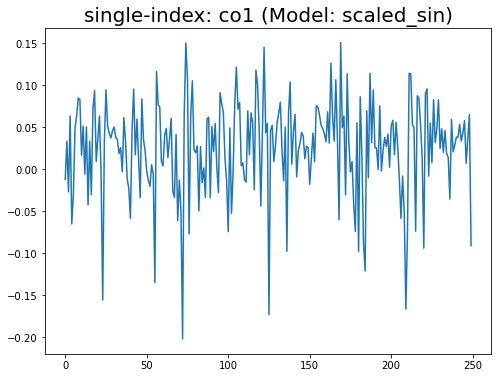

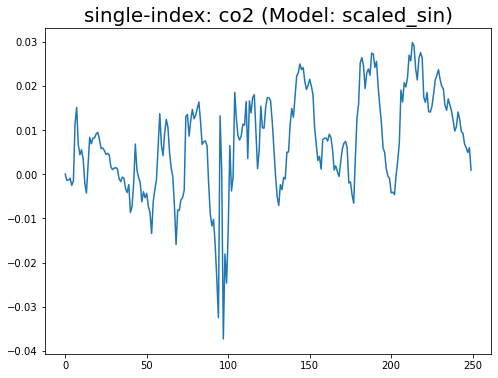

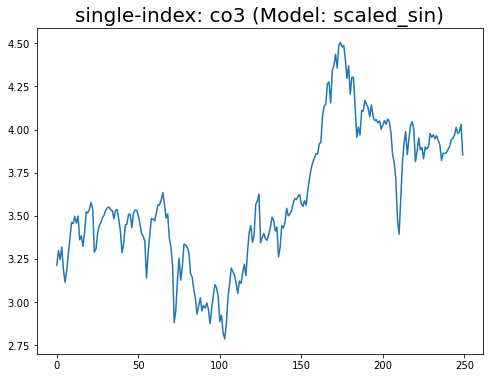

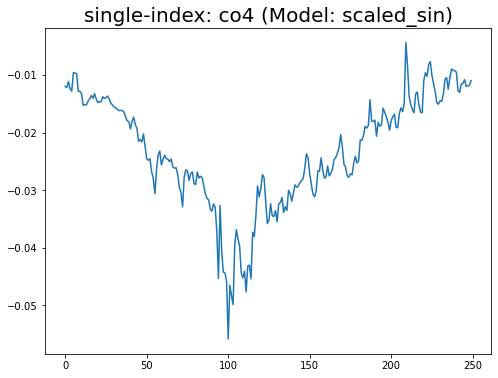

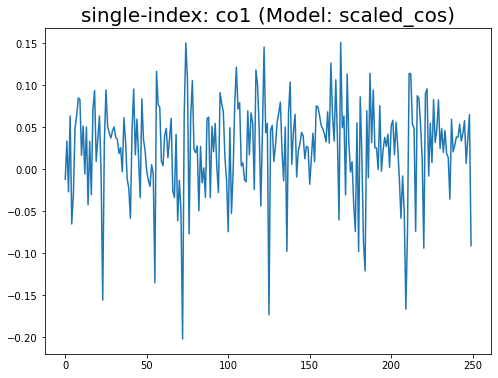

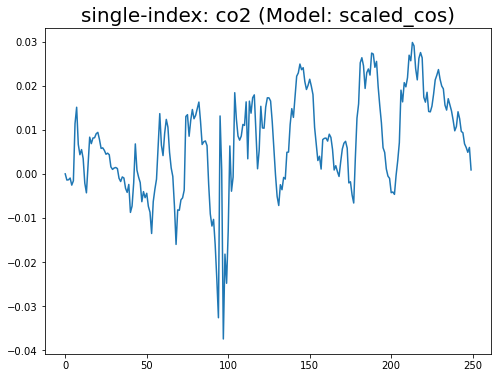

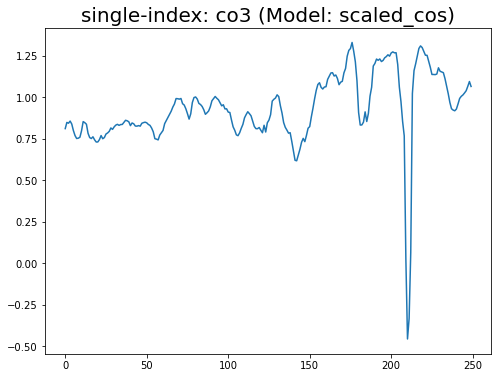

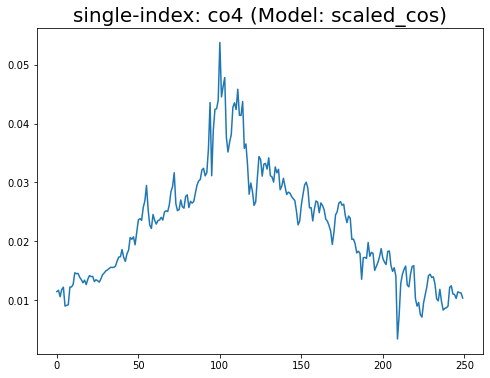

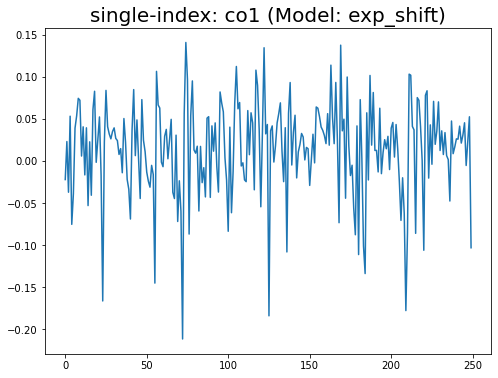

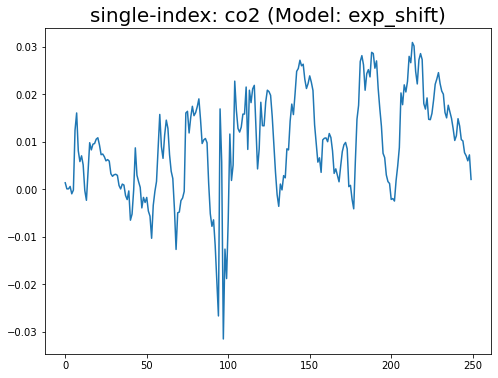

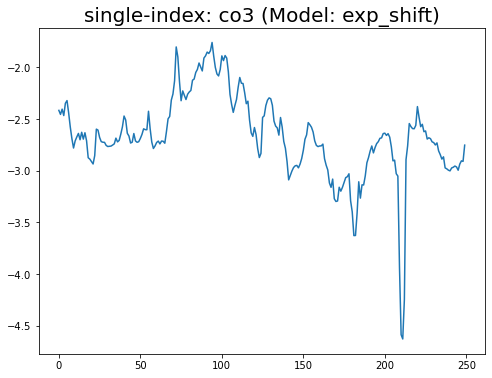

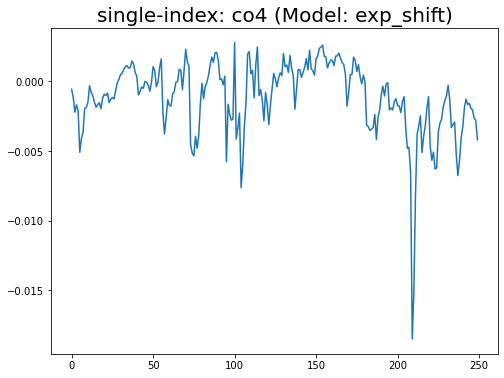

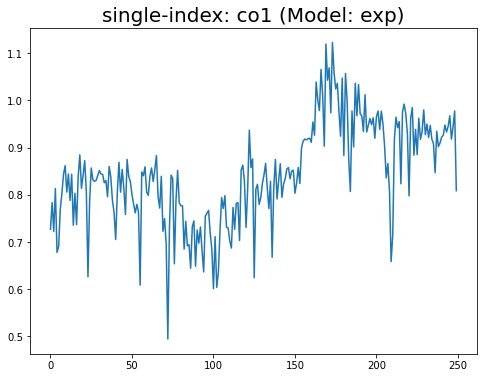

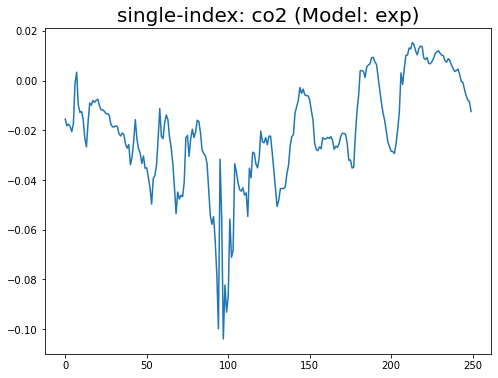

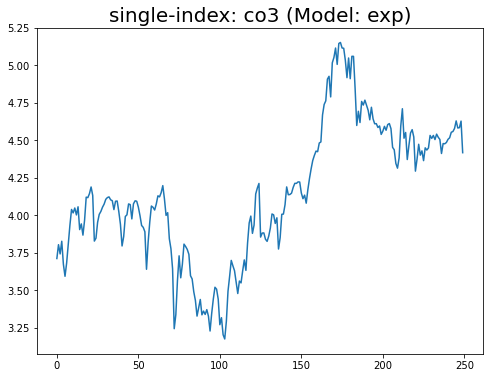

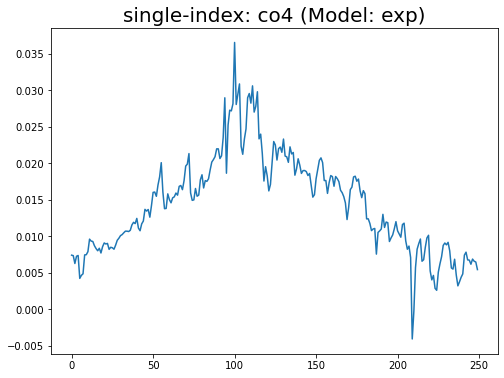

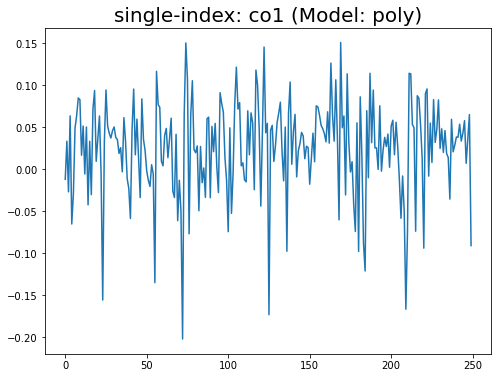

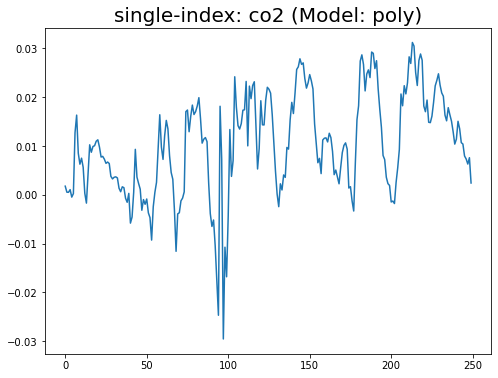

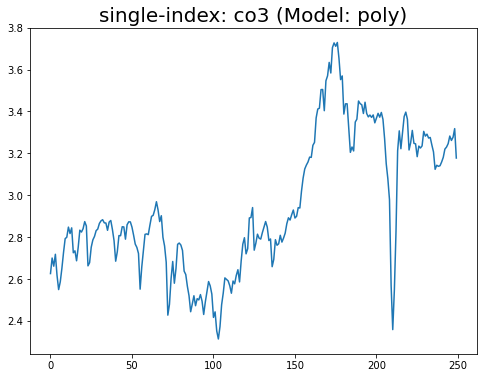

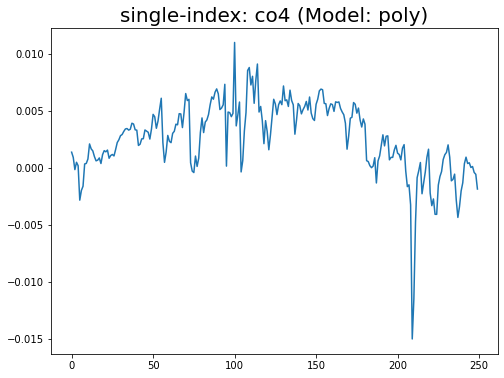

In [284]:
#Set up directory
parent = os.getcwd()
folder = 'single_index'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    for i,j in enumerate(cointe_ar2):
        fig = plt.figure(figsize = (8,6))
        plt.plot(single_index(j)(results_taylor['CLS'][['param_1', 'param_2']].loc[k].loc[co_list[i]]))
        plt.title('single-index: '+ co_list[i] + ' (' + 'Model: '+ k[:-5] + ')', fontsize=20)
        plt.savefig(os.path.join(path, k[:-5] + '_' + co_list[i]))

# In-sample $R^2$

In [32]:
station_n = pd.DataFrame()

In [ ]:
writer_R3 = pd.ExcelWriter('insample_R2_newcay.xlsx', engine='xlsxwriter')

R2_insample = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar2):
    # Set up dimensions
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['in_sample R2']
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    R2_in = pd.DataFrame(index = multi_index, columns = sec_columns)
    # Prepare X
    X_ = j.join(station_ar2)
    d1, d2, extra= dimensions(j,station_n, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    # Fit models
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar2, y_lag2, i), constraints = constraint_func(X_))
    cls.fit(X_, y_lag2)
    R2_ins = 1 - np.sum((cls.predict(X_) - np.array(y_lag2))**2)/np.sum((np.array(y)-np.mean(y))**2)
    R2_in.loc[i.__name__,j.name].loc['in_sample R2'] = R2_ins
    R2_insample = R2_insample.append(R2_in, ignore_index = False, sort = False)
    R2_insample.to_excel(writer_R3)
writer_R3.save()
writer_R3.close()

## Checking

In [233]:
mse = pd.read_excel('results/OOS_MSE_taylor.xlsx', header=[0,1], index_col=[0], sheet_name = 'sin_func')

In [234]:
mse.head()

Variable             co1                                                     \
Model            CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   AR2_MSE AR_cay_MSE   
time                                                                          
1988-03-01  4.864016e-04  0.001170  0.000096  0.004550  0.006396   0.005513   
1988-06-01  1.352886e-04  0.001787  0.000144  0.001519  0.000033   0.001798   
1988-09-01  7.140352e-05  0.000424  0.000060  0.000611  0.000404   0.000457   
1988-12-01  9.484371e-07  0.000014  0.000005  0.000033  0.000156   0.000092   
1989-03-01  3.037400e-05  0.001480  0.000024  0.001450  0.001213   0.001743   

Variable         co2                                ...       co3            \
Model        CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE  ...   NLS_MSE   AR1_MSE   
time                                                ...                       
1988-03-01  0.003160  0.001170  0.000525  0.004550  ...  0.006145  0.004550   
1988-06-01  0.001529  0.001787  0.001359  0.001519  ...  0.026609  0.001519   
1988-09-01  0.000305  0.000424  0.000371  0.000611  ...  0.011251  0.000611   
1988-12-01  0.000366  0.000014  0.000151  0.000033  ...  0.018329  0.000033   
1989-03-01  0.003296  0.001480  0.002794  0.001450  ...  0.036101  0.001450   

Variable                              co4                                \
Model        AR2_MSE AR_cay_MSE   CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   
time                                                                      
1988-03-01  0.006396   0.005513  0.005648  0.001170  0.001352  0.004550   
1988-06-01  0.000033   0.001798  0.001943  0.001787  0.002010  0.001519   
1988-09-01  0.000404   0.000457  0.000414  0.000424  0.000349  0.000611   
1988-12-01  0.000156   0.000092  0.000107  0.000014  0.000030  0.000033   
1989-03-01  0.001213   0.001743  0.001688  0.001480  0.001506  0.001450   

Variable                         
Model        AR2_MSE AR_cay_MSE  
time                             
1988-03-01  0.006396   0.005513  
1988-06-01  0.000033   0.001798  
1988-09-01  0.000404   0.000457  
1988-12-01  0.000156   0.000092  
1989-03-01  0.001213   0.001743  

[5 rows x 24 columns]

To check the OOS forecast, we take samples before 1988 as in-sample, and get the estimated parameters:

In [235]:
# station_temp = station_ar2['cay'].to_frame()
# station_temp.loc[:"1988-01-01"]

# x0 = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_ar2.loc[:"1988-01-01"], y_lag2.loc[:"1988-01-01"], sin_func)
# X_ = co1_ar2.join(station_ar2) 
# d1, d2, extra= dimensions(co1_ar2.loc[:"1988-01-01"],station_ar2.loc[:"1988-01-01"], sin_func.__name__)
# cls_try = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# cls_try.fit(X_.loc[:"1988-01-01"],y_lag2.loc[:"1988-01-01"])
# 

# cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))

# mse_s0 = cv_result['test_score']
# mse_s0[:5]
# mse_st = cv_result['test_score']
# mse_st[:5]

# a = []
# for train_index, test_index in cv_outer.split(X_):
#     X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
#     y_train, y_test = y_lag2.iloc[train_index], y_lag2.iloc[test_index]
#     cls = CLS_Estimator(obj_func = sin_func, x0 = x0, constraints = constraint_func(X_))
# #     cls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))
#     cls.fit(X_train, y_train)
#     a.append(cls.params_)
# a = pd.DataFrame(a)
# a.to_excel('coefs.xlsx', sheet_name = 'both')

CLS_Estimator(constraints={'fun': <function constraint_func.<locals>.constraint at 0x000001C5F4AB08B0>,
                           'type': 'eq'},
              obj_func=<function sin_func at 0x000001C5F497C3A0>,
              x0=array([-0.73532659,  0.67771292, -0.04396704,  0.21988944, -0.26671277]))

# NLS significance of $R^2$

In [176]:
#Set up directory
parent = os.getcwd()
folder = 'P2_signif'
path = os.path.join(os.path.join(parent, 'result'), folder)
if not os.path.exists(path):
    os.makedirs(path)

In [87]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func]

In [46]:
result_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
#     print(i.__name__, j.name)
    pred = np.empty(0)
    for train, test in cv_outer.split(j):
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        # CLS without linear part
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        nlr.fit(j.iloc[train,:],y.iloc[train])
        pred = np.append(pred, nlr.predict(j.iloc[test,:]))
    result_dict[(i.__name__, j.name)] = pred

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4
exp_func co1
exp_func co2
exp_func co3
exp_func co4
exp_shift_func co1
exp_shift_func co2
exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


In [51]:
p2_pred = pd.DataFrame.from_dict(result_dict).drop(['linear_func'], axis = 1)
p2_pred.to_excel(folder+'/p2_pred.xlsx', engine='xlsxwriter')

In [66]:
p2_pred.index = y[-124:].index
p2_pred['EQP'] = y[-124:]

In [79]:
sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
p2_pred['SM'] = sm_pred

In [91]:
sig_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    y_hat = p2_pred[i.__name__][j.name]
    y_sm = p2_pred['SM']
    y_true = p2_pred['EQP']
    sig_dict[(i.__name__, j.name)] = (y_true - y_sm)**2 - (y_true - y_hat)**2 + (y_sm - y_hat)**2

In [94]:
sig_df = pd.DataFrame.from_dict(sig_dict)
sig_df.head()

sin_func                                cos_func            \
                 co1       co2       co3       co4       co1       co2   
time                                                                     
1988-03-01 -0.001602  0.000785  0.003478 -0.000233 -0.001605  0.000786   
1988-06-01 -0.002442 -0.001358  0.010208 -0.000391  0.002599  0.000474   
1988-09-01 -0.000592  0.000046 -0.004854  0.000189  0.000513  0.000046   
1988-12-01 -0.000039 -0.000067  0.000986 -0.000012  0.000050 -0.000067   
1989-03-01 -0.002493 -0.001092  0.011218 -0.000006  0.002618 -0.001092   

                               scaled_sin_func            ...  exp_func  \
                 co3       co4             co1       co2  ...       co3   
time                                                      ...             
1988-03-01  0.003479 -0.000233       -0.000027  0.001480  ... -0.000554   
1988-06-01  0.010207 -0.000193        0.000030  0.001086  ... -0.000707   
1988-09-01 -0.004852  0.000189       -0.000019 -0.000090  ...  0.000351   
1988-12-01  0.000987 -0.000033        0.000002 -0.000074  ... -0.000069   
1989-03-01  0.011218 -0.000006        0.000030 -0.001417  ... -0.000660   

                         exp_shift_func                                \
                     co4            co1       co2       co3       co4   
time                                                                    
1988-03-01  7.217618e-08       0.068419 -0.000560  0.068419 -0.000074   
1988-06-01  8.941001e-08       0.084411 -0.000766  0.084411 -0.000427   
1988-09-01 -4.623734e-08      -0.040254  0.000437 -0.040254  0.000273   
1988-12-01  9.408031e-09       0.008013 -0.000106  0.008013 -0.000046   
1989-03-01  9.001168e-08       0.076840 -0.001239  0.076840 -0.000650   

           poly_func                                
                 co1       co2       co3       co4  
time                                                
1988-03-01  0.000533  0.001476  0.000667 -0.000897  
1988-06-01  0.003691  0.001088  0.001198 -0.002111  
1988-09-01 -0.000354 -0.000100  0.000190  0.001225  
1988-12-01  0.000058 -0.000072 -0.000087 -0.000209  
1989-03-01  0.000801 -0.001385 -0.000869 -0.004060  

[5 rows x 28 columns]

In [95]:
import statsmodels.api as sm 

In [173]:
tp_dict = {}
# p_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    t_val = []
    p_val = []
    for k in range(4,sig_df.shape[0]):
        x = np.repeat(1, k).reshape(-1,1)
        ind = sig_df.index[k-1]
        models = sm.OLS(sig_df[i.__name__][j.name].loc[:ind],x)
        result = models.fit()
        t_val.append(result.tvalues[0])
        p_val.append(result.pvalues[0])
    tp_dict[(i.__name__, j.name, 't')] = t_val
    tp_dict[i.__name__, j.name, 'p'] = p_val

In [177]:
tp_df = pd.DataFrame.from_dict(tp_dict)
tp_df.head()

sin_func                                                              \
        co1                 co2                 co3                 co4   
          t         p         t         p         t         p         t   
0 -2.190208  0.116232 -0.333052  0.761012  0.786980  0.488738 -0.882207   
1 -2.920349  0.043228 -0.857302  0.439605  1.409589  0.231462 -0.902654   
2 -2.951699  0.031823 -1.411943  0.217066  1.973033  0.105514 -0.903627   
3 -2.771555  0.032356 -1.896561  0.106677  2.517644  0.045431 -0.788230   
4 -2.624222  0.034199 -1.839632  0.108403  2.260134  0.058320 -0.793804   

             cos_func            ... exp_shift_func           poly_func  \
                  co1            ...            co4                 co1   
          p         t         p  ...              t         p         t   
0  0.442629  0.449881  0.683316  ...      -0.479622  0.664292  1.066050   
1  0.417752  1.037341  0.358167  ...      -1.150972  0.313865  1.323744   
2  0.407619 -0.066553  0.949517  ...      -1.719999  0.146062  1.762250   
3  0.460560 -0.812115  0.447739  ...      -2.173684  0.072692  2.311971   
4  0.453373 -0.824954  0.436604  ...      -2.082122  0.075847  2.082891   

                                                                         
                  co2                 co3                 co4            
          p         t         p         t         p         t         p  
0  0.364582  1.485524  0.234088  1.743085  0.179675 -0.715614  0.525899  
1  0.256172  0.399569  0.709891  0.629414  0.563238 -1.354907  0.246915  
2  0.138322 -0.310819  0.768479 -0.613166  0.566583 -1.935534  0.110702  
3  0.060106 -0.714749  0.501614 -0.032484  0.975140 -2.458064  0.049249  
4  0.075761 -0.648301  0.537468 -0.088803  0.931725 -2.196695  0.064043  

[5 rows x 56 columns]

In [189]:
tp_df.to_excel('tp_vals.xlsx')